기존의 DCGAN 모델에서는 여러번의 실험 중 일정 epoch를 넘으면 거의 비슷비슷한 얼굴이 생성되는 mode collapse 발생

WGAN은 discriminator식을 EM distance를 사용하여 변형함으로써
gradient가 잘 흘러가도록 하여 GAN이 실제 optimal 지점까지 도달할 수 있도록 하여,
결과적으로 GAN학습을 안정화시키고 mode collapse 문제까지 해결 할 수 있으므로

WGAN을 사용하여 olivetti face dataset을 다시 실험 하기로 했다.

WGAN 학습 중 바둑판 모양으로 해상도가 떨어지는 checkerboard artifact가 발생

Checkerboard Artifact 문제 해결을 위해 WGAN모델에서 
Conv2DTranspose deconvolution 방식 대신 Upsampling+convolution 으로 변경
_build_generator Upsampling interpolation 방식 변경,
generator kernel, filter, stride 수치 조정, critic part에서도 커널수가 스트라이드로 나눠 떨어지도록 조정

In [1]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.datasets import fetch_olivetti_faces
from models.WGAN2 import WGAN

x_train = fetch_olivetti_faces().images
x_train = np.expand_dims(x_train, axis = -1)

In [2]:
# run params
SECTION = 'gan'
RUN_ID = '0024'
DATA_NAME = 'face'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [3]:
print(tf.keras.backend.int_shape(x_train))

(400, 64, 64, 1)


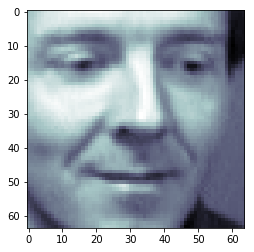

In [4]:
plt.imshow((x_train[22][:,:,0]), cmap=plt.cm.bone)

In [5]:
if mode == 'build':

    gan = WGAN(input_dim = (64,64,1)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [4,4,4,4]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.0001
            , generator_initial_dense_layer_size = (4,4,128)
            , generator_upsample = [2,2,2,1]
            , generator_conv_filters = [128,64,32,1]
            , generator_conv_kernel_size = [3,3,3,3]
            , generator_conv_strides = [1,1,1,1]
            , generator_batch_norm_momentum = 0.9
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = 0.1
            , generator_learning_rate = 0.0001
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [ ]:
'''
if mode == 'build':

    gan = WGAN(input_dim = (64,64,1)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (8,8,128)
            , generator_upsample = [2,2,2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1,1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
'''

In [6]:
gan.critic.summary()
gan.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 64, 64, 1)]       0         
_________________________________________________________________
critic_conv_0 (Conv2D)       (None, 32, 32, 32)        544       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
critic_conv_1 (Conv2D)       (None, 16, 16, 64)        32832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
critic_conv_2 (Conv2D)       (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0     

In [7]:
BATCH_SIZE = 128
EPOCHS = 20000
PRINT_EVERY_N_BATCHES = 200
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [8]:
%%time
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

0 [D loss: (-0.00007)(R -0.00055, F 0.00042)]  [G loss: 0.00006] 
1 [D loss: (-0.00229)(R -0.00406, F -0.00052)]  [G loss: 0.00104] 
2 [D loss: (-0.02793)(R -0.04535, F -0.01051)]  [G loss: -0.00358] 
3 [D loss: (-0.16580)(R -0.28096, F -0.05064)]  [G loss: -0.08998] 
4 [D loss: (-0.59497)(R -1.03376, F -0.15617)]  [G loss: -0.44167] 
5 [D loss: (-1.57532)(R -2.71718, F -0.43345)]  [G loss: -1.35268] 
6 [D loss: (-3.45192)(R -5.81660, F -1.08724)]  [G loss: -3.19809] 
7 [D loss: (-6.71252)(R -10.90364, F -2.52139)]  [G loss: -6.55281] 
8 [D loss: (-12.01529)(R -18.65372, F -5.37686)]  [G loss: -12.07779] 
9 [D loss: (-19.63320)(R -28.98137, F -10.28502)]  [G loss: -20.37466] 
10 [D loss: (-30.83682)(R -43.80371, F -17.86994)]  [G loss: -31.82181] 
11 [D loss: (-45.12687)(R -60.92424, F -29.32951)]  [G loss: -47.44922] 
12 [D loss: (-63.57319)(R -84.74585, F -42.40054)]  [G loss: -67.84708] 
13 [D loss: (-84.54995)(R -110.47875, F -58.62114)]  [G loss: -93.45290] 
14 [D loss: (-109.6129

115 [D loss: (-0.30054)(R -1.71249, F 1.11142)]  [G loss: -0.90034] 
116 [D loss: (-0.31729)(R -1.86227, F 1.22769)]  [G loss: -0.90446] 
117 [D loss: (-0.33721)(R -1.81245, F 1.13803)]  [G loss: -0.91199] 
118 [D loss: (-0.32835)(R -1.93523, F 1.27852)]  [G loss: -0.94136] 
119 [D loss: (-0.36662)(R -1.90543, F 1.17219)]  [G loss: -0.92598] 
120 [D loss: (-0.36824)(R -2.01312, F 1.27664)]  [G loss: -0.86203] 
121 [D loss: (-0.48939)(R -2.00844, F 1.02967)]  [G loss: -0.78974] 
122 [D loss: (-0.55246)(R -2.19254, F 1.08763)]  [G loss: -0.64106] 
123 [D loss: (-0.64981)(R -2.08561, F 0.78599)]  [G loss: -0.56570] 
124 [D loss: (-0.75904)(R -2.43586, F 0.91779)]  [G loss: -0.45972] 
125 [D loss: (-0.85149)(R -2.45856, F 0.75559)]  [G loss: -0.50754] 
126 [D loss: (-0.86329)(R -2.71712, F 0.99055)]  [G loss: -0.57909] 
127 [D loss: (-0.85113)(R -2.98954, F 1.28728)]  [G loss: -0.82193] 
128 [D loss: (-0.75626)(R -3.21188, F 1.69936)]  [G loss: -1.21243] 
129 [D loss: (-0.66096)(R -3.53247

235 [D loss: (-0.32750)(R 0.17314, F -0.82813)]  [G loss: 1.10074] 
236 [D loss: (-0.34184)(R 0.09700, F -0.78067)]  [G loss: 0.99534] 
237 [D loss: (-0.26598)(R 0.14184, F -0.67380)]  [G loss: 0.94770] 
238 [D loss: (-0.22301)(R 0.19250, F -0.63852)]  [G loss: 0.89284] 
239 [D loss: (-0.13749)(R 0.18054, F -0.45551)]  [G loss: 0.73055] 
240 [D loss: (0.01669)(R 0.05749, F -0.02410)]  [G loss: 0.15876] 
241 [D loss: (-0.03065)(R -0.04091, F -0.02038)]  [G loss: 0.08834] 
242 [D loss: (0.00111)(R -0.10231, F 0.10453)]  [G loss: 0.08441] 
243 [D loss: (-0.13971)(R -0.32279, F 0.04337)]  [G loss: 0.11376] 
244 [D loss: (-0.19786)(R -0.44662, F 0.05090)]  [G loss: 0.06903] 
245 [D loss: (-0.21781)(R -0.54566, F 0.11005)]  [G loss: -0.02772] 
246 [D loss: (-0.10476)(R -0.63051, F 0.42100)]  [G loss: -0.17900] 
247 [D loss: (-0.05221)(R -0.59821, F 0.49380)]  [G loss: -0.28902] 
248 [D loss: (-0.12610)(R -0.65107, F 0.39886)]  [G loss: -0.34721] 
249 [D loss: (-0.04905)(R -0.64762, F 0.54952

355 [D loss: (-0.07178)(R -0.17807, F 0.03450)]  [G loss: 0.13108] 
356 [D loss: (-0.10847)(R -0.21037, F -0.00656)]  [G loss: 0.15293] 
357 [D loss: (-0.10623)(R -0.16400, F -0.04846)]  [G loss: 0.20523] 
358 [D loss: (-0.10866)(R -0.17118, F -0.04613)]  [G loss: 0.25250] 
359 [D loss: (-0.11285)(R -0.16568, F -0.06002)]  [G loss: 0.23341] 
360 [D loss: (-0.09049)(R -0.13197, F -0.04901)]  [G loss: 0.20405] 
361 [D loss: (-0.06415)(R -0.12704, F -0.00127)]  [G loss: 0.18689] 
362 [D loss: (-0.06660)(R -0.17287, F 0.03967)]  [G loss: 0.14243] 
363 [D loss: (-0.06499)(R -0.20735, F 0.07737)]  [G loss: 0.07092] 
364 [D loss: (-0.05133)(R -0.24139, F 0.13873)]  [G loss: 0.03710] 
365 [D loss: (-0.05160)(R -0.29604, F 0.19284)]  [G loss: -0.03479] 
366 [D loss: (-0.04729)(R -0.32532, F 0.23074)]  [G loss: -0.09350] 
367 [D loss: (-0.07245)(R -0.37354, F 0.22864)]  [G loss: -0.09412] 
368 [D loss: (-0.06587)(R -0.37510, F 0.24337)]  [G loss: -0.07297] 
369 [D loss: (-0.08437)(R -0.41439, F 

474 [D loss: (-0.11133)(R -0.46510, F 0.24244)]  [G loss: -0.11825] 
475 [D loss: (-0.12882)(R -0.48227, F 0.22463)]  [G loss: -0.12953] 
476 [D loss: (-0.12004)(R -0.44586, F 0.20578)]  [G loss: -0.08966] 
477 [D loss: (-0.12737)(R -0.42173, F 0.16700)]  [G loss: -0.11415] 
478 [D loss: (-0.09682)(R -0.43341, F 0.23977)]  [G loss: -0.13281] 
479 [D loss: (-0.11314)(R -0.46589, F 0.23961)]  [G loss: -0.13434] 
480 [D loss: (-0.12251)(R -0.43916, F 0.19415)]  [G loss: -0.11036] 
481 [D loss: (-0.09472)(R -0.42194, F 0.23251)]  [G loss: -0.13711] 
482 [D loss: (-0.10582)(R -0.44688, F 0.23524)]  [G loss: -0.12361] 
483 [D loss: (-0.11259)(R -0.46508, F 0.23990)]  [G loss: -0.12028] 
484 [D loss: (-0.08989)(R -0.42858, F 0.24879)]  [G loss: -0.14132] 
485 [D loss: (-0.12144)(R -0.49675, F 0.25386)]  [G loss: -0.13983] 
486 [D loss: (-0.10190)(R -0.43382, F 0.23002)]  [G loss: -0.11024] 
487 [D loss: (-0.10480)(R -0.43468, F 0.22509)]  [G loss: -0.09344] 
488 [D loss: (-0.11110)(R -0.46270

593 [D loss: (-0.06573)(R -0.31354, F 0.18209)]  [G loss: -0.07816] 
594 [D loss: (-0.06736)(R -0.30691, F 0.17218)]  [G loss: -0.06016] 
595 [D loss: (-0.08449)(R -0.31666, F 0.14767)]  [G loss: -0.02777] 
596 [D loss: (-0.07772)(R -0.31264, F 0.15720)]  [G loss: -0.04689] 
597 [D loss: (-0.06264)(R -0.30118, F 0.17590)]  [G loss: -0.03975] 
598 [D loss: (-0.08259)(R -0.31592, F 0.15074)]  [G loss: -0.04916] 
599 [D loss: (-0.06597)(R -0.28173, F 0.14979)]  [G loss: -0.03541] 
600 [D loss: (-0.09329)(R -0.27259, F 0.08601)]  [G loss: -0.00216] 
601 [D loss: (-0.07824)(R -0.33042, F 0.17395)]  [G loss: -0.03760] 
602 [D loss: (-0.08630)(R -0.31519, F 0.14260)]  [G loss: -0.03348] 
603 [D loss: (-0.05529)(R -0.26818, F 0.15761)]  [G loss: -0.06434] 
604 [D loss: (-0.08176)(R -0.29560, F 0.13208)]  [G loss: -0.01827] 
605 [D loss: (-0.06126)(R -0.27713, F 0.15460)]  [G loss: -0.03843] 
606 [D loss: (-0.05430)(R -0.28806, F 0.17946)]  [G loss: -0.06432] 
607 [D loss: (-0.06703)(R -0.29622

713 [D loss: (-0.02571)(R -0.12247, F 0.07106)]  [G loss: -0.00962] 
714 [D loss: (-0.02098)(R -0.12886, F 0.08690)]  [G loss: -0.02770] 
715 [D loss: (-0.01448)(R -0.11351, F 0.08456)]  [G loss: -0.01595] 
716 [D loss: (-0.03418)(R -0.13899, F 0.07062)]  [G loss: -0.00310] 
717 [D loss: (-0.05848)(R -0.12396, F 0.00700)]  [G loss: 0.08922] 
718 [D loss: (-0.04107)(R -0.12566, F 0.04353)]  [G loss: 0.02669] 
719 [D loss: (-0.03405)(R -0.11098, F 0.04288)]  [G loss: 0.03680] 
720 [D loss: (-0.02458)(R -0.11924, F 0.07008)]  [G loss: 0.01237] 
721 [D loss: (-0.02378)(R -0.10917, F 0.06161)]  [G loss: 0.01722] 
722 [D loss: (-0.02951)(R -0.11034, F 0.05132)]  [G loss: -0.00115] 
723 [D loss: (-0.03027)(R -0.11044, F 0.04990)]  [G loss: 0.03199] 
724 [D loss: (-0.02574)(R -0.09862, F 0.04714)]  [G loss: 0.01193] 
725 [D loss: (-0.01636)(R -0.09082, F 0.05810)]  [G loss: 0.00141] 
726 [D loss: (-0.01443)(R -0.08919, F 0.06033)]  [G loss: 0.01072] 
727 [D loss: (-0.02517)(R -0.08401, F 0.033

834 [D loss: (-0.03963)(R -0.12243, F 0.04317)]  [G loss: 0.00241] 
835 [D loss: (-0.04572)(R -0.12323, F 0.03178)]  [G loss: 0.01345] 
836 [D loss: (-0.03584)(R -0.13152, F 0.05984)]  [G loss: -0.01664] 
837 [D loss: (-0.03268)(R -0.11285, F 0.04749)]  [G loss: 0.00744] 
838 [D loss: (-0.02811)(R -0.11001, F 0.05380)]  [G loss: -0.00820] 
839 [D loss: (-0.03817)(R -0.12019, F 0.04385)]  [G loss: 0.00631] 
840 [D loss: (-0.03813)(R -0.12542, F 0.04916)]  [G loss: -0.01039] 
841 [D loss: (-0.04203)(R -0.12479, F 0.04072)]  [G loss: 0.00584] 
842 [D loss: (-0.03023)(R -0.12218, F 0.06172)]  [G loss: -0.02012] 
843 [D loss: (-0.04155)(R -0.12936, F 0.04626)]  [G loss: -0.00300] 
844 [D loss: (-0.04126)(R -0.12704, F 0.04453)]  [G loss: 0.00052] 
845 [D loss: (-0.04565)(R -0.12649, F 0.03518)]  [G loss: 0.01911] 
846 [D loss: (-0.02602)(R -0.11622, F 0.06419)]  [G loss: -0.01917] 
847 [D loss: (-0.03554)(R -0.12334, F 0.05226)]  [G loss: 0.00772] 
848 [D loss: (-0.03417)(R -0.12340, F 0.05

953 [D loss: (-0.03555)(R -0.14423, F 0.07313)]  [G loss: -0.03289] 
954 [D loss: (-0.03258)(R -0.15041, F 0.08525)]  [G loss: -0.03562] 
955 [D loss: (-0.04028)(R -0.14223, F 0.06166)]  [G loss: -0.02121] 
956 [D loss: (-0.04239)(R -0.16103, F 0.07625)]  [G loss: -0.03646] 
957 [D loss: (-0.04442)(R -0.16509, F 0.07625)]  [G loss: -0.02846] 
958 [D loss: (-0.03392)(R -0.14723, F 0.07940)]  [G loss: -0.03141] 
959 [D loss: (-0.03468)(R -0.14496, F 0.07560)]  [G loss: -0.02665] 
960 [D loss: (-0.03020)(R -0.14697, F 0.08658)]  [G loss: -0.03367] 
961 [D loss: (-0.04490)(R -0.15312, F 0.06332)]  [G loss: -0.01790] 
962 [D loss: (-0.03043)(R -0.15032, F 0.08946)]  [G loss: -0.04471] 
963 [D loss: (-0.03797)(R -0.15746, F 0.08151)]  [G loss: -0.03683] 
964 [D loss: (-0.03937)(R -0.15429, F 0.07555)]  [G loss: -0.02370] 
965 [D loss: (-0.04114)(R -0.14152, F 0.05925)]  [G loss: -0.01774] 
966 [D loss: (-0.03236)(R -0.14615, F 0.08144)]  [G loss: -0.03293] 
967 [D loss: (-0.03655)(R -0.15302

1071 [D loss: (-0.02617)(R -0.10816, F 0.05583)]  [G loss: -0.00757] 
1072 [D loss: (-0.02904)(R -0.11420, F 0.05613)]  [G loss: -0.01816] 
1073 [D loss: (-0.02328)(R -0.10647, F 0.05990)]  [G loss: -0.01949] 
1074 [D loss: (-0.02680)(R -0.10624, F 0.05264)]  [G loss: -0.01238] 
1075 [D loss: (-0.03337)(R -0.10732, F 0.04057)]  [G loss: 0.00563] 
1076 [D loss: (-0.03001)(R -0.11023, F 0.05020)]  [G loss: -0.01603] 
1077 [D loss: (-0.02558)(R -0.11140, F 0.06024)]  [G loss: -0.01139] 
1078 [D loss: (-0.02730)(R -0.10807, F 0.05347)]  [G loss: -0.01250] 
1079 [D loss: (-0.02739)(R -0.10045, F 0.04567)]  [G loss: -0.00664] 
1080 [D loss: (-0.02868)(R -0.11031, F 0.05294)]  [G loss: -0.00482] 
1081 [D loss: (-0.02506)(R -0.10075, F 0.05062)]  [G loss: -0.01295] 
1082 [D loss: (-0.02347)(R -0.10686, F 0.05992)]  [G loss: -0.01293] 
1083 [D loss: (-0.02387)(R -0.10403, F 0.05628)]  [G loss: -0.01117] 
1084 [D loss: (-0.02582)(R -0.10501, F 0.05337)]  [G loss: -0.01722] 
1085 [D loss: (-0.027

1189 [D loss: (-0.02527)(R -0.08704, F 0.03651)]  [G loss: -0.00491] 
1190 [D loss: (-0.02055)(R -0.08368, F 0.04258)]  [G loss: -0.01215] 
1191 [D loss: (-0.01998)(R -0.08996, F 0.05000)]  [G loss: -0.00848] 
1192 [D loss: (-0.02235)(R -0.08504, F 0.04033)]  [G loss: -0.01384] 
1193 [D loss: (-0.01877)(R -0.08417, F 0.04664)]  [G loss: -0.00722] 
1194 [D loss: (-0.01874)(R -0.08640, F 0.04892)]  [G loss: -0.01658] 
1195 [D loss: (-0.02255)(R -0.09236, F 0.04726)]  [G loss: -0.01040] 
1196 [D loss: (-0.02378)(R -0.08713, F 0.03956)]  [G loss: -0.00865] 
1197 [D loss: (-0.02030)(R -0.08391, F 0.04331)]  [G loss: -0.00756] 
1198 [D loss: (-0.02036)(R -0.08021, F 0.03949)]  [G loss: -0.00857] 
1199 [D loss: (-0.02042)(R -0.08276, F 0.04192)]  [G loss: -0.00826] 
1200 [D loss: (-0.01826)(R -0.07790, F 0.04139)]  [G loss: -0.01403] 
1201 [D loss: (-0.02241)(R -0.08518, F 0.04036)]  [G loss: -0.00138] 
1202 [D loss: (-0.02020)(R -0.08385, F 0.04344)]  [G loss: -0.01554] 
1203 [D loss: (-0.01

1307 [D loss: (-0.01364)(R -0.06676, F 0.03948)]  [G loss: -0.00817] 
1308 [D loss: (-0.01652)(R -0.06515, F 0.03211)]  [G loss: -0.00373] 
1309 [D loss: (-0.01665)(R -0.07096, F 0.03766)]  [G loss: -0.00445] 
1310 [D loss: (-0.02032)(R -0.07022, F 0.02959)]  [G loss: -0.00269] 
1311 [D loss: (-0.02131)(R -0.07072, F 0.02811)]  [G loss: -0.00171] 
1312 [D loss: (-0.01586)(R -0.06965, F 0.03793)]  [G loss: -0.00970] 
1313 [D loss: (-0.02157)(R -0.07894, F 0.03581)]  [G loss: -0.00988] 
1314 [D loss: (-0.02054)(R -0.07317, F 0.03210)]  [G loss: 0.00109] 
1315 [D loss: (-0.01843)(R -0.07223, F 0.03537)]  [G loss: -0.00426] 
1316 [D loss: (-0.01388)(R -0.07017, F 0.04241)]  [G loss: -0.01476] 
1317 [D loss: (-0.01794)(R -0.07448, F 0.03860)]  [G loss: -0.01628] 
1318 [D loss: (-0.01763)(R -0.07062, F 0.03535)]  [G loss: -0.00828] 
1319 [D loss: (-0.01270)(R -0.06841, F 0.04300)]  [G loss: -0.00680] 
1320 [D loss: (-0.02068)(R -0.07463, F 0.03327)]  [G loss: -0.00665] 
1321 [D loss: (-0.019

1425 [D loss: (-0.01420)(R -0.06685, F 0.03845)]  [G loss: -0.01083] 
1426 [D loss: (-0.01666)(R -0.06724, F 0.03392)]  [G loss: -0.00704] 
1427 [D loss: (-0.01695)(R -0.06530, F 0.03140)]  [G loss: -0.00491] 
1428 [D loss: (-0.01668)(R -0.06934, F 0.03598)]  [G loss: -0.00514] 
1429 [D loss: (-0.01774)(R -0.06727, F 0.03180)]  [G loss: -0.00785] 
1430 [D loss: (-0.01617)(R -0.06524, F 0.03290)]  [G loss: -0.00572] 
1431 [D loss: (-0.01537)(R -0.06678, F 0.03603)]  [G loss: -0.00829] 
1432 [D loss: (-0.01250)(R -0.06489, F 0.03990)]  [G loss: -0.01217] 
1433 [D loss: (-0.01785)(R -0.06692, F 0.03123)]  [G loss: -0.00504] 
1434 [D loss: (-0.02068)(R -0.07113, F 0.02977)]  [G loss: -0.00477] 
1435 [D loss: (-0.01723)(R -0.06968, F 0.03521)]  [G loss: -0.00468] 
1436 [D loss: (-0.01559)(R -0.07003, F 0.03885)]  [G loss: -0.01361] 
1437 [D loss: (-0.01116)(R -0.06354, F 0.04122)]  [G loss: -0.01345] 
1438 [D loss: (-0.01435)(R -0.06751, F 0.03882)]  [G loss: -0.00941] 
1439 [D loss: (-0.01

1543 [D loss: (-0.01252)(R -0.05750, F 0.03246)]  [G loss: -0.01073] 
1544 [D loss: (-0.01749)(R -0.05938, F 0.02440)]  [G loss: -0.00352] 
1545 [D loss: (-0.01942)(R -0.06420, F 0.02537)]  [G loss: -0.00476] 
1546 [D loss: (-0.01623)(R -0.05574, F 0.02327)]  [G loss: 0.00269] 
1547 [D loss: (-0.01478)(R -0.05520, F 0.02564)]  [G loss: -0.00622] 
1548 [D loss: (-0.01566)(R -0.05636, F 0.02504)]  [G loss: 0.00070] 
1549 [D loss: (-0.01410)(R -0.05791, F 0.02971)]  [G loss: -0.00300] 
1550 [D loss: (-0.01490)(R -0.06022, F 0.03041)]  [G loss: -0.00333] 
1551 [D loss: (-0.01404)(R -0.05829, F 0.03022)]  [G loss: -0.00585] 
1552 [D loss: (-0.01614)(R -0.05766, F 0.02539)]  [G loss: -0.00388] 
1553 [D loss: (-0.01540)(R -0.06020, F 0.02940)]  [G loss: -0.00441] 
1554 [D loss: (-0.01774)(R -0.05959, F 0.02410)]  [G loss: 0.00200] 
1555 [D loss: (-0.01297)(R -0.05550, F 0.02956)]  [G loss: -0.00756] 
1556 [D loss: (-0.01689)(R -0.06060, F 0.02682)]  [G loss: -0.00587] 
1557 [D loss: (-0.01516

1661 [D loss: (-0.01872)(R -0.05726, F 0.01982)]  [G loss: 0.00334] 
1662 [D loss: (-0.01785)(R -0.05631, F 0.02060)]  [G loss: -0.00109] 
1663 [D loss: (-0.01539)(R -0.05429, F 0.02351)]  [G loss: 0.00040] 
1664 [D loss: (-0.01453)(R -0.05348, F 0.02442)]  [G loss: -0.00347] 
1665 [D loss: (-0.01375)(R -0.05345, F 0.02596)]  [G loss: -0.00341] 
1666 [D loss: (-0.01486)(R -0.04970, F 0.01998)]  [G loss: -0.00476] 
1667 [D loss: (-0.01416)(R -0.05357, F 0.02525)]  [G loss: 0.00205] 
1668 [D loss: (-0.01488)(R -0.05089, F 0.02112)]  [G loss: -0.00358] 
1669 [D loss: (-0.01475)(R -0.05503, F 0.02554)]  [G loss: -0.00292] 
1670 [D loss: (-0.01429)(R -0.05123, F 0.02266)]  [G loss: -0.00282] 
1671 [D loss: (-0.01324)(R -0.05390, F 0.02741)]  [G loss: -0.00617] 
1672 [D loss: (-0.01346)(R -0.04920, F 0.02228)]  [G loss: -0.00674] 
1673 [D loss: (-0.01347)(R -0.05217, F 0.02523)]  [G loss: -0.00599] 
1674 [D loss: (-0.01424)(R -0.05172, F 0.02324)]  [G loss: 0.00041] 
1675 [D loss: (-0.01293)

1779 [D loss: (-0.01536)(R -0.05018, F 0.01947)]  [G loss: 0.00113] 
1780 [D loss: (-0.01399)(R -0.05079, F 0.02281)]  [G loss: -0.00226] 
1781 [D loss: (-0.01456)(R -0.05086, F 0.02174)]  [G loss: -0.00297] 
1782 [D loss: (-0.01346)(R -0.04596, F 0.01903)]  [G loss: -0.00258] 
1783 [D loss: (-0.01399)(R -0.04876, F 0.02079)]  [G loss: -0.00425] 
1784 [D loss: (-0.01017)(R -0.04606, F 0.02573)]  [G loss: -0.00500] 
1785 [D loss: (-0.01438)(R -0.04761, F 0.01885)]  [G loss: 0.00077] 
1786 [D loss: (-0.01557)(R -0.04866, F 0.01751)]  [G loss: 0.00066] 
1787 [D loss: (-0.01321)(R -0.04977, F 0.02334)]  [G loss: -0.00066] 
1788 [D loss: (-0.01300)(R -0.04983, F 0.02382)]  [G loss: -0.00519] 
1789 [D loss: (-0.01415)(R -0.05095, F 0.02264)]  [G loss: -0.00398] 
1790 [D loss: (-0.01434)(R -0.04514, F 0.01646)]  [G loss: 0.00311] 
1791 [D loss: (-0.01225)(R -0.04772, F 0.02321)]  [G loss: -0.00473] 
1792 [D loss: (-0.01565)(R -0.05039, F 0.01908)]  [G loss: 0.00310] 
1793 [D loss: (-0.01630)(

1897 [D loss: (-0.01365)(R -0.04452, F 0.01723)]  [G loss: 0.00046] 
1898 [D loss: (-0.01254)(R -0.04387, F 0.01879)]  [G loss: -0.00108] 
1899 [D loss: (-0.01114)(R -0.04422, F 0.02193)]  [G loss: -0.00182] 
1900 [D loss: (-0.01445)(R -0.04785, F 0.01896)]  [G loss: -0.00312] 
1901 [D loss: (-0.01121)(R -0.04463, F 0.02222)]  [G loss: -0.00225] 
1902 [D loss: (-0.01241)(R -0.04845, F 0.02363)]  [G loss: -0.00763] 
1903 [D loss: (-0.01360)(R -0.04723, F 0.02002)]  [G loss: -0.00211] 
1904 [D loss: (-0.01414)(R -0.04559, F 0.01731)]  [G loss: -0.00169] 
1905 [D loss: (-0.01153)(R -0.04688, F 0.02382)]  [G loss: -0.00531] 
1906 [D loss: (-0.01237)(R -0.04643, F 0.02169)]  [G loss: -0.00275] 
1907 [D loss: (-0.01273)(R -0.04769, F 0.02222)]  [G loss: -0.00089] 
1908 [D loss: (-0.01543)(R -0.04921, F 0.01834)]  [G loss: -0.00174] 
1909 [D loss: (-0.01307)(R -0.04566, F 0.01952)]  [G loss: -0.00147] 
1910 [D loss: (-0.01228)(R -0.04781, F 0.02324)]  [G loss: -0.00624] 
1911 [D loss: (-0.011

2015 [D loss: (-0.00998)(R -0.03950, F 0.01954)]  [G loss: -0.00333] 
2016 [D loss: (-0.01148)(R -0.04372, F 0.02076)]  [G loss: -0.00117] 
2017 [D loss: (-0.01222)(R -0.04527, F 0.02082)]  [G loss: -0.00502] 
2018 [D loss: (-0.01240)(R -0.04362, F 0.01882)]  [G loss: -0.00337] 
2019 [D loss: (-0.01591)(R -0.04017, F 0.00836)]  [G loss: 0.00744] 
2020 [D loss: (-0.01167)(R -0.04286, F 0.01951)]  [G loss: 0.00066] 
2021 [D loss: (-0.01320)(R -0.04399, F 0.01759)]  [G loss: -0.00005] 
2022 [D loss: (-0.01426)(R -0.04359, F 0.01506)]  [G loss: 0.00432] 
2023 [D loss: (-0.01212)(R -0.04050, F 0.01626)]  [G loss: -0.00096] 
2024 [D loss: (-0.01209)(R -0.04179, F 0.01760)]  [G loss: -0.00173] 
2025 [D loss: (-0.01216)(R -0.04052, F 0.01620)]  [G loss: -0.00078] 
2026 [D loss: (-0.01181)(R -0.04155, F 0.01793)]  [G loss: -0.00148] 
2027 [D loss: (-0.01230)(R -0.04144, F 0.01684)]  [G loss: -0.00264] 
2028 [D loss: (-0.01339)(R -0.04378, F 0.01700)]  [G loss: -0.00357] 
2029 [D loss: (-0.01450

2133 [D loss: (-0.01036)(R -0.03979, F 0.01906)]  [G loss: -0.00448] 
2134 [D loss: (-0.01025)(R -0.03750, F 0.01700)]  [G loss: -0.00112] 
2135 [D loss: (-0.01228)(R -0.04079, F 0.01623)]  [G loss: -0.00315] 
2136 [D loss: (-0.01227)(R -0.04099, F 0.01645)]  [G loss: -0.00120] 
2137 [D loss: (-0.01076)(R -0.04079, F 0.01927)]  [G loss: -0.00093] 
2138 [D loss: (-0.01359)(R -0.04581, F 0.01864)]  [G loss: 0.00273] 
2139 [D loss: (-0.01281)(R -0.04069, F 0.01506)]  [G loss: 0.00068] 
2140 [D loss: (-0.01209)(R -0.03973, F 0.01555)]  [G loss: 0.00283] 
2141 [D loss: (-0.01379)(R -0.04263, F 0.01505)]  [G loss: 0.00037] 
2142 [D loss: (-0.01289)(R -0.04396, F 0.01818)]  [G loss: -0.00046] 
2143 [D loss: (-0.01171)(R -0.04270, F 0.01928)]  [G loss: -0.00268] 
2144 [D loss: (-0.01081)(R -0.04217, F 0.02054)]  [G loss: -0.00180] 
2145 [D loss: (-0.01195)(R -0.04122, F 0.01732)]  [G loss: -0.00235] 
2146 [D loss: (-0.01235)(R -0.04345, F 0.01876)]  [G loss: -0.00019] 
2147 [D loss: (-0.01207)

2251 [D loss: (-0.01330)(R -0.04152, F 0.01491)]  [G loss: 0.00054] 
2252 [D loss: (-0.01158)(R -0.04113, F 0.01796)]  [G loss: -0.00033] 
2253 [D loss: (-0.01183)(R -0.04181, F 0.01815)]  [G loss: -0.00373] 
2254 [D loss: (-0.01078)(R -0.04037, F 0.01880)]  [G loss: -0.00108] 
2255 [D loss: (-0.01325)(R -0.04068, F 0.01417)]  [G loss: -0.00036] 
2256 [D loss: (-0.01293)(R -0.04175, F 0.01590)]  [G loss: 0.00292] 
2257 [D loss: (-0.01327)(R -0.04153, F 0.01499)]  [G loss: -0.00107] 
2258 [D loss: (-0.01093)(R -0.03920, F 0.01735)]  [G loss: 0.00083] 
2259 [D loss: (-0.01449)(R -0.04184, F 0.01286)]  [G loss: 0.00187] 
2260 [D loss: (-0.01087)(R -0.04086, F 0.01911)]  [G loss: -0.00225] 
2261 [D loss: (-0.01046)(R -0.03992, F 0.01900)]  [G loss: -0.00401] 
2262 [D loss: (-0.00981)(R -0.03787, F 0.01825)]  [G loss: -0.00283] 
2263 [D loss: (-0.00963)(R -0.03752, F 0.01825)]  [G loss: -0.00247] 
2264 [D loss: (-0.01135)(R -0.04041, F 0.01772)]  [G loss: -0.00330] 
2265 [D loss: (-0.01176)

2369 [D loss: (-0.01019)(R -0.03682, F 0.01644)]  [G loss: -0.00069] 
2370 [D loss: (-0.01017)(R -0.03763, F 0.01729)]  [G loss: -0.00128] 
2371 [D loss: (-0.01020)(R -0.03835, F 0.01795)]  [G loss: -0.00355] 
2372 [D loss: (-0.01031)(R -0.03784, F 0.01721)]  [G loss: 0.00037] 
2373 [D loss: (-0.01078)(R -0.03550, F 0.01394)]  [G loss: 0.00009] 
2374 [D loss: (-0.01063)(R -0.03770, F 0.01644)]  [G loss: -0.00098] 
2375 [D loss: (-0.01007)(R -0.03551, F 0.01537)]  [G loss: -0.00200] 
2376 [D loss: (-0.01250)(R -0.04095, F 0.01595)]  [G loss: -0.00043] 
2377 [D loss: (-0.01002)(R -0.03841, F 0.01838)]  [G loss: -0.00090] 
2378 [D loss: (-0.01027)(R -0.03934, F 0.01880)]  [G loss: -0.00288] 
2379 [D loss: (-0.01072)(R -0.03708, F 0.01564)]  [G loss: 0.00091] 
2380 [D loss: (-0.01299)(R -0.03879, F 0.01281)]  [G loss: 0.00151] 
2381 [D loss: (-0.01015)(R -0.03613, F 0.01583)]  [G loss: -0.00006] 
2382 [D loss: (-0.00878)(R -0.03518, F 0.01761)]  [G loss: -0.00272] 
2383 [D loss: (-0.01213)

2487 [D loss: (-0.01061)(R -0.03630, F 0.01507)]  [G loss: 0.00081] 
2488 [D loss: (-0.01152)(R -0.03831, F 0.01528)]  [G loss: -0.00199] 
2489 [D loss: (-0.01276)(R -0.04066, F 0.01515)]  [G loss: 0.00047] 
2490 [D loss: (-0.01068)(R -0.03768, F 0.01632)]  [G loss: -0.00265] 
2491 [D loss: (-0.01064)(R -0.03615, F 0.01486)]  [G loss: -0.00247] 
2492 [D loss: (-0.00966)(R -0.03692, F 0.01760)]  [G loss: -0.00216] 
2493 [D loss: (-0.01039)(R -0.03755, F 0.01676)]  [G loss: -0.00401] 
2494 [D loss: (-0.00965)(R -0.03433, F 0.01504)]  [G loss: -0.00143] 
2495 [D loss: (-0.01220)(R -0.03950, F 0.01509)]  [G loss: 0.00049] 
2496 [D loss: (-0.01224)(R -0.03771, F 0.01322)]  [G loss: -0.00032] 
2497 [D loss: (-0.01261)(R -0.03854, F 0.01332)]  [G loss: 0.00093] 
2498 [D loss: (-0.01277)(R -0.03987, F 0.01433)]  [G loss: 0.00154] 
2499 [D loss: (-0.01264)(R -0.04057, F 0.01528)]  [G loss: 0.00018] 
2500 [D loss: (-0.00986)(R -0.03778, F 0.01807)]  [G loss: -0.00232] 
2501 [D loss: (-0.01052)(R

2605 [D loss: (-0.01072)(R -0.03693, F 0.01549)]  [G loss: 0.00239] 
2606 [D loss: (-0.01013)(R -0.03518, F 0.01492)]  [G loss: -0.00123] 
2607 [D loss: (-0.00944)(R -0.03427, F 0.01539)]  [G loss: -0.00065] 
2608 [D loss: (-0.01126)(R -0.03702, F 0.01450)]  [G loss: 0.00266] 
2609 [D loss: (-0.01032)(R -0.03466, F 0.01403)]  [G loss: 0.00122] 
2610 [D loss: (-0.01335)(R -0.03677, F 0.01006)]  [G loss: 0.00230] 
2611 [D loss: (-0.01072)(R -0.03684, F 0.01540)]  [G loss: -0.00118] 
2612 [D loss: (-0.01036)(R -0.03696, F 0.01624)]  [G loss: -0.00418] 
2613 [D loss: (-0.00980)(R -0.03464, F 0.01505)]  [G loss: -0.00221] 
2614 [D loss: (-0.00944)(R -0.03441, F 0.01553)]  [G loss: 0.00017] 
2615 [D loss: (-0.01033)(R -0.03485, F 0.01420)]  [G loss: -0.00093] 
2616 [D loss: (-0.01152)(R -0.03741, F 0.01438)]  [G loss: 0.00100] 
2617 [D loss: (-0.01101)(R -0.03692, F 0.01490)]  [G loss: -0.00024] 
2618 [D loss: (-0.01120)(R -0.03569, F 0.01328)]  [G loss: -0.00048] 
2619 [D loss: (-0.01008)(R

2723 [D loss: (-0.00881)(R -0.03204, F 0.01443)]  [G loss: -0.00345] 
2724 [D loss: (-0.00975)(R -0.03479, F 0.01528)]  [G loss: -0.00188] 
2725 [D loss: (-0.00925)(R -0.03422, F 0.01572)]  [G loss: -0.00206] 
2726 [D loss: (-0.01129)(R -0.03760, F 0.01503)]  [G loss: -0.00187] 
2727 [D loss: (-0.00946)(R -0.03360, F 0.01468)]  [G loss: -0.00098] 
2728 [D loss: (-0.01169)(R -0.03821, F 0.01484)]  [G loss: 0.00034] 
2729 [D loss: (-0.01035)(R -0.03361, F 0.01291)]  [G loss: -0.00011] 
2730 [D loss: (-0.01011)(R -0.03486, F 0.01463)]  [G loss: 0.00047] 
2731 [D loss: (-0.00959)(R -0.03559, F 0.01641)]  [G loss: -0.00129] 
2732 [D loss: (-0.00941)(R -0.03510, F 0.01628)]  [G loss: -0.00119] 
2733 [D loss: (-0.00839)(R -0.03167, F 0.01489)]  [G loss: -0.00127] 
2734 [D loss: (-0.01058)(R -0.03642, F 0.01526)]  [G loss: -0.00228] 
2735 [D loss: (-0.01092)(R -0.03626, F 0.01442)]  [G loss: -0.00200] 
2736 [D loss: (-0.00954)(R -0.03577, F 0.01668)]  [G loss: -0.00100] 
2737 [D loss: (-0.0102

2841 [D loss: (-0.01046)(R -0.03301, F 0.01210)]  [G loss: -0.00017] 
2842 [D loss: (-0.01015)(R -0.03231, F 0.01201)]  [G loss: 0.00202] 
2843 [D loss: (-0.01174)(R -0.03434, F 0.01086)]  [G loss: 0.00191] 
2844 [D loss: (-0.01001)(R -0.03489, F 0.01488)]  [G loss: -0.00060] 
2845 [D loss: (-0.01050)(R -0.03360, F 0.01261)]  [G loss: 0.00001] 
2846 [D loss: (-0.01049)(R -0.03425, F 0.01327)]  [G loss: -0.00012] 
2847 [D loss: (-0.01100)(R -0.03440, F 0.01241)]  [G loss: -0.00084] 
2848 [D loss: (-0.00944)(R -0.03246, F 0.01358)]  [G loss: -0.00032] 
2849 [D loss: (-0.00970)(R -0.03497, F 0.01557)]  [G loss: -0.00255] 
2850 [D loss: (-0.00945)(R -0.03376, F 0.01486)]  [G loss: -0.00263] 
2851 [D loss: (-0.01049)(R -0.03532, F 0.01434)]  [G loss: -0.00165] 
2852 [D loss: (-0.01042)(R -0.03432, F 0.01349)]  [G loss: 0.00096] 
2853 [D loss: (-0.00980)(R -0.03477, F 0.01517)]  [G loss: -0.00056] 
2854 [D loss: (-0.00886)(R -0.03251, F 0.01480)]  [G loss: -0.00257] 
2855 [D loss: (-0.01165)

2959 [D loss: (-0.00969)(R -0.03360, F 0.01423)]  [G loss: -0.00167] 
2960 [D loss: (-0.00907)(R -0.03221, F 0.01408)]  [G loss: -0.00254] 
2961 [D loss: (-0.00929)(R -0.03134, F 0.01276)]  [G loss: -0.00028] 
2962 [D loss: (-0.00964)(R -0.03055, F 0.01127)]  [G loss: 0.00133] 
2963 [D loss: (-0.01099)(R -0.03367, F 0.01169)]  [G loss: -0.00003] 
2964 [D loss: (-0.00912)(R -0.03018, F 0.01194)]  [G loss: 0.00095] 
2965 [D loss: (-0.00959)(R -0.03217, F 0.01299)]  [G loss: -0.00016] 
2966 [D loss: (-0.00911)(R -0.03049, F 0.01226)]  [G loss: 0.00046] 
2967 [D loss: (-0.00987)(R -0.03257, F 0.01283)]  [G loss: -0.00173] 
2968 [D loss: (-0.00924)(R -0.03139, F 0.01291)]  [G loss: 0.00053] 
2969 [D loss: (-0.00964)(R -0.03187, F 0.01259)]  [G loss: -0.00061] 
2970 [D loss: (-0.01014)(R -0.03286, F 0.01259)]  [G loss: 0.00075] 
2971 [D loss: (-0.01052)(R -0.03284, F 0.01181)]  [G loss: -0.00064] 
2972 [D loss: (-0.00926)(R -0.03012, F 0.01160)]  [G loss: 0.00044] 
2973 [D loss: (-0.00833)(R

3077 [D loss: (-0.01055)(R -0.03418, F 0.01307)]  [G loss: -0.00152] 
3078 [D loss: (-0.01040)(R -0.03448, F 0.01369)]  [G loss: -0.00086] 
3079 [D loss: (-0.00863)(R -0.03205, F 0.01479)]  [G loss: -0.00163] 
3080 [D loss: (-0.00867)(R -0.03171, F 0.01436)]  [G loss: -0.00305] 
3081 [D loss: (-0.00954)(R -0.03279, F 0.01372)]  [G loss: -0.00117] 
3082 [D loss: (-0.00897)(R -0.02992, F 0.01199)]  [G loss: -0.00108] 
3083 [D loss: (-0.00969)(R -0.03106, F 0.01167)]  [G loss: 0.00026] 
3084 [D loss: (-0.00895)(R -0.02879, F 0.01089)]  [G loss: -0.00008] 
3085 [D loss: (-0.00941)(R -0.03123, F 0.01240)]  [G loss: -0.00290] 
3086 [D loss: (-0.00936)(R -0.02985, F 0.01113)]  [G loss: 0.00267] 
3087 [D loss: (-0.00875)(R -0.02988, F 0.01238)]  [G loss: -0.00001] 
3088 [D loss: (-0.00853)(R -0.02969, F 0.01264)]  [G loss: -0.00194] 
3089 [D loss: (-0.00892)(R -0.03148, F 0.01363)]  [G loss: -0.00229] 
3090 [D loss: (-0.00980)(R -0.03274, F 0.01314)]  [G loss: -0.00194] 
3091 [D loss: (-0.0093

3195 [D loss: (-0.00997)(R -0.03352, F 0.01358)]  [G loss: -0.00274] 
3196 [D loss: (-0.00965)(R -0.03138, F 0.01208)]  [G loss: -0.00059] 
3197 [D loss: (-0.00937)(R -0.03152, F 0.01277)]  [G loss: -0.00148] 
3198 [D loss: (-0.00999)(R -0.03130, F 0.01132)]  [G loss: 0.00108] 
3199 [D loss: (-0.00824)(R -0.02970, F 0.01322)]  [G loss: -0.00067] 
3200 [D loss: (-0.00868)(R -0.03068, F 0.01333)]  [G loss: -0.00114] 
3201 [D loss: (-0.00878)(R -0.03052, F 0.01296)]  [G loss: -0.00191] 
3202 [D loss: (-0.01019)(R -0.03112, F 0.01074)]  [G loss: 0.00232] 
3203 [D loss: (-0.00897)(R -0.03012, F 0.01217)]  [G loss: -0.00135] 
3204 [D loss: (-0.00996)(R -0.03304, F 0.01312)]  [G loss: 0.00103] 
3205 [D loss: (-0.00871)(R -0.03050, F 0.01308)]  [G loss: -0.00345] 
3206 [D loss: (-0.00867)(R -0.03051, F 0.01317)]  [G loss: -0.00174] 
3207 [D loss: (-0.00861)(R -0.03041, F 0.01318)]  [G loss: -0.00175] 
3208 [D loss: (-0.00940)(R -0.03108, F 0.01227)]  [G loss: 0.00032] 
3209 [D loss: (-0.00948)

3313 [D loss: (-0.01015)(R -0.03124, F 0.01094)]  [G loss: 0.00110] 
3314 [D loss: (-0.00951)(R -0.02942, F 0.01039)]  [G loss: -0.00017] 
3315 [D loss: (-0.00999)(R -0.03079, F 0.01081)]  [G loss: 0.00162] 
3316 [D loss: (-0.00949)(R -0.03019, F 0.01120)]  [G loss: -0.00115] 
3317 [D loss: (-0.00812)(R -0.02933, F 0.01308)]  [G loss: 0.00031] 
3318 [D loss: (-0.00806)(R -0.02865, F 0.01254)]  [G loss: -0.00035] 
3319 [D loss: (-0.00794)(R -0.02809, F 0.01220)]  [G loss: -0.00178] 
3320 [D loss: (-0.00837)(R -0.02798, F 0.01125)]  [G loss: -0.00079] 
3321 [D loss: (-0.00891)(R -0.02890, F 0.01108)]  [G loss: -0.00098] 
3322 [D loss: (-0.00828)(R -0.02829, F 0.01173)]  [G loss: -0.00047] 
3323 [D loss: (-0.00780)(R -0.02728, F 0.01167)]  [G loss: 0.00107] 
3324 [D loss: (-0.00872)(R -0.02897, F 0.01154)]  [G loss: -0.00136] 
3325 [D loss: (-0.00895)(R -0.02952, F 0.01163)]  [G loss: -0.00169] 
3326 [D loss: (-0.00930)(R -0.03008, F 0.01147)]  [G loss: -0.00091] 
3327 [D loss: (-0.00912)

3431 [D loss: (-0.00807)(R -0.02770, F 0.01156)]  [G loss: -0.00018] 
3432 [D loss: (-0.00784)(R -0.02628, F 0.01060)]  [G loss: -0.00130] 
3433 [D loss: (-0.01077)(R -0.03068, F 0.00913)]  [G loss: 0.00211] 
3434 [D loss: (-0.00894)(R -0.02788, F 0.00999)]  [G loss: 0.00079] 
3435 [D loss: (-0.00771)(R -0.02683, F 0.01140)]  [G loss: 0.00011] 
3436 [D loss: (-0.00949)(R -0.03092, F 0.01194)]  [G loss: -0.00068] 
3437 [D loss: (-0.00829)(R -0.02785, F 0.01128)]  [G loss: -0.00083] 
3438 [D loss: (-0.00908)(R -0.03097, F 0.01281)]  [G loss: -0.00208] 
3439 [D loss: (-0.00792)(R -0.02762, F 0.01177)]  [G loss: -0.00087] 
3440 [D loss: (-0.00847)(R -0.02796, F 0.01103)]  [G loss: -0.00038] 
3441 [D loss: (-0.00960)(R -0.03025, F 0.01104)]  [G loss: 0.00032] 
3442 [D loss: (-0.00923)(R -0.03101, F 0.01255)]  [G loss: -0.00044] 
3443 [D loss: (-0.00747)(R -0.02767, F 0.01273)]  [G loss: -0.00302] 
3444 [D loss: (-0.00802)(R -0.02969, F 0.01365)]  [G loss: -0.00138] 
3445 [D loss: (-0.00918)

3549 [D loss: (-0.00784)(R -0.02689, F 0.01122)]  [G loss: 0.00066] 
3550 [D loss: (-0.00914)(R -0.02931, F 0.01104)]  [G loss: 0.00017] 
3551 [D loss: (-0.00812)(R -0.02761, F 0.01138)]  [G loss: 0.00020] 
3552 [D loss: (-0.00793)(R -0.02761, F 0.01174)]  [G loss: -0.00091] 
3553 [D loss: (-0.00871)(R -0.02880, F 0.01138)]  [G loss: -0.00118] 
3554 [D loss: (-0.00873)(R -0.02929, F 0.01184)]  [G loss: -0.00169] 
3555 [D loss: (-0.00840)(R -0.02862, F 0.01182)]  [G loss: -0.00058] 
3556 [D loss: (-0.00849)(R -0.02949, F 0.01251)]  [G loss: -0.00003] 
3557 [D loss: (-0.00736)(R -0.02787, F 0.01316)]  [G loss: -0.00254] 
3558 [D loss: (-0.00872)(R -0.03022, F 0.01277)]  [G loss: -0.00095] 
3559 [D loss: (-0.00837)(R -0.02878, F 0.01204)]  [G loss: -0.00178] 
3560 [D loss: (-0.00858)(R -0.02808, F 0.01091)]  [G loss: 0.00040] 
3561 [D loss: (-0.00723)(R -0.02568, F 0.01123)]  [G loss: -0.00180] 
3562 [D loss: (-0.00829)(R -0.02810, F 0.01152)]  [G loss: 0.00038] 
3563 [D loss: (-0.00963)(

3667 [D loss: (-0.00828)(R -0.02800, F 0.01145)]  [G loss: -0.00212] 
3668 [D loss: (-0.00801)(R -0.02671, F 0.01069)]  [G loss: 0.00068] 
3669 [D loss: (-0.00865)(R -0.02737, F 0.01008)]  [G loss: -0.00047] 
3670 [D loss: (-0.00654)(R -0.02512, F 0.01203)]  [G loss: -0.00281] 
3671 [D loss: (-0.00806)(R -0.02824, F 0.01212)]  [G loss: -0.00078] 
3672 [D loss: (-0.00780)(R -0.02801, F 0.01241)]  [G loss: -0.00262] 
3673 [D loss: (-0.00644)(R -0.02687, F 0.01399)]  [G loss: -0.00122] 
3674 [D loss: (-0.00759)(R -0.02608, F 0.01090)]  [G loss: -0.00124] 
3675 [D loss: (-0.00851)(R -0.02792, F 0.01091)]  [G loss: 0.00189] 
3676 [D loss: (-0.01010)(R -0.03038, F 0.01018)]  [G loss: 0.00113] 
3677 [D loss: (-0.00878)(R -0.02862, F 0.01105)]  [G loss: 0.00091] 
3678 [D loss: (-0.00783)(R -0.02670, F 0.01104)]  [G loss: -0.00078] 
3679 [D loss: (-0.00863)(R -0.02796, F 0.01070)]  [G loss: 0.00047] 
3680 [D loss: (-0.00770)(R -0.02712, F 0.01172)]  [G loss: -0.00118] 
3681 [D loss: (-0.00760)(

3785 [D loss: (-0.00837)(R -0.02523, F 0.00849)]  [G loss: 0.00145] 
3786 [D loss: (-0.00767)(R -0.02459, F 0.00925)]  [G loss: 0.00096] 
3787 [D loss: (-0.00810)(R -0.02611, F 0.00992)]  [G loss: -0.00044] 
3788 [D loss: (-0.00817)(R -0.02691, F 0.01057)]  [G loss: -0.00125] 
3789 [D loss: (-0.00847)(R -0.02671, F 0.00976)]  [G loss: 0.00250] 
3790 [D loss: (-0.00887)(R -0.02684, F 0.00910)]  [G loss: 0.00084] 
3791 [D loss: (-0.00673)(R -0.02390, F 0.01043)]  [G loss: -0.00009] 
3792 [D loss: (-0.00808)(R -0.02562, F 0.00946)]  [G loss: 0.00177] 
3793 [D loss: (-0.00970)(R -0.02774, F 0.00835)]  [G loss: 0.00108] 
3794 [D loss: (-0.00733)(R -0.02497, F 0.01032)]  [G loss: 0.00063] 
3795 [D loss: (-0.00718)(R -0.02563, F 0.01126)]  [G loss: 0.00033] 
3796 [D loss: (-0.00814)(R -0.02667, F 0.01038)]  [G loss: -0.00095] 
3797 [D loss: (-0.00932)(R -0.02784, F 0.00920)]  [G loss: 0.00236] 
3798 [D loss: (-0.00814)(R -0.02567, F 0.00938)]  [G loss: 0.00081] 
3799 [D loss: (-0.00859)(R -0.

3904 [D loss: (-0.00775)(R -0.02614, F 0.01064)]  [G loss: -0.00062] 
3905 [D loss: (-0.00752)(R -0.02609, F 0.01105)]  [G loss: -0.00254] 
3906 [D loss: (-0.00862)(R -0.02804, F 0.01079)]  [G loss: -0.00020] 
3907 [D loss: (-0.00778)(R -0.02748, F 0.01191)]  [G loss: -0.00087] 
3908 [D loss: (-0.00810)(R -0.02605, F 0.00985)]  [G loss: -0.00040] 
3909 [D loss: (-0.00760)(R -0.02659, F 0.01139)]  [G loss: -0.00091] 
3910 [D loss: (-0.00865)(R -0.02764, F 0.01035)]  [G loss: 0.00132] 
3911 [D loss: (-0.00810)(R -0.02652, F 0.01032)]  [G loss: -0.00124] 
3912 [D loss: (-0.00782)(R -0.02645, F 0.01080)]  [G loss: 0.00036] 
3913 [D loss: (-0.00773)(R -0.02476, F 0.00930)]  [G loss: 0.00083] 
3914 [D loss: (-0.00755)(R -0.02617, F 0.01108)]  [G loss: 0.00028] 
3915 [D loss: (-0.00718)(R -0.02485, F 0.01048)]  [G loss: -0.00070] 
3916 [D loss: (-0.00915)(R -0.02775, F 0.00945)]  [G loss: 0.00067] 
3917 [D loss: (-0.00811)(R -0.02688, F 0.01066)]  [G loss: 0.00008] 
3918 [D loss: (-0.00792)(R

4023 [D loss: (-0.00984)(R -0.02773, F 0.00805)]  [G loss: 0.00200] 
4024 [D loss: (-0.00893)(R -0.02689, F 0.00904)]  [G loss: 0.00123] 
4025 [D loss: (-0.00823)(R -0.02602, F 0.00956)]  [G loss: 0.00002] 
4026 [D loss: (-0.00742)(R -0.02443, F 0.00959)]  [G loss: 0.00015] 
4027 [D loss: (-0.00881)(R -0.02708, F 0.00946)]  [G loss: 0.00014] 
4028 [D loss: (-0.00761)(R -0.02478, F 0.00955)]  [G loss: 0.00053] 
4029 [D loss: (-0.00840)(R -0.02654, F 0.00974)]  [G loss: -0.00165] 
4030 [D loss: (-0.00845)(R -0.02671, F 0.00981)]  [G loss: 0.00155] 
4031 [D loss: (-0.00895)(R -0.02629, F 0.00839)]  [G loss: 0.00183] 
4032 [D loss: (-0.00855)(R -0.02617, F 0.00908)]  [G loss: 0.00158] 
4033 [D loss: (-0.00891)(R -0.02589, F 0.00807)]  [G loss: 0.00173] 
4034 [D loss: (-0.00831)(R -0.02434, F 0.00772)]  [G loss: 0.00178] 
4035 [D loss: (-0.00753)(R -0.02474, F 0.00968)]  [G loss: 0.00123] 
4036 [D loss: (-0.00739)(R -0.02473, F 0.00995)]  [G loss: 0.00037] 
4037 [D loss: (-0.00709)(R -0.023

4142 [D loss: (-0.00902)(R -0.02725, F 0.00922)]  [G loss: 0.00145] 
4143 [D loss: (-0.00744)(R -0.02413, F 0.00924)]  [G loss: -0.00034] 
4144 [D loss: (-0.00821)(R -0.02549, F 0.00907)]  [G loss: 0.00122] 
4145 [D loss: (-0.00800)(R -0.02428, F 0.00829)]  [G loss: 0.00195] 
4146 [D loss: (-0.00801)(R -0.02454, F 0.00853)]  [G loss: 0.00217] 
4147 [D loss: (-0.00806)(R -0.02430, F 0.00818)]  [G loss: 0.00133] 
4148 [D loss: (-0.00833)(R -0.02511, F 0.00845)]  [G loss: 0.00114] 
4149 [D loss: (-0.00787)(R -0.02603, F 0.01029)]  [G loss: -0.00079] 
4150 [D loss: (-0.00731)(R -0.02395, F 0.00934)]  [G loss: 0.00093] 
4151 [D loss: (-0.00784)(R -0.02568, F 0.01000)]  [G loss: -0.00076] 
4152 [D loss: (-0.00684)(R -0.02384, F 0.01016)]  [G loss: 0.00036] 
4153 [D loss: (-0.00717)(R -0.02446, F 0.01011)]  [G loss: -0.00029] 
4154 [D loss: (-0.00727)(R -0.02430, F 0.00975)]  [G loss: -0.00092] 
4155 [D loss: (-0.00879)(R -0.02690, F 0.00931)]  [G loss: 0.00048] 
4156 [D loss: (-0.00840)(R -0

4261 [D loss: (-0.00772)(R -0.02377, F 0.00834)]  [G loss: -0.00023] 
4262 [D loss: (-0.00804)(R -0.02435, F 0.00826)]  [G loss: 0.00128] 
4263 [D loss: (-0.00838)(R -0.02668, F 0.00991)]  [G loss: 0.00074] 
4264 [D loss: (-0.00685)(R -0.02407, F 0.01037)]  [G loss: -0.00073] 
4265 [D loss: (-0.00829)(R -0.02607, F 0.00950)]  [G loss: -0.00064] 
4266 [D loss: (-0.00736)(R -0.02400, F 0.00929)]  [G loss: 0.00063] 
4267 [D loss: (-0.00763)(R -0.02449, F 0.00923)]  [G loss: 0.00090] 
4268 [D loss: (-0.00805)(R -0.02485, F 0.00875)]  [G loss: 0.00095] 
4269 [D loss: (-0.00920)(R -0.02727, F 0.00887)]  [G loss: -0.00082] 
4270 [D loss: (-0.00887)(R -0.02627, F 0.00853)]  [G loss: 0.00014] 
4271 [D loss: (-0.00847)(R -0.02486, F 0.00792)]  [G loss: 0.00167] 
4272 [D loss: (-0.00891)(R -0.02664, F 0.00882)]  [G loss: 0.00027] 
4273 [D loss: (-0.00755)(R -0.02385, F 0.00876)]  [G loss: 0.00082] 
4274 [D loss: (-0.00801)(R -0.02481, F 0.00879)]  [G loss: 0.00319] 
4275 [D loss: (-0.00756)(R -0.

4380 [D loss: (-0.00736)(R -0.02484, F 0.01012)]  [G loss: 0.00007] 
4381 [D loss: (-0.00729)(R -0.02279, F 0.00821)]  [G loss: -0.00013] 
4382 [D loss: (-0.00719)(R -0.02320, F 0.00883)]  [G loss: -0.00092] 
4383 [D loss: (-0.00867)(R -0.02552, F 0.00818)]  [G loss: 0.00176] 
4384 [D loss: (-0.00724)(R -0.02247, F 0.00799)]  [G loss: 0.00218] 
4385 [D loss: (-0.00795)(R -0.02311, F 0.00721)]  [G loss: 0.00315] 
4386 [D loss: (-0.00851)(R -0.02512, F 0.00811)]  [G loss: 0.00200] 
4387 [D loss: (-0.00778)(R -0.02444, F 0.00888)]  [G loss: 0.00099] 
4388 [D loss: (-0.00690)(R -0.02201, F 0.00821)]  [G loss: 0.00077] 
4389 [D loss: (-0.00719)(R -0.02223, F 0.00786)]  [G loss: 0.00222] 
4390 [D loss: (-0.00819)(R -0.02327, F 0.00689)]  [G loss: 0.00118] 
4391 [D loss: (-0.00650)(R -0.02171, F 0.00872)]  [G loss: 0.00038] 
4392 [D loss: (-0.00707)(R -0.02214, F 0.00801)]  [G loss: 0.00099] 
4393 [D loss: (-0.00761)(R -0.02391, F 0.00868)]  [G loss: -0.00097] 
4394 [D loss: (-0.00784)(R -0.0

4499 [D loss: (-0.00800)(R -0.02393, F 0.00793)]  [G loss: 0.00116] 
4500 [D loss: (-0.00778)(R -0.02447, F 0.00891)]  [G loss: 0.00096] 
4501 [D loss: (-0.00642)(R -0.02132, F 0.00849)]  [G loss: 0.00006] 
4502 [D loss: (-0.00825)(R -0.02520, F 0.00871)]  [G loss: 0.00059] 
4503 [D loss: (-0.00822)(R -0.02407, F 0.00764)]  [G loss: 0.00221] 
4504 [D loss: (-0.00810)(R -0.02438, F 0.00819)]  [G loss: 0.00145] 
4505 [D loss: (-0.00804)(R -0.02387, F 0.00778)]  [G loss: 0.00218] 
4506 [D loss: (-0.00749)(R -0.02325, F 0.00827)]  [G loss: 0.00053] 
4507 [D loss: (-0.00759)(R -0.02442, F 0.00923)]  [G loss: 0.00122] 
4508 [D loss: (-0.00787)(R -0.02444, F 0.00870)]  [G loss: 0.00120] 
4509 [D loss: (-0.00654)(R -0.02073, F 0.00765)]  [G loss: 0.00144] 
4510 [D loss: (-0.00718)(R -0.02324, F 0.00888)]  [G loss: 0.00156] 
4511 [D loss: (-0.00774)(R -0.02339, F 0.00790)]  [G loss: 0.00196] 
4512 [D loss: (-0.00882)(R -0.02465, F 0.00701)]  [G loss: 0.00335] 
4513 [D loss: (-0.00756)(R -0.0224

4618 [D loss: (-0.00725)(R -0.02187, F 0.00737)]  [G loss: 0.00256] 
4619 [D loss: (-0.00725)(R -0.02387, F 0.00937)]  [G loss: 0.00064] 
4620 [D loss: (-0.00776)(R -0.02349, F 0.00796)]  [G loss: 0.00185] 
4621 [D loss: (-0.00885)(R -0.02507, F 0.00737)]  [G loss: 0.00023] 
4622 [D loss: (-0.00777)(R -0.02454, F 0.00899)]  [G loss: 0.00123] 
4623 [D loss: (-0.00820)(R -0.02463, F 0.00823)]  [G loss: 0.00138] 
4624 [D loss: (-0.00782)(R -0.02292, F 0.00729)]  [G loss: 0.00128] 
4625 [D loss: (-0.00744)(R -0.02334, F 0.00846)]  [G loss: 0.00173] 
4626 [D loss: (-0.00783)(R -0.02229, F 0.00662)]  [G loss: 0.00276] 
4627 [D loss: (-0.00797)(R -0.02330, F 0.00735)]  [G loss: 0.00044] 
4628 [D loss: (-0.00861)(R -0.02442, F 0.00719)]  [G loss: 0.00318] 
4629 [D loss: (-0.00735)(R -0.02268, F 0.00798)]  [G loss: 0.00047] 
4630 [D loss: (-0.00706)(R -0.02218, F 0.00806)]  [G loss: 0.00067] 
4631 [D loss: (-0.00825)(R -0.02473, F 0.00823)]  [G loss: 0.00242] 
4632 [D loss: (-0.00799)(R -0.0242

4737 [D loss: (-0.00906)(R -0.02604, F 0.00792)]  [G loss: -0.00055] 
4738 [D loss: (-0.00833)(R -0.02486, F 0.00820)]  [G loss: 0.00110] 
4739 [D loss: (-0.00715)(R -0.02225, F 0.00794)]  [G loss: 0.00136] 
4740 [D loss: (-0.00814)(R -0.02428, F 0.00799)]  [G loss: 0.00114] 
4741 [D loss: (-0.00812)(R -0.02323, F 0.00698)]  [G loss: 0.00318] 
4742 [D loss: (-0.00850)(R -0.02500, F 0.00799)]  [G loss: 0.00146] 
4743 [D loss: (-0.00794)(R -0.02333, F 0.00744)]  [G loss: 0.00144] 
4744 [D loss: (-0.00770)(R -0.02315, F 0.00774)]  [G loss: 0.00145] 
4745 [D loss: (-0.00731)(R -0.02254, F 0.00791)]  [G loss: 0.00157] 
4746 [D loss: (-0.00801)(R -0.02215, F 0.00613)]  [G loss: 0.00278] 
4747 [D loss: (-0.00809)(R -0.02297, F 0.00678)]  [G loss: 0.00122] 
4748 [D loss: (-0.00798)(R -0.02354, F 0.00759)]  [G loss: 0.00238] 
4749 [D loss: (-0.00812)(R -0.02369, F 0.00744)]  [G loss: 0.00101] 
4750 [D loss: (-0.00747)(R -0.02266, F 0.00773)]  [G loss: 0.00222] 
4751 [D loss: (-0.00752)(R -0.022

4856 [D loss: (-0.00787)(R -0.02460, F 0.00885)]  [G loss: 0.00024] 
4857 [D loss: (-0.00677)(R -0.02317, F 0.00963)]  [G loss: 0.00093] 
4858 [D loss: (-0.00662)(R -0.02126, F 0.00803)]  [G loss: 0.00118] 
4859 [D loss: (-0.00632)(R -0.02065, F 0.00801)]  [G loss: 0.00103] 
4860 [D loss: (-0.00792)(R -0.02295, F 0.00711)]  [G loss: 0.00093] 
4861 [D loss: (-0.00771)(R -0.02376, F 0.00834)]  [G loss: 0.00026] 
4862 [D loss: (-0.00696)(R -0.02236, F 0.00845)]  [G loss: 0.00199] 
4863 [D loss: (-0.00792)(R -0.02309, F 0.00726)]  [G loss: 0.00241] 
4864 [D loss: (-0.00705)(R -0.02231, F 0.00822)]  [G loss: -0.00008] 
4865 [D loss: (-0.00712)(R -0.02187, F 0.00763)]  [G loss: 0.00219] 
4866 [D loss: (-0.00755)(R -0.02340, F 0.00830)]  [G loss: 0.00171] 
4867 [D loss: (-0.00765)(R -0.02304, F 0.00774)]  [G loss: 0.00130] 
4868 [D loss: (-0.00784)(R -0.02399, F 0.00831)]  [G loss: 0.00048] 
4869 [D loss: (-0.00800)(R -0.02429, F 0.00828)]  [G loss: 0.00215] 
4870 [D loss: (-0.00790)(R -0.024

4975 [D loss: (-0.00728)(R -0.02311, F 0.00854)]  [G loss: -0.00079] 
4976 [D loss: (-0.00650)(R -0.02318, F 0.01018)]  [G loss: 0.00033] 
4977 [D loss: (-0.00706)(R -0.02265, F 0.00853)]  [G loss: 0.00125] 
4978 [D loss: (-0.00754)(R -0.02300, F 0.00793)]  [G loss: 0.00075] 
4979 [D loss: (-0.00720)(R -0.02250, F 0.00810)]  [G loss: 0.00106] 
4980 [D loss: (-0.00797)(R -0.02349, F 0.00755)]  [G loss: 0.00097] 
4981 [D loss: (-0.00743)(R -0.02279, F 0.00792)]  [G loss: 0.00129] 
4982 [D loss: (-0.00765)(R -0.02203, F 0.00673)]  [G loss: 0.00127] 
4983 [D loss: (-0.00806)(R -0.02359, F 0.00747)]  [G loss: 0.00193] 
4984 [D loss: (-0.00761)(R -0.02181, F 0.00659)]  [G loss: 0.00298] 
4985 [D loss: (-0.00900)(R -0.02377, F 0.00578)]  [G loss: 0.00245] 
4986 [D loss: (-0.00821)(R -0.02258, F 0.00617)]  [G loss: 0.00337] 
4987 [D loss: (-0.00655)(R -0.02132, F 0.00822)]  [G loss: 0.00007] 
4988 [D loss: (-0.00731)(R -0.02320, F 0.00858)]  [G loss: 0.00239] 
4989 [D loss: (-0.00746)(R -0.022

5094 [D loss: (-0.00794)(R -0.02405, F 0.00816)]  [G loss: 0.00083] 
5095 [D loss: (-0.00749)(R -0.02255, F 0.00757)]  [G loss: 0.00213] 
5096 [D loss: (-0.00731)(R -0.02497, F 0.01035)]  [G loss: -0.00018] 
5097 [D loss: (-0.00703)(R -0.02399, F 0.00993)]  [G loss: 0.00052] 
5098 [D loss: (-0.00761)(R -0.02461, F 0.00940)]  [G loss: -0.00053] 
5099 [D loss: (-0.00760)(R -0.02362, F 0.00842)]  [G loss: 0.00074] 
5100 [D loss: (-0.00806)(R -0.02449, F 0.00838)]  [G loss: 0.00011] 
5101 [D loss: (-0.00751)(R -0.02313, F 0.00811)]  [G loss: -0.00023] 
5102 [D loss: (-0.00653)(R -0.02142, F 0.00837)]  [G loss: 0.00086] 
5103 [D loss: (-0.00694)(R -0.02273, F 0.00886)]  [G loss: 0.00065] 
5104 [D loss: (-0.00738)(R -0.02337, F 0.00861)]  [G loss: 0.00226] 
5105 [D loss: (-0.00602)(R -0.02212, F 0.01008)]  [G loss: -0.00041] 
5106 [D loss: (-0.00698)(R -0.02217, F 0.00820)]  [G loss: -0.00005] 
5107 [D loss: (-0.00766)(R -0.02403, F 0.00872)]  [G loss: 0.00180] 
5108 [D loss: (-0.00703)(R -0

5213 [D loss: (-0.00855)(R -0.02430, F 0.00719)]  [G loss: 0.00150] 
5214 [D loss: (-0.00710)(R -0.02206, F 0.00785)]  [G loss: 0.00167] 
5215 [D loss: (-0.00693)(R -0.02243, F 0.00858)]  [G loss: -0.00057] 
5216 [D loss: (-0.00726)(R -0.02310, F 0.00858)]  [G loss: 0.00055] 
5217 [D loss: (-0.00844)(R -0.02512, F 0.00823)]  [G loss: 0.00058] 
5218 [D loss: (-0.00777)(R -0.02338, F 0.00783)]  [G loss: 0.00099] 
5219 [D loss: (-0.00724)(R -0.02326, F 0.00879)]  [G loss: -0.00034] 
5220 [D loss: (-0.00773)(R -0.02430, F 0.00884)]  [G loss: 0.00045] 
5221 [D loss: (-0.00733)(R -0.02233, F 0.00768)]  [G loss: 0.00156] 
5222 [D loss: (-0.00769)(R -0.02302, F 0.00765)]  [G loss: 0.00276] 
5223 [D loss: (-0.00764)(R -0.02240, F 0.00712)]  [G loss: 0.00145] 
5224 [D loss: (-0.00750)(R -0.02305, F 0.00805)]  [G loss: -0.00032] 
5225 [D loss: (-0.00815)(R -0.02317, F 0.00688)]  [G loss: 0.00133] 
5226 [D loss: (-0.00786)(R -0.02408, F 0.00835)]  [G loss: 0.00014] 
5227 [D loss: (-0.00767)(R -0.0

5332 [D loss: (-0.00745)(R -0.02249, F 0.00759)]  [G loss: 0.00010] 
5333 [D loss: (-0.00763)(R -0.02351, F 0.00825)]  [G loss: 0.00063] 
5334 [D loss: (-0.00739)(R -0.02273, F 0.00796)]  [G loss: 0.00088] 
5335 [D loss: (-0.00838)(R -0.02426, F 0.00749)]  [G loss: 0.00151] 
5336 [D loss: (-0.00768)(R -0.02288, F 0.00752)]  [G loss: 0.00165] 
5337 [D loss: (-0.00680)(R -0.02225, F 0.00865)]  [G loss: 0.00190] 
5338 [D loss: (-0.00799)(R -0.02342, F 0.00744)]  [G loss: 0.00084] 
5339 [D loss: (-0.00775)(R -0.02334, F 0.00784)]  [G loss: 0.00070] 
5340 [D loss: (-0.00588)(R -0.02125, F 0.00949)]  [G loss: -0.00071] 
5341 [D loss: (-0.00890)(R -0.02531, F 0.00750)]  [G loss: 0.00025] 
5342 [D loss: (-0.00830)(R -0.02248, F 0.00589)]  [G loss: 0.00407] 
5343 [D loss: (-0.00698)(R -0.02256, F 0.00859)]  [G loss: 0.00004] 
5344 [D loss: (-0.00649)(R -0.02223, F 0.00925)]  [G loss: -0.00029] 
5345 [D loss: (-0.00752)(R -0.02351, F 0.00846)]  [G loss: 0.00023] 
5346 [D loss: (-0.00813)(R -0.02

5451 [D loss: (-0.00776)(R -0.02250, F 0.00698)]  [G loss: 0.00065] 
5452 [D loss: (-0.00721)(R -0.02275, F 0.00834)]  [G loss: 0.00094] 
5453 [D loss: (-0.00775)(R -0.02281, F 0.00730)]  [G loss: 0.00275] 
5454 [D loss: (-0.00716)(R -0.02211, F 0.00779)]  [G loss: 0.00138] 
5455 [D loss: (-0.00941)(R -0.02491, F 0.00608)]  [G loss: 0.00240] 
5456 [D loss: (-0.00824)(R -0.02422, F 0.00775)]  [G loss: 0.00069] 
5457 [D loss: (-0.00718)(R -0.02103, F 0.00667)]  [G loss: 0.00174] 
5458 [D loss: (-0.00780)(R -0.02328, F 0.00768)]  [G loss: 0.00080] 
5459 [D loss: (-0.00793)(R -0.02380, F 0.00795)]  [G loss: 0.00053] 
5460 [D loss: (-0.00769)(R -0.02397, F 0.00858)]  [G loss: 0.00200] 
5461 [D loss: (-0.00754)(R -0.02253, F 0.00744)]  [G loss: -0.00009] 
5462 [D loss: (-0.00720)(R -0.02297, F 0.00858)]  [G loss: -0.00005] 
5463 [D loss: (-0.00750)(R -0.02143, F 0.00643)]  [G loss: 0.00209] 
5464 [D loss: (-0.00695)(R -0.02197, F 0.00808)]  [G loss: -0.00051] 
5465 [D loss: (-0.00801)(R -0.0

5570 [D loss: (-0.00715)(R -0.02249, F 0.00819)]  [G loss: 0.00077] 
5571 [D loss: (-0.00773)(R -0.02347, F 0.00802)]  [G loss: 0.00084] 
5572 [D loss: (-0.00780)(R -0.02232, F 0.00672)]  [G loss: 0.00150] 
5573 [D loss: (-0.00679)(R -0.02091, F 0.00733)]  [G loss: 0.00199] 
5574 [D loss: (-0.00686)(R -0.02067, F 0.00695)]  [G loss: 0.00090] 
5575 [D loss: (-0.00734)(R -0.02331, F 0.00863)]  [G loss: 0.00002] 
5576 [D loss: (-0.00670)(R -0.02215, F 0.00874)]  [G loss: 0.00059] 
5577 [D loss: (-0.00693)(R -0.02403, F 0.01017)]  [G loss: -0.00007] 
5578 [D loss: (-0.00695)(R -0.02262, F 0.00872)]  [G loss: 0.00000] 
5579 [D loss: (-0.00723)(R -0.02190, F 0.00744)]  [G loss: 0.00154] 
5580 [D loss: (-0.00710)(R -0.02099, F 0.00679)]  [G loss: 0.00118] 
5581 [D loss: (-0.00788)(R -0.02306, F 0.00730)]  [G loss: 0.00122] 
5582 [D loss: (-0.00685)(R -0.02187, F 0.00817)]  [G loss: 0.00033] 
5583 [D loss: (-0.00687)(R -0.02212, F 0.00838)]  [G loss: 0.00047] 
5584 [D loss: (-0.00786)(R -0.023

5689 [D loss: (-0.00782)(R -0.02278, F 0.00714)]  [G loss: 0.00066] 
5690 [D loss: (-0.00828)(R -0.02415, F 0.00760)]  [G loss: 0.00173] 
5691 [D loss: (-0.00782)(R -0.02352, F 0.00788)]  [G loss: 0.00062] 
5692 [D loss: (-0.00649)(R -0.02184, F 0.00886)]  [G loss: 0.00060] 
5693 [D loss: (-0.00746)(R -0.02345, F 0.00853)]  [G loss: -0.00004] 
5694 [D loss: (-0.00719)(R -0.02220, F 0.00783)]  [G loss: 0.00040] 
5695 [D loss: (-0.00741)(R -0.02225, F 0.00742)]  [G loss: 0.00138] 
5696 [D loss: (-0.00713)(R -0.02189, F 0.00764)]  [G loss: 0.00049] 
5697 [D loss: (-0.00741)(R -0.02237, F 0.00754)]  [G loss: 0.00001] 
5698 [D loss: (-0.00845)(R -0.02525, F 0.00836)]  [G loss: 0.00120] 
5699 [D loss: (-0.00709)(R -0.02181, F 0.00762)]  [G loss: 0.00054] 
5700 [D loss: (-0.00717)(R -0.02186, F 0.00751)]  [G loss: 0.00057] 
5701 [D loss: (-0.00779)(R -0.02264, F 0.00706)]  [G loss: 0.00237] 
5702 [D loss: (-0.00721)(R -0.02189, F 0.00748)]  [G loss: 0.00057] 
5703 [D loss: (-0.00702)(R -0.021

5808 [D loss: (-0.00703)(R -0.02269, F 0.00863)]  [G loss: 0.00110] 
5809 [D loss: (-0.00686)(R -0.02150, F 0.00779)]  [G loss: 0.00039] 
5810 [D loss: (-0.00772)(R -0.02422, F 0.00878)]  [G loss: 0.00133] 
5811 [D loss: (-0.00834)(R -0.02417, F 0.00749)]  [G loss: 0.00062] 
5812 [D loss: (-0.00689)(R -0.02343, F 0.00964)]  [G loss: -0.00083] 
5813 [D loss: (-0.00668)(R -0.02237, F 0.00902)]  [G loss: -0.00111] 
5814 [D loss: (-0.00650)(R -0.02208, F 0.00908)]  [G loss: -0.00051] 
5815 [D loss: (-0.00791)(R -0.02229, F 0.00646)]  [G loss: 0.00200] 
5816 [D loss: (-0.00677)(R -0.02173, F 0.00819)]  [G loss: 0.00052] 
5817 [D loss: (-0.00675)(R -0.02138, F 0.00789)]  [G loss: -0.00006] 
5818 [D loss: (-0.00736)(R -0.02320, F 0.00848)]  [G loss: 0.00078] 
5819 [D loss: (-0.00725)(R -0.02224, F 0.00774)]  [G loss: 0.00104] 
5820 [D loss: (-0.00681)(R -0.02184, F 0.00822)]  [G loss: -0.00065] 
5821 [D loss: (-0.00727)(R -0.02274, F 0.00820)]  [G loss: 0.00130] 
5822 [D loss: (-0.00723)(R -0

5927 [D loss: (-0.00759)(R -0.02255, F 0.00738)]  [G loss: 0.00093] 
5928 [D loss: (-0.00717)(R -0.02178, F 0.00743)]  [G loss: -0.00016] 
5929 [D loss: (-0.00723)(R -0.02208, F 0.00762)]  [G loss: 0.00096] 
5930 [D loss: (-0.00672)(R -0.02108, F 0.00763)]  [G loss: 0.00014] 
5931 [D loss: (-0.00661)(R -0.02122, F 0.00800)]  [G loss: -0.00052] 
5932 [D loss: (-0.00730)(R -0.02244, F 0.00784)]  [G loss: 0.00062] 
5933 [D loss: (-0.00735)(R -0.02264, F 0.00794)]  [G loss: 0.00033] 
5934 [D loss: (-0.00703)(R -0.02179, F 0.00774)]  [G loss: 0.00174] 
5935 [D loss: (-0.00722)(R -0.02179, F 0.00736)]  [G loss: 0.00087] 
5936 [D loss: (-0.00713)(R -0.02130, F 0.00704)]  [G loss: 0.00132] 
5937 [D loss: (-0.00752)(R -0.02168, F 0.00664)]  [G loss: 0.00028] 
5938 [D loss: (-0.00785)(R -0.02306, F 0.00736)]  [G loss: 0.00156] 
5939 [D loss: (-0.00774)(R -0.02128, F 0.00580)]  [G loss: 0.00180] 
5940 [D loss: (-0.00621)(R -0.01971, F 0.00729)]  [G loss: 0.00104] 
5941 [D loss: (-0.00723)(R -0.02

6046 [D loss: (-0.00745)(R -0.02133, F 0.00644)]  [G loss: 0.00270] 
6047 [D loss: (-0.00806)(R -0.02199, F 0.00586)]  [G loss: 0.00194] 
6048 [D loss: (-0.00685)(R -0.02140, F 0.00769)]  [G loss: 0.00108] 
6049 [D loss: (-0.00726)(R -0.02166, F 0.00715)]  [G loss: 0.00105] 
6050 [D loss: (-0.00713)(R -0.02223, F 0.00797)]  [G loss: 0.00000] 
6051 [D loss: (-0.00713)(R -0.02180, F 0.00754)]  [G loss: 0.00064] 
6052 [D loss: (-0.00703)(R -0.02131, F 0.00726)]  [G loss: 0.00098] 
6053 [D loss: (-0.00680)(R -0.02101, F 0.00742)]  [G loss: 0.00111] 
6054 [D loss: (-0.00750)(R -0.02123, F 0.00623)]  [G loss: 0.00217] 
6055 [D loss: (-0.00797)(R -0.02295, F 0.00701)]  [G loss: 0.00116] 
6056 [D loss: (-0.00727)(R -0.02326, F 0.00873)]  [G loss: 0.00043] 
6057 [D loss: (-0.00581)(R -0.02018, F 0.00855)]  [G loss: 0.00049] 
6058 [D loss: (-0.00689)(R -0.02114, F 0.00737)]  [G loss: 0.00079] 
6059 [D loss: (-0.00735)(R -0.02273, F 0.00802)]  [G loss: -0.00049] 
6060 [D loss: (-0.00739)(R -0.023

6165 [D loss: (-0.00739)(R -0.02188, F 0.00711)]  [G loss: 0.00148] 
6166 [D loss: (-0.00798)(R -0.02366, F 0.00769)]  [G loss: 0.00114] 
6167 [D loss: (-0.00819)(R -0.02398, F 0.00761)]  [G loss: -0.00007] 
6168 [D loss: (-0.00790)(R -0.02219, F 0.00639)]  [G loss: 0.00202] 
6169 [D loss: (-0.00762)(R -0.02329, F 0.00806)]  [G loss: 0.00096] 
6170 [D loss: (-0.00624)(R -0.02176, F 0.00927)]  [G loss: -0.00053] 
6171 [D loss: (-0.00653)(R -0.02037, F 0.00732)]  [G loss: 0.00046] 
6172 [D loss: (-0.00785)(R -0.02375, F 0.00805)]  [G loss: 0.00005] 
6173 [D loss: (-0.00775)(R -0.02239, F 0.00690)]  [G loss: 0.00139] 
6174 [D loss: (-0.00725)(R -0.02166, F 0.00715)]  [G loss: 0.00083] 
6175 [D loss: (-0.00588)(R -0.01968, F 0.00792)]  [G loss: 0.00098] 
6176 [D loss: (-0.00760)(R -0.02224, F 0.00704)]  [G loss: 0.00059] 
6177 [D loss: (-0.00770)(R -0.02206, F 0.00665)]  [G loss: 0.00297] 
6178 [D loss: (-0.00713)(R -0.02132, F 0.00706)]  [G loss: 0.00192] 
6179 [D loss: (-0.00722)(R -0.02

6284 [D loss: (-0.00673)(R -0.02221, F 0.00874)]  [G loss: 0.00074] 
6285 [D loss: (-0.00716)(R -0.02123, F 0.00690)]  [G loss: 0.00089] 
6286 [D loss: (-0.00691)(R -0.02207, F 0.00825)]  [G loss: -0.00061] 
6287 [D loss: (-0.00721)(R -0.02216, F 0.00774)]  [G loss: 0.00116] 
6288 [D loss: (-0.00616)(R -0.02121, F 0.00889)]  [G loss: 0.00057] 
6289 [D loss: (-0.00747)(R -0.02292, F 0.00797)]  [G loss: 0.00166] 
6290 [D loss: (-0.00698)(R -0.02118, F 0.00722)]  [G loss: 0.00061] 
6291 [D loss: (-0.00663)(R -0.02291, F 0.00965)]  [G loss: 0.00041] 
6292 [D loss: (-0.00684)(R -0.02175, F 0.00808)]  [G loss: 0.00156] 
6293 [D loss: (-0.00717)(R -0.02264, F 0.00830)]  [G loss: 0.00070] 
6294 [D loss: (-0.00699)(R -0.02148, F 0.00750)]  [G loss: 0.00081] 
6295 [D loss: (-0.00687)(R -0.02109, F 0.00735)]  [G loss: 0.00019] 
6296 [D loss: (-0.00659)(R -0.02118, F 0.00801)]  [G loss: 0.00113] 
6297 [D loss: (-0.00715)(R -0.02178, F 0.00747)]  [G loss: 0.00098] 
6298 [D loss: (-0.00706)(R -0.022

6403 [D loss: (-0.00671)(R -0.02041, F 0.00699)]  [G loss: 0.00057] 
6404 [D loss: (-0.00809)(R -0.02268, F 0.00651)]  [G loss: 0.00241] 
6405 [D loss: (-0.00749)(R -0.02194, F 0.00696)]  [G loss: 0.00168] 
6406 [D loss: (-0.00689)(R -0.02117, F 0.00739)]  [G loss: 0.00073] 
6407 [D loss: (-0.00658)(R -0.02063, F 0.00748)]  [G loss: 0.00092] 
6408 [D loss: (-0.00653)(R -0.02086, F 0.00781)]  [G loss: -0.00043] 
6409 [D loss: (-0.00723)(R -0.02192, F 0.00746)]  [G loss: 0.00108] 
6410 [D loss: (-0.00694)(R -0.02084, F 0.00697)]  [G loss: 0.00164] 
6411 [D loss: (-0.00736)(R -0.02075, F 0.00603)]  [G loss: 0.00186] 
6412 [D loss: (-0.00724)(R -0.02093, F 0.00646)]  [G loss: 0.00133] 
6413 [D loss: (-0.00662)(R -0.02129, F 0.00806)]  [G loss: 0.00114] 
6414 [D loss: (-0.00654)(R -0.02045, F 0.00738)]  [G loss: 0.00104] 
6415 [D loss: (-0.00689)(R -0.02059, F 0.00682)]  [G loss: 0.00109] 
6416 [D loss: (-0.00679)(R -0.02143, F 0.00785)]  [G loss: -0.00071] 
6417 [D loss: (-0.00619)(R -0.02

6522 [D loss: (-0.00729)(R -0.02123, F 0.00666)]  [G loss: 0.00220] 
6523 [D loss: (-0.00672)(R -0.02125, F 0.00780)]  [G loss: -0.00002] 
6524 [D loss: (-0.00630)(R -0.01948, F 0.00688)]  [G loss: 0.00129] 
6525 [D loss: (-0.00583)(R -0.01878, F 0.00711)]  [G loss: 0.00046] 
6526 [D loss: (-0.00697)(R -0.02164, F 0.00770)]  [G loss: 0.00151] 
6527 [D loss: (-0.00655)(R -0.02070, F 0.00759)]  [G loss: 0.00007] 
6528 [D loss: (-0.00697)(R -0.02092, F 0.00699)]  [G loss: 0.00086] 
6529 [D loss: (-0.00690)(R -0.02186, F 0.00805)]  [G loss: 0.00068] 
6530 [D loss: (-0.00804)(R -0.02256, F 0.00648)]  [G loss: 0.00079] 
6531 [D loss: (-0.00666)(R -0.02038, F 0.00706)]  [G loss: 0.00049] 
6532 [D loss: (-0.00764)(R -0.02195, F 0.00667)]  [G loss: 0.00131] 
6533 [D loss: (-0.00648)(R -0.02000, F 0.00704)]  [G loss: 0.00102] 
6534 [D loss: (-0.00625)(R -0.02127, F 0.00877)]  [G loss: 0.00030] 
6535 [D loss: (-0.00646)(R -0.02048, F 0.00756)]  [G loss: 0.00027] 
6536 [D loss: (-0.00656)(R -0.020

6641 [D loss: (-0.00657)(R -0.02051, F 0.00737)]  [G loss: 0.00039] 
6642 [D loss: (-0.00805)(R -0.02330, F 0.00720)]  [G loss: 0.00120] 
6643 [D loss: (-0.00714)(R -0.02132, F 0.00704)]  [G loss: 0.00134] 
6644 [D loss: (-0.00650)(R -0.02155, F 0.00855)]  [G loss: -0.00030] 
6645 [D loss: (-0.00651)(R -0.01986, F 0.00683)]  [G loss: 0.00089] 
6646 [D loss: (-0.00735)(R -0.02086, F 0.00617)]  [G loss: 0.00156] 
6647 [D loss: (-0.00648)(R -0.02099, F 0.00802)]  [G loss: -0.00049] 
6648 [D loss: (-0.00677)(R -0.02074, F 0.00720)]  [G loss: 0.00096] 
6649 [D loss: (-0.00556)(R -0.02004, F 0.00892)]  [G loss: 0.00022] 
6650 [D loss: (-0.00612)(R -0.01982, F 0.00757)]  [G loss: 0.00034] 
6651 [D loss: (-0.00737)(R -0.02154, F 0.00679)]  [G loss: 0.00183] 
6652 [D loss: (-0.00642)(R -0.02072, F 0.00788)]  [G loss: 0.00137] 
6653 [D loss: (-0.00579)(R -0.01903, F 0.00745)]  [G loss: 0.00189] 
6654 [D loss: (-0.00669)(R -0.01998, F 0.00660)]  [G loss: 0.00090] 
6655 [D loss: (-0.00708)(R -0.02

6760 [D loss: (-0.00638)(R -0.02010, F 0.00734)]  [G loss: 0.00109] 
6761 [D loss: (-0.00655)(R -0.02079, F 0.00769)]  [G loss: 0.00094] 
6762 [D loss: (-0.00657)(R -0.02068, F 0.00755)]  [G loss: 0.00066] 
6763 [D loss: (-0.00674)(R -0.02052, F 0.00704)]  [G loss: 0.00116] 
6764 [D loss: (-0.00735)(R -0.02101, F 0.00631)]  [G loss: 0.00160] 
6765 [D loss: (-0.00707)(R -0.02090, F 0.00675)]  [G loss: 0.00103] 
6766 [D loss: (-0.00639)(R -0.01972, F 0.00694)]  [G loss: 0.00020] 
6767 [D loss: (-0.00666)(R -0.02015, F 0.00684)]  [G loss: 0.00078] 
6768 [D loss: (-0.00699)(R -0.02096, F 0.00698)]  [G loss: -0.00048] 
6769 [D loss: (-0.00578)(R -0.01921, F 0.00766)]  [G loss: 0.00119] 
6770 [D loss: (-0.00823)(R -0.02217, F 0.00571)]  [G loss: 0.00122] 
6771 [D loss: (-0.00648)(R -0.02041, F 0.00746)]  [G loss: -0.00019] 
6772 [D loss: (-0.00706)(R -0.02131, F 0.00720)]  [G loss: 0.00053] 
6773 [D loss: (-0.00654)(R -0.02044, F 0.00735)]  [G loss: 0.00066] 
6774 [D loss: (-0.00803)(R -0.02

6879 [D loss: (-0.00680)(R -0.02053, F 0.00693)]  [G loss: 0.00218] 
6880 [D loss: (-0.00800)(R -0.02277, F 0.00676)]  [G loss: 0.00168] 
6881 [D loss: (-0.00670)(R -0.02185, F 0.00844)]  [G loss: -0.00074] 
6882 [D loss: (-0.00762)(R -0.02221, F 0.00698)]  [G loss: 0.00199] 
6883 [D loss: (-0.00696)(R -0.02190, F 0.00797)]  [G loss: 0.00002] 
6884 [D loss: (-0.00650)(R -0.02133, F 0.00833)]  [G loss: 0.00008] 
6885 [D loss: (-0.00578)(R -0.01925, F 0.00769)]  [G loss: 0.00040] 
6886 [D loss: (-0.00691)(R -0.02125, F 0.00743)]  [G loss: 0.00074] 
6887 [D loss: (-0.00667)(R -0.02129, F 0.00795)]  [G loss: 0.00146] 
6888 [D loss: (-0.00607)(R -0.01973, F 0.00760)]  [G loss: 0.00056] 
6889 [D loss: (-0.00627)(R -0.02074, F 0.00819)]  [G loss: 0.00002] 
6890 [D loss: (-0.00685)(R -0.02019, F 0.00649)]  [G loss: 0.00208] 
6891 [D loss: (-0.00693)(R -0.01958, F 0.00571)]  [G loss: 0.00219] 
6892 [D loss: (-0.00690)(R -0.02071, F 0.00692)]  [G loss: 0.00081] 
6893 [D loss: (-0.00730)(R -0.020

6998 [D loss: (-0.00658)(R -0.02012, F 0.00697)]  [G loss: 0.00123] 
6999 [D loss: (-0.00668)(R -0.01957, F 0.00620)]  [G loss: 0.00120] 
7000 [D loss: (-0.00696)(R -0.02113, F 0.00722)]  [G loss: -0.00046] 
7001 [D loss: (-0.00706)(R -0.02148, F 0.00735)]  [G loss: 0.00070] 
7002 [D loss: (-0.00782)(R -0.02247, F 0.00683)]  [G loss: 0.00160] 
7003 [D loss: (-0.00731)(R -0.02253, F 0.00791)]  [G loss: 0.00097] 
7004 [D loss: (-0.00603)(R -0.02012, F 0.00805)]  [G loss: 0.00002] 
7005 [D loss: (-0.00769)(R -0.02239, F 0.00700)]  [G loss: 0.00021] 
7006 [D loss: (-0.00755)(R -0.02250, F 0.00740)]  [G loss: 0.00117] 
7007 [D loss: (-0.00626)(R -0.01997, F 0.00745)]  [G loss: 0.00057] 
7008 [D loss: (-0.00590)(R -0.02077, F 0.00898)]  [G loss: 0.00055] 
7009 [D loss: (-0.00741)(R -0.02216, F 0.00735)]  [G loss: -0.00063] 
7010 [D loss: (-0.00687)(R -0.01975, F 0.00601)]  [G loss: 0.00158] 
7011 [D loss: (-0.00671)(R -0.01984, F 0.00643)]  [G loss: 0.00187] 
7012 [D loss: (-0.00750)(R -0.02

7117 [D loss: (-0.00631)(R -0.01905, F 0.00643)]  [G loss: 0.00250] 
7118 [D loss: (-0.00738)(R -0.02111, F 0.00635)]  [G loss: 0.00097] 
7119 [D loss: (-0.00715)(R -0.02215, F 0.00785)]  [G loss: 0.00091] 
7120 [D loss: (-0.00675)(R -0.02025, F 0.00676)]  [G loss: 0.00004] 
7121 [D loss: (-0.00675)(R -0.01964, F 0.00614)]  [G loss: 0.00198] 
7122 [D loss: (-0.00699)(R -0.02056, F 0.00658)]  [G loss: 0.00079] 
7123 [D loss: (-0.00657)(R -0.02115, F 0.00800)]  [G loss: 0.00014] 
7124 [D loss: (-0.00698)(R -0.02056, F 0.00659)]  [G loss: 0.00120] 
7125 [D loss: (-0.00606)(R -0.01872, F 0.00660)]  [G loss: 0.00035] 
7126 [D loss: (-0.00680)(R -0.02126, F 0.00765)]  [G loss: 0.00017] 
7127 [D loss: (-0.00702)(R -0.02231, F 0.00828)]  [G loss: 0.00050] 
7128 [D loss: (-0.00637)(R -0.02001, F 0.00726)]  [G loss: 0.00100] 
7129 [D loss: (-0.00739)(R -0.02164, F 0.00686)]  [G loss: 0.00013] 
7130 [D loss: (-0.00689)(R -0.02051, F 0.00674)]  [G loss: -0.00010] 
7131 [D loss: (-0.00614)(R -0.019

7236 [D loss: (-0.00589)(R -0.01852, F 0.00673)]  [G loss: 0.00146] 
7237 [D loss: (-0.00681)(R -0.01961, F 0.00599)]  [G loss: 0.00195] 
7238 [D loss: (-0.00739)(R -0.02254, F 0.00777)]  [G loss: 0.00246] 
7239 [D loss: (-0.00628)(R -0.01955, F 0.00698)]  [G loss: 0.00119] 
7240 [D loss: (-0.00681)(R -0.02124, F 0.00761)]  [G loss: 0.00085] 
7241 [D loss: (-0.00726)(R -0.02162, F 0.00709)]  [G loss: 0.00042] 
7242 [D loss: (-0.00629)(R -0.01961, F 0.00703)]  [G loss: 0.00042] 
7243 [D loss: (-0.00689)(R -0.02139, F 0.00762)]  [G loss: 0.00011] 
7244 [D loss: (-0.00690)(R -0.02151, F 0.00771)]  [G loss: -0.00027] 
7245 [D loss: (-0.00638)(R -0.01985, F 0.00709)]  [G loss: 0.00082] 
7246 [D loss: (-0.00673)(R -0.02047, F 0.00700)]  [G loss: 0.00076] 
7247 [D loss: (-0.00701)(R -0.02043, F 0.00642)]  [G loss: 0.00081] 
7248 [D loss: (-0.00747)(R -0.02195, F 0.00701)]  [G loss: 0.00070] 
7249 [D loss: (-0.00634)(R -0.02037, F 0.00768)]  [G loss: 0.00022] 
7250 [D loss: (-0.00688)(R -0.021

7355 [D loss: (-0.00611)(R -0.02058, F 0.00835)]  [G loss: 0.00084] 
7356 [D loss: (-0.00693)(R -0.02149, F 0.00762)]  [G loss: 0.00037] 
7357 [D loss: (-0.00679)(R -0.02093, F 0.00736)]  [G loss: 0.00189] 
7358 [D loss: (-0.00616)(R -0.01912, F 0.00680)]  [G loss: 0.00023] 
7359 [D loss: (-0.00665)(R -0.02023, F 0.00694)]  [G loss: 0.00096] 
7360 [D loss: (-0.00586)(R -0.01938, F 0.00765)]  [G loss: 0.00051] 
7361 [D loss: (-0.00703)(R -0.02102, F 0.00696)]  [G loss: 0.00061] 
7362 [D loss: (-0.00571)(R -0.01853, F 0.00711)]  [G loss: 0.00052] 
7363 [D loss: (-0.00645)(R -0.01991, F 0.00701)]  [G loss: 0.00189] 
7364 [D loss: (-0.00712)(R -0.02007, F 0.00582)]  [G loss: 0.00175] 
7365 [D loss: (-0.00758)(R -0.02119, F 0.00603)]  [G loss: 0.00173] 
7366 [D loss: (-0.00652)(R -0.02096, F 0.00793)]  [G loss: 0.00107] 
7367 [D loss: (-0.00700)(R -0.02152, F 0.00752)]  [G loss: 0.00022] 
7368 [D loss: (-0.00706)(R -0.02090, F 0.00677)]  [G loss: 0.00088] 
7369 [D loss: (-0.00691)(R -0.0207

7474 [D loss: (-0.00754)(R -0.02206, F 0.00697)]  [G loss: 0.00192] 
7475 [D loss: (-0.00637)(R -0.02016, F 0.00742)]  [G loss: -0.00117] 
7476 [D loss: (-0.00669)(R -0.02039, F 0.00701)]  [G loss: -0.00031] 
7477 [D loss: (-0.00622)(R -0.01895, F 0.00651)]  [G loss: 0.00104] 
7478 [D loss: (-0.00663)(R -0.02035, F 0.00708)]  [G loss: 0.00122] 
7479 [D loss: (-0.00704)(R -0.01984, F 0.00576)]  [G loss: 0.00098] 
7480 [D loss: (-0.00673)(R -0.02030, F 0.00684)]  [G loss: 0.00109] 
7481 [D loss: (-0.00602)(R -0.02045, F 0.00842)]  [G loss: 0.00062] 
7482 [D loss: (-0.00729)(R -0.02086, F 0.00629)]  [G loss: 0.00135] 
7483 [D loss: (-0.00604)(R -0.01972, F 0.00764)]  [G loss: -0.00004] 
7484 [D loss: (-0.00718)(R -0.02101, F 0.00666)]  [G loss: 0.00100] 
7485 [D loss: (-0.00678)(R -0.02067, F 0.00712)]  [G loss: 0.00047] 
7486 [D loss: (-0.00745)(R -0.02293, F 0.00803)]  [G loss: 0.00046] 
7487 [D loss: (-0.00658)(R -0.02185, F 0.00869)]  [G loss: -0.00021] 
7488 [D loss: (-0.00648)(R -0.

7593 [D loss: (-0.00672)(R -0.02134, F 0.00790)]  [G loss: -0.00043] 
7594 [D loss: (-0.00700)(R -0.02061, F 0.00661)]  [G loss: 0.00074] 
7595 [D loss: (-0.00650)(R -0.02045, F 0.00745)]  [G loss: 0.00001] 
7596 [D loss: (-0.00637)(R -0.01933, F 0.00660)]  [G loss: 0.00094] 
7597 [D loss: (-0.00645)(R -0.01978, F 0.00688)]  [G loss: 0.00121] 
7598 [D loss: (-0.00658)(R -0.01970, F 0.00654)]  [G loss: 0.00072] 
7599 [D loss: (-0.00564)(R -0.01929, F 0.00801)]  [G loss: 0.00075] 
7600 [D loss: (-0.00674)(R -0.02082, F 0.00734)]  [G loss: 0.00147] 
7601 [D loss: (-0.00691)(R -0.02138, F 0.00756)]  [G loss: 0.00072] 
7602 [D loss: (-0.00696)(R -0.02132, F 0.00741)]  [G loss: 0.00107] 
7603 [D loss: (-0.00597)(R -0.01954, F 0.00761)]  [G loss: 0.00143] 
7604 [D loss: (-0.00681)(R -0.02020, F 0.00657)]  [G loss: 0.00113] 
7605 [D loss: (-0.00559)(R -0.01859, F 0.00741)]  [G loss: 0.00025] 
7606 [D loss: (-0.00662)(R -0.02028, F 0.00704)]  [G loss: 0.00050] 
7607 [D loss: (-0.00647)(R -0.019

7712 [D loss: (-0.00689)(R -0.02044, F 0.00665)]  [G loss: 0.00129] 
7713 [D loss: (-0.00656)(R -0.01975, F 0.00664)]  [G loss: 0.00131] 
7714 [D loss: (-0.00661)(R -0.01870, F 0.00548)]  [G loss: 0.00138] 
7715 [D loss: (-0.00694)(R -0.02058, F 0.00670)]  [G loss: 0.00171] 
7716 [D loss: (-0.00688)(R -0.01917, F 0.00540)]  [G loss: 0.00127] 
7717 [D loss: (-0.00792)(R -0.02149, F 0.00565)]  [G loss: 0.00075] 
7718 [D loss: (-0.00703)(R -0.02053, F 0.00646)]  [G loss: 0.00225] 
7719 [D loss: (-0.00549)(R -0.01764, F 0.00667)]  [G loss: 0.00181] 
7720 [D loss: (-0.00581)(R -0.01838, F 0.00677)]  [G loss: 0.00103] 
7721 [D loss: (-0.00638)(R -0.01966, F 0.00690)]  [G loss: 0.00171] 
7722 [D loss: (-0.00624)(R -0.01881, F 0.00633)]  [G loss: 0.00074] 
7723 [D loss: (-0.00696)(R -0.02084, F 0.00692)]  [G loss: 0.00214] 
7724 [D loss: (-0.00682)(R -0.02036, F 0.00673)]  [G loss: 0.00165] 
7725 [D loss: (-0.00696)(R -0.02028, F 0.00637)]  [G loss: 0.00031] 
7726 [D loss: (-0.00713)(R -0.0204

7831 [D loss: (-0.00643)(R -0.01967, F 0.00681)]  [G loss: 0.00200] 
7832 [D loss: (-0.00658)(R -0.01970, F 0.00654)]  [G loss: 0.00103] 
7833 [D loss: (-0.00633)(R -0.01974, F 0.00707)]  [G loss: 0.00000] 
7834 [D loss: (-0.00622)(R -0.01865, F 0.00621)]  [G loss: 0.00088] 
7835 [D loss: (-0.00705)(R -0.02046, F 0.00637)]  [G loss: 0.00048] 
7836 [D loss: (-0.00749)(R -0.02150, F 0.00653)]  [G loss: 0.00077] 
7837 [D loss: (-0.00617)(R -0.01749, F 0.00516)]  [G loss: 0.00192] 
7838 [D loss: (-0.00666)(R -0.01891, F 0.00558)]  [G loss: 0.00163] 
7839 [D loss: (-0.00714)(R -0.02125, F 0.00698)]  [G loss: 0.00123] 
7840 [D loss: (-0.00704)(R -0.01993, F 0.00585)]  [G loss: 0.00105] 
7841 [D loss: (-0.00653)(R -0.01931, F 0.00626)]  [G loss: 0.00137] 
7842 [D loss: (-0.00704)(R -0.02030, F 0.00623)]  [G loss: 0.00192] 
7843 [D loss: (-0.00671)(R -0.01962, F 0.00620)]  [G loss: 0.00120] 
7844 [D loss: (-0.00666)(R -0.02012, F 0.00679)]  [G loss: 0.00087] 
7845 [D loss: (-0.00689)(R -0.0201

7950 [D loss: (-0.00609)(R -0.01914, F 0.00697)]  [G loss: 0.00126] 
7951 [D loss: (-0.00627)(R -0.01929, F 0.00674)]  [G loss: 0.00027] 
7952 [D loss: (-0.00577)(R -0.01842, F 0.00688)]  [G loss: 0.00109] 
7953 [D loss: (-0.00702)(R -0.02049, F 0.00644)]  [G loss: 0.00026] 
7954 [D loss: (-0.00617)(R -0.01841, F 0.00606)]  [G loss: 0.00158] 
7955 [D loss: (-0.00721)(R -0.02043, F 0.00602)]  [G loss: 0.00119] 
7956 [D loss: (-0.00670)(R -0.01990, F 0.00650)]  [G loss: 0.00169] 
7957 [D loss: (-0.00724)(R -0.02073, F 0.00625)]  [G loss: 0.00114] 
7958 [D loss: (-0.00688)(R -0.02019, F 0.00642)]  [G loss: 0.00139] 
7959 [D loss: (-0.00712)(R -0.02121, F 0.00698)]  [G loss: 0.00054] 
7960 [D loss: (-0.00672)(R -0.01990, F 0.00646)]  [G loss: 0.00152] 
7961 [D loss: (-0.00544)(R -0.01775, F 0.00688)]  [G loss: -0.00001] 
7962 [D loss: (-0.00647)(R -0.01932, F 0.00638)]  [G loss: 0.00107] 
7963 [D loss: (-0.00800)(R -0.02052, F 0.00452)]  [G loss: 0.00163] 
7964 [D loss: (-0.00721)(R -0.021

8069 [D loss: (-0.00707)(R -0.02006, F 0.00593)]  [G loss: 0.00235] 
8070 [D loss: (-0.00689)(R -0.02028, F 0.00649)]  [G loss: 0.00053] 
8071 [D loss: (-0.00672)(R -0.02112, F 0.00769)]  [G loss: -0.00013] 
8072 [D loss: (-0.00639)(R -0.01987, F 0.00709)]  [G loss: 0.00057] 
8073 [D loss: (-0.00659)(R -0.01966, F 0.00647)]  [G loss: 0.00016] 
8074 [D loss: (-0.00579)(R -0.01833, F 0.00675)]  [G loss: 0.00069] 
8075 [D loss: (-0.00639)(R -0.02027, F 0.00748)]  [G loss: -0.00008] 
8076 [D loss: (-0.00660)(R -0.02075, F 0.00755)]  [G loss: -0.00002] 
8077 [D loss: (-0.00649)(R -0.02037, F 0.00738)]  [G loss: 0.00023] 
8078 [D loss: (-0.00738)(R -0.02117, F 0.00640)]  [G loss: 0.00077] 
8079 [D loss: (-0.00545)(R -0.01922, F 0.00831)]  [G loss: 0.00027] 
8080 [D loss: (-0.00683)(R -0.02088, F 0.00722)]  [G loss: 0.00101] 
8081 [D loss: (-0.00622)(R -0.02013, F 0.00769)]  [G loss: -0.00006] 
8082 [D loss: (-0.00744)(R -0.02208, F 0.00721)]  [G loss: -0.00036] 
8083 [D loss: (-0.00632)(R -0

8188 [D loss: (-0.00669)(R -0.01966, F 0.00628)]  [G loss: -0.00021] 
8189 [D loss: (-0.00638)(R -0.01953, F 0.00677)]  [G loss: 0.00088] 
8190 [D loss: (-0.00607)(R -0.01971, F 0.00758)]  [G loss: 0.00104] 
8191 [D loss: (-0.00649)(R -0.02043, F 0.00746)]  [G loss: -0.00013] 
8192 [D loss: (-0.00639)(R -0.01983, F 0.00706)]  [G loss: -0.00035] 
8193 [D loss: (-0.00660)(R -0.02036, F 0.00717)]  [G loss: -0.00011] 
8194 [D loss: (-0.00703)(R -0.02036, F 0.00630)]  [G loss: 0.00120] 
8195 [D loss: (-0.00643)(R -0.01940, F 0.00653)]  [G loss: 0.00080] 
8196 [D loss: (-0.00580)(R -0.01829, F 0.00669)]  [G loss: 0.00137] 
8197 [D loss: (-0.00622)(R -0.01885, F 0.00642)]  [G loss: 0.00071] 
8198 [D loss: (-0.00683)(R -0.02020, F 0.00655)]  [G loss: 0.00163] 
8199 [D loss: (-0.00651)(R -0.01924, F 0.00622)]  [G loss: 0.00089] 
8200 [D loss: (-0.00638)(R -0.01918, F 0.00641)]  [G loss: 0.00101] 
8201 [D loss: (-0.00556)(R -0.01900, F 0.00788)]  [G loss: 0.00028] 
8202 [D loss: (-0.00659)(R -0.

8307 [D loss: (-0.00572)(R -0.01804, F 0.00659)]  [G loss: 0.00173] 
8308 [D loss: (-0.00690)(R -0.01974, F 0.00595)]  [G loss: 0.00140] 
8309 [D loss: (-0.00656)(R -0.01824, F 0.00511)]  [G loss: 0.00192] 
8310 [D loss: (-0.00631)(R -0.01815, F 0.00553)]  [G loss: 0.00206] 
8311 [D loss: (-0.00614)(R -0.01799, F 0.00570)]  [G loss: 0.00048] 
8312 [D loss: (-0.00607)(R -0.01910, F 0.00695)]  [G loss: 0.00032] 
8313 [D loss: (-0.00540)(R -0.01829, F 0.00749)]  [G loss: 0.00061] 
8314 [D loss: (-0.00611)(R -0.01940, F 0.00719)]  [G loss: 0.00029] 
8315 [D loss: (-0.00688)(R -0.02015, F 0.00639)]  [G loss: 0.00209] 
8316 [D loss: (-0.00686)(R -0.01968, F 0.00597)]  [G loss: 0.00293] 
8317 [D loss: (-0.00630)(R -0.01892, F 0.00633)]  [G loss: 0.00042] 
8318 [D loss: (-0.00623)(R -0.01863, F 0.00616)]  [G loss: 0.00082] 
8319 [D loss: (-0.00644)(R -0.01938, F 0.00650)]  [G loss: 0.00100] 
8320 [D loss: (-0.00758)(R -0.02211, F 0.00694)]  [G loss: 0.00171] 
8321 [D loss: (-0.00633)(R -0.0194

8426 [D loss: (-0.00720)(R -0.02095, F 0.00655)]  [G loss: 0.00101] 
8427 [D loss: (-0.00623)(R -0.02006, F 0.00760)]  [G loss: 0.00070] 
8428 [D loss: (-0.00707)(R -0.02009, F 0.00596)]  [G loss: 0.00166] 
8429 [D loss: (-0.00599)(R -0.01916, F 0.00718)]  [G loss: 0.00181] 
8430 [D loss: (-0.00751)(R -0.02080, F 0.00578)]  [G loss: 0.00026] 
8431 [D loss: (-0.00637)(R -0.02027, F 0.00752)]  [G loss: 0.00141] 
8432 [D loss: (-0.00663)(R -0.01896, F 0.00570)]  [G loss: 0.00250] 
8433 [D loss: (-0.00633)(R -0.01920, F 0.00653)]  [G loss: 0.00056] 
8434 [D loss: (-0.00734)(R -0.02052, F 0.00584)]  [G loss: 0.00210] 
8435 [D loss: (-0.00677)(R -0.01981, F 0.00627)]  [G loss: 0.00130] 
8436 [D loss: (-0.00589)(R -0.01796, F 0.00617)]  [G loss: 0.00136] 
8437 [D loss: (-0.00608)(R -0.01882, F 0.00665)]  [G loss: 0.00083] 
8438 [D loss: (-0.00616)(R -0.01839, F 0.00606)]  [G loss: 0.00102] 
8439 [D loss: (-0.00629)(R -0.01882, F 0.00624)]  [G loss: 0.00157] 
8440 [D loss: (-0.00701)(R -0.0205

8545 [D loss: (-0.00618)(R -0.01839, F 0.00603)]  [G loss: 0.00060] 
8546 [D loss: (-0.00635)(R -0.01884, F 0.00614)]  [G loss: 0.00081] 
8547 [D loss: (-0.00632)(R -0.01976, F 0.00713)]  [G loss: 0.00025] 
8548 [D loss: (-0.00606)(R -0.01932, F 0.00720)]  [G loss: 0.00073] 
8549 [D loss: (-0.00558)(R -0.01825, F 0.00709)]  [G loss: 0.00129] 
8550 [D loss: (-0.00625)(R -0.01870, F 0.00619)]  [G loss: 0.00131] 
8551 [D loss: (-0.00638)(R -0.01878, F 0.00602)]  [G loss: 0.00136] 
8552 [D loss: (-0.00563)(R -0.01867, F 0.00741)]  [G loss: 0.00038] 
8553 [D loss: (-0.00648)(R -0.01878, F 0.00582)]  [G loss: 0.00105] 
8554 [D loss: (-0.00635)(R -0.01841, F 0.00571)]  [G loss: 0.00077] 
8555 [D loss: (-0.00713)(R -0.01969, F 0.00543)]  [G loss: 0.00303] 
8556 [D loss: (-0.00796)(R -0.02119, F 0.00527)]  [G loss: 0.00197] 
8557 [D loss: (-0.00621)(R -0.01914, F 0.00671)]  [G loss: 0.00172] 
8558 [D loss: (-0.00620)(R -0.01912, F 0.00672)]  [G loss: 0.00136] 
8559 [D loss: (-0.00578)(R -0.0185

8664 [D loss: (-0.00517)(R -0.01764, F 0.00730)]  [G loss: 0.00058] 
8665 [D loss: (-0.00561)(R -0.01764, F 0.00642)]  [G loss: 0.00131] 
8666 [D loss: (-0.00811)(R -0.02236, F 0.00614)]  [G loss: 0.00103] 
8667 [D loss: (-0.00627)(R -0.01925, F 0.00670)]  [G loss: 0.00116] 
8668 [D loss: (-0.00606)(R -0.01829, F 0.00617)]  [G loss: 0.00177] 
8669 [D loss: (-0.00676)(R -0.01971, F 0.00620)]  [G loss: 0.00049] 
8670 [D loss: (-0.00591)(R -0.01973, F 0.00790)]  [G loss: 0.00036] 
8671 [D loss: (-0.00653)(R -0.01999, F 0.00693)]  [G loss: 0.00072] 
8672 [D loss: (-0.00529)(R -0.01801, F 0.00743)]  [G loss: 0.00065] 
8673 [D loss: (-0.00667)(R -0.01887, F 0.00553)]  [G loss: 0.00166] 
8674 [D loss: (-0.00559)(R -0.01915, F 0.00798)]  [G loss: 0.00032] 
8675 [D loss: (-0.00601)(R -0.01840, F 0.00639)]  [G loss: 0.00062] 
8676 [D loss: (-0.00658)(R -0.02031, F 0.00715)]  [G loss: 0.00041] 
8677 [D loss: (-0.00647)(R -0.01936, F 0.00641)]  [G loss: 0.00087] 
8678 [D loss: (-0.00684)(R -0.0198

8783 [D loss: (-0.00650)(R -0.01944, F 0.00644)]  [G loss: 0.00086] 
8784 [D loss: (-0.00665)(R -0.02028, F 0.00698)]  [G loss: 0.00187] 
8785 [D loss: (-0.00648)(R -0.02050, F 0.00753)]  [G loss: 0.00042] 
8786 [D loss: (-0.00670)(R -0.01938, F 0.00599)]  [G loss: 0.00073] 
8787 [D loss: (-0.00607)(R -0.01826, F 0.00612)]  [G loss: -0.00004] 
8788 [D loss: (-0.00700)(R -0.02030, F 0.00630)]  [G loss: 0.00111] 
8789 [D loss: (-0.00682)(R -0.01883, F 0.00519)]  [G loss: 0.00062] 
8790 [D loss: (-0.00657)(R -0.01992, F 0.00677)]  [G loss: 0.00024] 
8791 [D loss: (-0.00593)(R -0.01835, F 0.00650)]  [G loss: 0.00021] 
8792 [D loss: (-0.00548)(R -0.01859, F 0.00764)]  [G loss: 0.00102] 
8793 [D loss: (-0.00711)(R -0.01997, F 0.00575)]  [G loss: 0.00051] 
8794 [D loss: (-0.00683)(R -0.01969, F 0.00603)]  [G loss: 0.00104] 
8795 [D loss: (-0.00665)(R -0.02030, F 0.00700)]  [G loss: 0.00018] 
8796 [D loss: (-0.00596)(R -0.01894, F 0.00701)]  [G loss: 0.00100] 
8797 [D loss: (-0.00671)(R -0.019

8902 [D loss: (-0.00600)(R -0.01877, F 0.00677)]  [G loss: 0.00124] 
8903 [D loss: (-0.00663)(R -0.01972, F 0.00646)]  [G loss: 0.00062] 
8904 [D loss: (-0.00601)(R -0.01855, F 0.00654)]  [G loss: 0.00217] 
8905 [D loss: (-0.00591)(R -0.01783, F 0.00601)]  [G loss: 0.00119] 
8906 [D loss: (-0.00592)(R -0.01901, F 0.00717)]  [G loss: -0.00037] 
8907 [D loss: (-0.00695)(R -0.01997, F 0.00607)]  [G loss: 0.00085] 
8908 [D loss: (-0.00629)(R -0.01866, F 0.00608)]  [G loss: 0.00114] 
8909 [D loss: (-0.00692)(R -0.02064, F 0.00680)]  [G loss: -0.00030] 
8910 [D loss: (-0.00639)(R -0.01945, F 0.00668)]  [G loss: 0.00116] 
8911 [D loss: (-0.00642)(R -0.01892, F 0.00608)]  [G loss: 0.00056] 
8912 [D loss: (-0.00657)(R -0.01915, F 0.00602)]  [G loss: 0.00224] 
8913 [D loss: (-0.00615)(R -0.01929, F 0.00699)]  [G loss: 0.00102] 
8914 [D loss: (-0.00618)(R -0.01968, F 0.00732)]  [G loss: 0.00085] 
8915 [D loss: (-0.00647)(R -0.01936, F 0.00643)]  [G loss: 0.00045] 
8916 [D loss: (-0.00647)(R -0.01

9021 [D loss: (-0.00635)(R -0.01846, F 0.00577)]  [G loss: 0.00182] 
9022 [D loss: (-0.00683)(R -0.01904, F 0.00538)]  [G loss: 0.00238] 
9023 [D loss: (-0.00609)(R -0.01914, F 0.00696)]  [G loss: -0.00009] 
9024 [D loss: (-0.00675)(R -0.02033, F 0.00684)]  [G loss: 0.00023] 
9025 [D loss: (-0.00528)(R -0.01789, F 0.00734)]  [G loss: 0.00027] 
9026 [D loss: (-0.00634)(R -0.01919, F 0.00651)]  [G loss: 0.00127] 
9027 [D loss: (-0.00624)(R -0.01835, F 0.00587)]  [G loss: 0.00136] 
9028 [D loss: (-0.00655)(R -0.01858, F 0.00548)]  [G loss: 0.00138] 
9029 [D loss: (-0.00633)(R -0.01893, F 0.00627)]  [G loss: 0.00118] 
9030 [D loss: (-0.00662)(R -0.01898, F 0.00573)]  [G loss: 0.00080] 
9031 [D loss: (-0.00676)(R -0.01946, F 0.00595)]  [G loss: 0.00128] 
9032 [D loss: (-0.00645)(R -0.01929, F 0.00639)]  [G loss: 0.00122] 
9033 [D loss: (-0.00588)(R -0.01913, F 0.00738)]  [G loss: 0.00036] 
9034 [D loss: (-0.00560)(R -0.01813, F 0.00694)]  [G loss: 0.00058] 
9035 [D loss: (-0.00565)(R -0.018

9140 [D loss: (-0.00613)(R -0.01876, F 0.00649)]  [G loss: 0.00067] 
9141 [D loss: (-0.00592)(R -0.01762, F 0.00578)]  [G loss: 0.00047] 
9142 [D loss: (-0.00704)(R -0.02071, F 0.00663)]  [G loss: 0.00042] 
9143 [D loss: (-0.00599)(R -0.01875, F 0.00677)]  [G loss: 0.00069] 
9144 [D loss: (-0.00644)(R -0.01787, F 0.00498)]  [G loss: 0.00165] 
9145 [D loss: (-0.00703)(R -0.01974, F 0.00569)]  [G loss: 0.00101] 
9146 [D loss: (-0.00625)(R -0.01835, F 0.00584)]  [G loss: 0.00068] 
9147 [D loss: (-0.00627)(R -0.01830, F 0.00576)]  [G loss: 0.00154] 
9148 [D loss: (-0.00505)(R -0.01688, F 0.00678)]  [G loss: 0.00052] 
9149 [D loss: (-0.00582)(R -0.01788, F 0.00623)]  [G loss: 0.00190] 
9150 [D loss: (-0.00713)(R -0.02003, F 0.00578)]  [G loss: 0.00084] 
9151 [D loss: (-0.00595)(R -0.01830, F 0.00640)]  [G loss: 0.00068] 
9152 [D loss: (-0.00693)(R -0.01916, F 0.00529)]  [G loss: 0.00155] 
9153 [D loss: (-0.00627)(R -0.01877, F 0.00623)]  [G loss: 0.00155] 
9154 [D loss: (-0.00690)(R -0.0205

9259 [D loss: (-0.00619)(R -0.01966, F 0.00728)]  [G loss: 0.00151] 
9260 [D loss: (-0.00665)(R -0.01817, F 0.00486)]  [G loss: 0.00303] 
9261 [D loss: (-0.00660)(R -0.01805, F 0.00486)]  [G loss: 0.00146] 
9262 [D loss: (-0.00566)(R -0.01705, F 0.00572)]  [G loss: 0.00158] 
9263 [D loss: (-0.00718)(R -0.01970, F 0.00533)]  [G loss: 0.00171] 
9264 [D loss: (-0.00619)(R -0.01814, F 0.00577)]  [G loss: 0.00067] 
9265 [D loss: (-0.00601)(R -0.01864, F 0.00662)]  [G loss: 0.00044] 
9266 [D loss: (-0.00599)(R -0.01755, F 0.00556)]  [G loss: 0.00137] 
9267 [D loss: (-0.00614)(R -0.01784, F 0.00556)]  [G loss: 0.00150] 
9268 [D loss: (-0.00650)(R -0.01857, F 0.00557)]  [G loss: 0.00009] 
9269 [D loss: (-0.00643)(R -0.01933, F 0.00647)]  [G loss: 0.00090] 
9270 [D loss: (-0.00592)(R -0.01867, F 0.00683)]  [G loss: 0.00128] 
9271 [D loss: (-0.00611)(R -0.01848, F 0.00626)]  [G loss: 0.00114] 
9272 [D loss: (-0.00618)(R -0.01728, F 0.00491)]  [G loss: 0.00184] 
9273 [D loss: (-0.00628)(R -0.0171

9378 [D loss: (-0.00605)(R -0.01833, F 0.00624)]  [G loss: 0.00077] 
9379 [D loss: (-0.00633)(R -0.01844, F 0.00578)]  [G loss: 0.00205] 
9380 [D loss: (-0.00598)(R -0.01791, F 0.00594)]  [G loss: 0.00043] 
9381 [D loss: (-0.00670)(R -0.01926, F 0.00585)]  [G loss: 0.00208] 
9382 [D loss: (-0.00539)(R -0.01785, F 0.00706)]  [G loss: 0.00071] 
9383 [D loss: (-0.00575)(R -0.01803, F 0.00654)]  [G loss: 0.00163] 
9384 [D loss: (-0.00655)(R -0.01927, F 0.00618)]  [G loss: 0.00081] 
9385 [D loss: (-0.00624)(R -0.01898, F 0.00650)]  [G loss: 0.00135] 
9386 [D loss: (-0.00558)(R -0.01713, F 0.00596)]  [G loss: 0.00144] 
9387 [D loss: (-0.00628)(R -0.01774, F 0.00518)]  [G loss: 0.00201] 
9388 [D loss: (-0.00648)(R -0.01821, F 0.00526)]  [G loss: 0.00122] 
9389 [D loss: (-0.00636)(R -0.01808, F 0.00535)]  [G loss: 0.00079] 
9390 [D loss: (-0.00608)(R -0.01819, F 0.00603)]  [G loss: 0.00210] 
9391 [D loss: (-0.00573)(R -0.01682, F 0.00535)]  [G loss: 0.00139] 
9392 [D loss: (-0.00645)(R -0.0178

9497 [D loss: (-0.00666)(R -0.01833, F 0.00500)]  [G loss: 0.00185] 
9498 [D loss: (-0.00567)(R -0.01731, F 0.00597)]  [G loss: 0.00143] 
9499 [D loss: (-0.00623)(R -0.01803, F 0.00557)]  [G loss: 0.00096] 
9500 [D loss: (-0.00648)(R -0.01844, F 0.00547)]  [G loss: 0.00185] 
9501 [D loss: (-0.00528)(R -0.01798, F 0.00742)]  [G loss: 0.00146] 
9502 [D loss: (-0.00666)(R -0.01920, F 0.00589)]  [G loss: 0.00100] 
9503 [D loss: (-0.00604)(R -0.01776, F 0.00568)]  [G loss: 0.00054] 
9504 [D loss: (-0.00670)(R -0.02021, F 0.00682)]  [G loss: 0.00073] 
9505 [D loss: (-0.00644)(R -0.01905, F 0.00617)]  [G loss: 0.00039] 
9506 [D loss: (-0.00585)(R -0.01826, F 0.00656)]  [G loss: 0.00088] 
9507 [D loss: (-0.00590)(R -0.01880, F 0.00701)]  [G loss: 0.00196] 
9508 [D loss: (-0.00617)(R -0.01846, F 0.00612)]  [G loss: 0.00089] 
9509 [D loss: (-0.00649)(R -0.01893, F 0.00596)]  [G loss: 0.00194] 
9510 [D loss: (-0.00625)(R -0.01919, F 0.00670)]  [G loss: 0.00155] 
9511 [D loss: (-0.00616)(R -0.0183

9616 [D loss: (-0.00659)(R -0.01837, F 0.00518)]  [G loss: 0.00220] 
9617 [D loss: (-0.00643)(R -0.01809, F 0.00523)]  [G loss: 0.00199] 
9618 [D loss: (-0.00677)(R -0.01914, F 0.00561)]  [G loss: 0.00271] 
9619 [D loss: (-0.00684)(R -0.01832, F 0.00464)]  [G loss: 0.00250] 
9620 [D loss: (-0.00663)(R -0.01850, F 0.00525)]  [G loss: 0.00172] 
9621 [D loss: (-0.00651)(R -0.01913, F 0.00611)]  [G loss: 0.00112] 
9622 [D loss: (-0.00585)(R -0.01846, F 0.00676)]  [G loss: 0.00013] 
9623 [D loss: (-0.00526)(R -0.01756, F 0.00705)]  [G loss: 0.00068] 
9624 [D loss: (-0.00567)(R -0.01838, F 0.00703)]  [G loss: 0.00051] 
9625 [D loss: (-0.00628)(R -0.01826, F 0.00569)]  [G loss: 0.00231] 
9626 [D loss: (-0.00661)(R -0.01953, F 0.00631)]  [G loss: 0.00114] 
9627 [D loss: (-0.00608)(R -0.01714, F 0.00499)]  [G loss: 0.00129] 
9628 [D loss: (-0.00645)(R -0.01846, F 0.00555)]  [G loss: 0.00078] 
9629 [D loss: (-0.00573)(R -0.01781, F 0.00635)]  [G loss: 0.00144] 
9630 [D loss: (-0.00639)(R -0.0189

9735 [D loss: (-0.00612)(R -0.01781, F 0.00557)]  [G loss: 0.00154] 
9736 [D loss: (-0.00579)(R -0.01767, F 0.00610)]  [G loss: 0.00123] 
9737 [D loss: (-0.00639)(R -0.01812, F 0.00534)]  [G loss: 0.00150] 
9738 [D loss: (-0.00702)(R -0.01912, F 0.00508)]  [G loss: 0.00182] 
9739 [D loss: (-0.00581)(R -0.01808, F 0.00646)]  [G loss: 0.00093] 
9740 [D loss: (-0.00546)(R -0.01749, F 0.00657)]  [G loss: 0.00067] 
9741 [D loss: (-0.00605)(R -0.01733, F 0.00522)]  [G loss: 0.00093] 
9742 [D loss: (-0.00612)(R -0.01849, F 0.00626)]  [G loss: 0.00062] 
9743 [D loss: (-0.00637)(R -0.01854, F 0.00579)]  [G loss: 0.00074] 
9744 [D loss: (-0.00610)(R -0.01789, F 0.00569)]  [G loss: 0.00159] 
9745 [D loss: (-0.00686)(R -0.01897, F 0.00526)]  [G loss: 0.00155] 
9746 [D loss: (-0.00642)(R -0.01870, F 0.00585)]  [G loss: 0.00235] 
9747 [D loss: (-0.00567)(R -0.01687, F 0.00552)]  [G loss: 0.00111] 
9748 [D loss: (-0.00612)(R -0.01886, F 0.00661)]  [G loss: 0.00015] 
9749 [D loss: (-0.00609)(R -0.0181

9854 [D loss: (-0.00620)(R -0.01714, F 0.00474)]  [G loss: 0.00173] 
9855 [D loss: (-0.00614)(R -0.01771, F 0.00542)]  [G loss: 0.00228] 
9856 [D loss: (-0.00605)(R -0.01701, F 0.00491)]  [G loss: 0.00207] 
9857 [D loss: (-0.00589)(R -0.01742, F 0.00565)]  [G loss: 0.00173] 
9858 [D loss: (-0.00688)(R -0.01840, F 0.00463)]  [G loss: 0.00133] 
9859 [D loss: (-0.00562)(R -0.01730, F 0.00607)]  [G loss: 0.00124] 
9860 [D loss: (-0.00532)(R -0.01627, F 0.00563)]  [G loss: 0.00046] 
9861 [D loss: (-0.00648)(R -0.01895, F 0.00599)]  [G loss: 0.00133] 
9862 [D loss: (-0.00604)(R -0.01774, F 0.00565)]  [G loss: 0.00200] 
9863 [D loss: (-0.00663)(R -0.01834, F 0.00508)]  [G loss: 0.00084] 
9864 [D loss: (-0.00616)(R -0.01845, F 0.00614)]  [G loss: 0.00092] 
9865 [D loss: (-0.00622)(R -0.01806, F 0.00561)]  [G loss: 0.00149] 
9866 [D loss: (-0.00721)(R -0.01956, F 0.00514)]  [G loss: 0.00104] 
9867 [D loss: (-0.00667)(R -0.01891, F 0.00557)]  [G loss: 0.00107] 
9868 [D loss: (-0.00563)(R -0.0177

9973 [D loss: (-0.00597)(R -0.01824, F 0.00630)]  [G loss: 0.00173] 
9974 [D loss: (-0.00618)(R -0.01779, F 0.00543)]  [G loss: 0.00146] 
9975 [D loss: (-0.00554)(R -0.01694, F 0.00587)]  [G loss: 0.00239] 
9976 [D loss: (-0.00712)(R -0.01985, F 0.00561)]  [G loss: 0.00063] 
9977 [D loss: (-0.00636)(R -0.01927, F 0.00655)]  [G loss: 0.00024] 
9978 [D loss: (-0.00678)(R -0.02010, F 0.00654)]  [G loss: 0.00099] 
9979 [D loss: (-0.00574)(R -0.01844, F 0.00695)]  [G loss: -0.00021] 
9980 [D loss: (-0.00644)(R -0.01912, F 0.00623)]  [G loss: 0.00159] 
9981 [D loss: (-0.00668)(R -0.01867, F 0.00531)]  [G loss: 0.00153] 
9982 [D loss: (-0.00598)(R -0.01785, F 0.00589)]  [G loss: 0.00078] 
9983 [D loss: (-0.00615)(R -0.01800, F 0.00570)]  [G loss: 0.00169] 
9984 [D loss: (-0.00654)(R -0.01854, F 0.00546)]  [G loss: 0.00140] 
9985 [D loss: (-0.00577)(R -0.01684, F 0.00530)]  [G loss: 0.00172] 
9986 [D loss: (-0.00693)(R -0.01887, F 0.00501)]  [G loss: 0.00264] 
9987 [D loss: (-0.00611)(R -0.017

10091 [D loss: (-0.00618)(R -0.01706, F 0.00471)]  [G loss: 0.00243] 
10092 [D loss: (-0.00611)(R -0.01781, F 0.00558)]  [G loss: 0.00177] 
10093 [D loss: (-0.00629)(R -0.01834, F 0.00576)]  [G loss: 0.00126] 
10094 [D loss: (-0.00691)(R -0.02001, F 0.00618)]  [G loss: 0.00033] 
10095 [D loss: (-0.00641)(R -0.01873, F 0.00592)]  [G loss: 0.00067] 
10096 [D loss: (-0.00609)(R -0.01854, F 0.00635)]  [G loss: 0.00126] 
10097 [D loss: (-0.00594)(R -0.01779, F 0.00592)]  [G loss: 0.00058] 
10098 [D loss: (-0.00629)(R -0.01836, F 0.00579)]  [G loss: 0.00096] 
10099 [D loss: (-0.00620)(R -0.01916, F 0.00675)]  [G loss: -0.00000] 
10100 [D loss: (-0.00589)(R -0.01912, F 0.00734)]  [G loss: -0.00030] 
10101 [D loss: (-0.00604)(R -0.01798, F 0.00591)]  [G loss: 0.00233] 
10102 [D loss: (-0.00607)(R -0.01762, F 0.00548)]  [G loss: 0.00089] 
10103 [D loss: (-0.00606)(R -0.01836, F 0.00624)]  [G loss: 0.00071] 
10104 [D loss: (-0.00568)(R -0.01753, F 0.00617)]  [G loss: 0.00002] 
10105 [D loss: (-0

10208 [D loss: (-0.00573)(R -0.01749, F 0.00602)]  [G loss: 0.00152] 
10209 [D loss: (-0.00603)(R -0.01779, F 0.00573)]  [G loss: 0.00208] 
10210 [D loss: (-0.00582)(R -0.01625, F 0.00462)]  [G loss: 0.00099] 
10211 [D loss: (-0.00524)(R -0.01653, F 0.00604)]  [G loss: 0.00195] 
10212 [D loss: (-0.00524)(R -0.01651, F 0.00604)]  [G loss: 0.00166] 
10213 [D loss: (-0.00539)(R -0.01727, F 0.00649)]  [G loss: 0.00141] 
10214 [D loss: (-0.00614)(R -0.01775, F 0.00547)]  [G loss: 0.00162] 
10215 [D loss: (-0.00633)(R -0.01782, F 0.00517)]  [G loss: 0.00125] 
10216 [D loss: (-0.00639)(R -0.01881, F 0.00603)]  [G loss: 0.00206] 
10217 [D loss: (-0.00636)(R -0.01840, F 0.00568)]  [G loss: 0.00142] 
10218 [D loss: (-0.00572)(R -0.01755, F 0.00610)]  [G loss: 0.00146] 
10219 [D loss: (-0.00549)(R -0.01655, F 0.00557)]  [G loss: 0.00023] 
10220 [D loss: (-0.00620)(R -0.01826, F 0.00586)]  [G loss: 0.00142] 
10221 [D loss: (-0.00600)(R -0.01818, F 0.00618)]  [G loss: 0.00105] 
10222 [D loss: (-0.0

10325 [D loss: (-0.00591)(R -0.01785, F 0.00603)]  [G loss: 0.00033] 
10326 [D loss: (-0.00541)(R -0.01730, F 0.00648)]  [G loss: 0.00129] 
10327 [D loss: (-0.00681)(R -0.01884, F 0.00522)]  [G loss: 0.00249] 
10328 [D loss: (-0.00571)(R -0.01756, F 0.00615)]  [G loss: 0.00039] 
10329 [D loss: (-0.00551)(R -0.01743, F 0.00640)]  [G loss: 0.00009] 
10330 [D loss: (-0.00622)(R -0.01794, F 0.00551)]  [G loss: 0.00106] 
10331 [D loss: (-0.00606)(R -0.01798, F 0.00585)]  [G loss: 0.00210] 
10332 [D loss: (-0.00578)(R -0.01701, F 0.00544)]  [G loss: 0.00104] 
10333 [D loss: (-0.00604)(R -0.01764, F 0.00557)]  [G loss: 0.00158] 
10334 [D loss: (-0.00530)(R -0.01679, F 0.00619)]  [G loss: 0.00112] 
10335 [D loss: (-0.00626)(R -0.01763, F 0.00510)]  [G loss: 0.00187] 
10336 [D loss: (-0.00583)(R -0.01758, F 0.00592)]  [G loss: 0.00228] 
10337 [D loss: (-0.00657)(R -0.01847, F 0.00534)]  [G loss: 0.00130] 
10338 [D loss: (-0.00616)(R -0.01765, F 0.00532)]  [G loss: 0.00176] 
10339 [D loss: (-0.0

10443 [D loss: (-0.00652)(R -0.01815, F 0.00510)]  [G loss: 0.00183] 
10444 [D loss: (-0.00647)(R -0.01851, F 0.00558)]  [G loss: 0.00128] 
10445 [D loss: (-0.00581)(R -0.01779, F 0.00616)]  [G loss: 0.00115] 
10446 [D loss: (-0.00548)(R -0.01786, F 0.00689)]  [G loss: 0.00028] 
10447 [D loss: (-0.00574)(R -0.01777, F 0.00630)]  [G loss: 0.00068] 
10448 [D loss: (-0.00627)(R -0.01765, F 0.00511)]  [G loss: 0.00173] 
10449 [D loss: (-0.00573)(R -0.01749, F 0.00604)]  [G loss: 0.00060] 
10450 [D loss: (-0.00584)(R -0.01820, F 0.00652)]  [G loss: 0.00155] 
10451 [D loss: (-0.00566)(R -0.01659, F 0.00527)]  [G loss: 0.00073] 
10452 [D loss: (-0.00594)(R -0.01826, F 0.00637)]  [G loss: 0.00112] 
10453 [D loss: (-0.00581)(R -0.01652, F 0.00491)]  [G loss: 0.00104] 
10454 [D loss: (-0.00631)(R -0.01831, F 0.00569)]  [G loss: 0.00108] 
10455 [D loss: (-0.00648)(R -0.01835, F 0.00539)]  [G loss: 0.00171] 
10456 [D loss: (-0.00590)(R -0.01744, F 0.00564)]  [G loss: 0.00243] 
10457 [D loss: (-0.0

10561 [D loss: (-0.00647)(R -0.01882, F 0.00588)]  [G loss: 0.00084] 
10562 [D loss: (-0.00613)(R -0.01864, F 0.00639)]  [G loss: -0.00014] 
10563 [D loss: (-0.00566)(R -0.01797, F 0.00665)]  [G loss: -0.00014] 
10564 [D loss: (-0.00532)(R -0.01718, F 0.00655)]  [G loss: 0.00110] 
10565 [D loss: (-0.00670)(R -0.01889, F 0.00550)]  [G loss: 0.00149] 
10566 [D loss: (-0.00610)(R -0.01766, F 0.00547)]  [G loss: 0.00141] 
10567 [D loss: (-0.00653)(R -0.01922, F 0.00616)]  [G loss: 0.00183] 
10568 [D loss: (-0.00630)(R -0.01776, F 0.00516)]  [G loss: 0.00189] 
10569 [D loss: (-0.00637)(R -0.01818, F 0.00543)]  [G loss: 0.00193] 
10570 [D loss: (-0.00716)(R -0.01959, F 0.00527)]  [G loss: 0.00187] 
10571 [D loss: (-0.00570)(R -0.01690, F 0.00550)]  [G loss: 0.00076] 
10572 [D loss: (-0.00583)(R -0.01802, F 0.00636)]  [G loss: 0.00020] 
10573 [D loss: (-0.00624)(R -0.01922, F 0.00674)]  [G loss: -0.00011] 
10574 [D loss: (-0.00641)(R -0.01922, F 0.00640)]  [G loss: 0.00119] 
10575 [D loss: (-

10678 [D loss: (-0.00587)(R -0.01819, F 0.00645)]  [G loss: 0.00005] 
10679 [D loss: (-0.00577)(R -0.01836, F 0.00683)]  [G loss: 0.00098] 
10680 [D loss: (-0.00592)(R -0.01757, F 0.00574)]  [G loss: 0.00092] 
10681 [D loss: (-0.00587)(R -0.01825, F 0.00650)]  [G loss: 0.00029] 
10682 [D loss: (-0.00580)(R -0.01755, F 0.00596)]  [G loss: 0.00059] 
10683 [D loss: (-0.00614)(R -0.01822, F 0.00593)]  [G loss: 0.00065] 
10684 [D loss: (-0.00594)(R -0.01887, F 0.00699)]  [G loss: 0.00093] 
10685 [D loss: (-0.00618)(R -0.01869, F 0.00634)]  [G loss: 0.00099] 
10686 [D loss: (-0.00579)(R -0.01787, F 0.00628)]  [G loss: 0.00047] 
10687 [D loss: (-0.00578)(R -0.01790, F 0.00635)]  [G loss: -0.00011] 
10688 [D loss: (-0.00595)(R -0.01724, F 0.00535)]  [G loss: 0.00176] 
10689 [D loss: (-0.00546)(R -0.01687, F 0.00596)]  [G loss: 0.00185] 
10690 [D loss: (-0.00684)(R -0.01904, F 0.00536)]  [G loss: 0.00209] 
10691 [D loss: (-0.00611)(R -0.01854, F 0.00632)]  [G loss: -0.00037] 
10692 [D loss: (-0

10796 [D loss: (-0.00621)(R -0.01764, F 0.00522)]  [G loss: 0.00118] 
10797 [D loss: (-0.00633)(R -0.01832, F 0.00565)]  [G loss: 0.00213] 
10798 [D loss: (-0.00517)(R -0.01628, F 0.00594)]  [G loss: 0.00106] 
10799 [D loss: (-0.00566)(R -0.01731, F 0.00599)]  [G loss: 0.00156] 
10800 [D loss: (-0.00623)(R -0.01817, F 0.00572)]  [G loss: 0.00140] 
10801 [D loss: (-0.00597)(R -0.01735, F 0.00541)]  [G loss: 0.00065] 
10802 [D loss: (-0.00570)(R -0.01667, F 0.00527)]  [G loss: 0.00262] 
10803 [D loss: (-0.00639)(R -0.01827, F 0.00550)]  [G loss: 0.00116] 
10804 [D loss: (-0.00628)(R -0.01847, F 0.00590)]  [G loss: 0.00160] 
10805 [D loss: (-0.00567)(R -0.01755, F 0.00620)]  [G loss: 0.00060] 
10806 [D loss: (-0.00644)(R -0.01791, F 0.00502)]  [G loss: 0.00202] 
10807 [D loss: (-0.00635)(R -0.01811, F 0.00542)]  [G loss: 0.00137] 
10808 [D loss: (-0.00617)(R -0.01784, F 0.00550)]  [G loss: 0.00210] 
10809 [D loss: (-0.00584)(R -0.01703, F 0.00535)]  [G loss: 0.00137] 
10810 [D loss: (-0.0

10913 [D loss: (-0.00533)(R -0.01739, F 0.00673)]  [G loss: 0.00083] 
10914 [D loss: (-0.00561)(R -0.01693, F 0.00570)]  [G loss: 0.00058] 
10915 [D loss: (-0.00589)(R -0.01789, F 0.00612)]  [G loss: 0.00165] 
10916 [D loss: (-0.00666)(R -0.01768, F 0.00435)]  [G loss: 0.00121] 
10917 [D loss: (-0.00511)(R -0.01662, F 0.00640)]  [G loss: 0.00109] 
10918 [D loss: (-0.00625)(R -0.01740, F 0.00490)]  [G loss: 0.00126] 
10919 [D loss: (-0.00568)(R -0.01851, F 0.00715)]  [G loss: -0.00065] 
10920 [D loss: (-0.00666)(R -0.01871, F 0.00539)]  [G loss: 0.00123] 
10921 [D loss: (-0.00703)(R -0.01919, F 0.00514)]  [G loss: 0.00181] 
10922 [D loss: (-0.00542)(R -0.01707, F 0.00624)]  [G loss: 0.00135] 
10923 [D loss: (-0.00670)(R -0.01880, F 0.00541)]  [G loss: 0.00134] 
10924 [D loss: (-0.00580)(R -0.01702, F 0.00541)]  [G loss: 0.00162] 
10925 [D loss: (-0.00587)(R -0.01744, F 0.00569)]  [G loss: 0.00105] 
10926 [D loss: (-0.00491)(R -0.01520, F 0.00538)]  [G loss: 0.00104] 
10927 [D loss: (-0.

11031 [D loss: (-0.00526)(R -0.01639, F 0.00588)]  [G loss: 0.00199] 
11032 [D loss: (-0.00621)(R -0.01769, F 0.00528)]  [G loss: 0.00189] 
11033 [D loss: (-0.00563)(R -0.01767, F 0.00641)]  [G loss: 0.00069] 
11034 [D loss: (-0.00615)(R -0.01689, F 0.00460)]  [G loss: 0.00187] 
11035 [D loss: (-0.00615)(R -0.01754, F 0.00525)]  [G loss: 0.00075] 
11036 [D loss: (-0.00512)(R -0.01639, F 0.00616)]  [G loss: 0.00149] 
11037 [D loss: (-0.00541)(R -0.01705, F 0.00623)]  [G loss: 0.00108] 
11038 [D loss: (-0.00618)(R -0.01813, F 0.00577)]  [G loss: 0.00208] 
11039 [D loss: (-0.00563)(R -0.01645, F 0.00519)]  [G loss: 0.00042] 
11040 [D loss: (-0.00622)(R -0.01758, F 0.00513)]  [G loss: 0.00159] 
11041 [D loss: (-0.00565)(R -0.01681, F 0.00551)]  [G loss: 0.00011] 
11042 [D loss: (-0.00635)(R -0.01838, F 0.00568)]  [G loss: 0.00115] 
11043 [D loss: (-0.00583)(R -0.01752, F 0.00585)]  [G loss: 0.00216] 
11044 [D loss: (-0.00627)(R -0.01816, F 0.00561)]  [G loss: 0.00046] 
11045 [D loss: (-0.0

11149 [D loss: (-0.00593)(R -0.01767, F 0.00582)]  [G loss: 0.00091] 
11150 [D loss: (-0.00552)(R -0.01659, F 0.00556)]  [G loss: 0.00117] 
11151 [D loss: (-0.00677)(R -0.01854, F 0.00499)]  [G loss: 0.00190] 
11152 [D loss: (-0.00583)(R -0.01752, F 0.00586)]  [G loss: 0.00121] 
11153 [D loss: (-0.00554)(R -0.01703, F 0.00595)]  [G loss: 0.00082] 
11154 [D loss: (-0.00591)(R -0.01711, F 0.00530)]  [G loss: 0.00290] 
11155 [D loss: (-0.00634)(R -0.01785, F 0.00518)]  [G loss: 0.00149] 
11156 [D loss: (-0.00618)(R -0.01708, F 0.00473)]  [G loss: 0.00203] 
11157 [D loss: (-0.00559)(R -0.01583, F 0.00465)]  [G loss: 0.00149] 
11158 [D loss: (-0.00630)(R -0.01790, F 0.00530)]  [G loss: 0.00200] 
11159 [D loss: (-0.00547)(R -0.01675, F 0.00582)]  [G loss: 0.00061] 
11160 [D loss: (-0.00580)(R -0.01693, F 0.00532)]  [G loss: 0.00127] 
11161 [D loss: (-0.00591)(R -0.01643, F 0.00462)]  [G loss: 0.00174] 
11162 [D loss: (-0.00598)(R -0.01745, F 0.00550)]  [G loss: 0.00227] 
11163 [D loss: (-0.0

11267 [D loss: (-0.00568)(R -0.01763, F 0.00627)]  [G loss: 0.00061] 
11268 [D loss: (-0.00573)(R -0.01759, F 0.00614)]  [G loss: 0.00078] 
11269 [D loss: (-0.00580)(R -0.01810, F 0.00651)]  [G loss: 0.00132] 
11270 [D loss: (-0.00602)(R -0.01716, F 0.00512)]  [G loss: 0.00187] 
11271 [D loss: (-0.00578)(R -0.01763, F 0.00606)]  [G loss: 0.00092] 
11272 [D loss: (-0.00529)(R -0.01645, F 0.00587)]  [G loss: 0.00083] 
11273 [D loss: (-0.00602)(R -0.01790, F 0.00586)]  [G loss: 0.00144] 
11274 [D loss: (-0.00593)(R -0.01753, F 0.00566)]  [G loss: 0.00116] 
11275 [D loss: (-0.00540)(R -0.01585, F 0.00504)]  [G loss: 0.00179] 
11276 [D loss: (-0.00585)(R -0.01695, F 0.00525)]  [G loss: 0.00157] 
11277 [D loss: (-0.00547)(R -0.01586, F 0.00492)]  [G loss: 0.00196] 
11278 [D loss: (-0.00653)(R -0.01880, F 0.00574)]  [G loss: 0.00120] 
11279 [D loss: (-0.00546)(R -0.01740, F 0.00647)]  [G loss: 0.00175] 
11280 [D loss: (-0.00544)(R -0.01609, F 0.00521)]  [G loss: 0.00124] 
11281 [D loss: (-0.0

11385 [D loss: (-0.00601)(R -0.01709, F 0.00508)]  [G loss: 0.00051] 
11386 [D loss: (-0.00561)(R -0.01704, F 0.00581)]  [G loss: 0.00167] 
11387 [D loss: (-0.00631)(R -0.01724, F 0.00461)]  [G loss: 0.00078] 
11388 [D loss: (-0.00527)(R -0.01628, F 0.00573)]  [G loss: 0.00111] 
11389 [D loss: (-0.00574)(R -0.01728, F 0.00580)]  [G loss: 0.00033] 
11390 [D loss: (-0.00587)(R -0.01741, F 0.00568)]  [G loss: 0.00095] 
11391 [D loss: (-0.00594)(R -0.01762, F 0.00574)]  [G loss: 0.00143] 
11392 [D loss: (-0.00662)(R -0.01760, F 0.00437)]  [G loss: 0.00185] 
11393 [D loss: (-0.00582)(R -0.01693, F 0.00530)]  [G loss: 0.00087] 
11394 [D loss: (-0.00578)(R -0.01723, F 0.00566)]  [G loss: 0.00237] 
11395 [D loss: (-0.00645)(R -0.01839, F 0.00548)]  [G loss: 0.00177] 
11396 [D loss: (-0.00613)(R -0.01795, F 0.00569)]  [G loss: 0.00148] 
11397 [D loss: (-0.00647)(R -0.01788, F 0.00494)]  [G loss: 0.00164] 
11398 [D loss: (-0.00606)(R -0.01801, F 0.00589)]  [G loss: 0.00110] 
11399 [D loss: (-0.0

11503 [D loss: (-0.00631)(R -0.01838, F 0.00577)]  [G loss: 0.00079] 
11504 [D loss: (-0.00592)(R -0.01781, F 0.00597)]  [G loss: 0.00197] 
11505 [D loss: (-0.00530)(R -0.01598, F 0.00537)]  [G loss: 0.00139] 
11506 [D loss: (-0.00622)(R -0.01711, F 0.00468)]  [G loss: 0.00144] 
11507 [D loss: (-0.00567)(R -0.01707, F 0.00573)]  [G loss: 0.00107] 
11508 [D loss: (-0.00658)(R -0.01907, F 0.00592)]  [G loss: 0.00084] 
11509 [D loss: (-0.00625)(R -0.01774, F 0.00524)]  [G loss: 0.00152] 
11510 [D loss: (-0.00603)(R -0.01664, F 0.00458)]  [G loss: 0.00192] 
11511 [D loss: (-0.00601)(R -0.01736, F 0.00533)]  [G loss: 0.00158] 
11512 [D loss: (-0.00574)(R -0.01760, F 0.00613)]  [G loss: 0.00004] 
11513 [D loss: (-0.00680)(R -0.01953, F 0.00593)]  [G loss: 0.00107] 
11514 [D loss: (-0.00619)(R -0.01896, F 0.00658)]  [G loss: 0.00117] 
11515 [D loss: (-0.00534)(R -0.01807, F 0.00739)]  [G loss: -0.00023] 
11516 [D loss: (-0.00636)(R -0.01924, F 0.00651)]  [G loss: 0.00074] 
11517 [D loss: (-0.

11620 [D loss: (-0.00559)(R -0.01852, F 0.00733)]  [G loss: 0.00126] 
11621 [D loss: (-0.00641)(R -0.01795, F 0.00512)]  [G loss: 0.00044] 
11622 [D loss: (-0.00591)(R -0.01769, F 0.00587)]  [G loss: 0.00230] 
11623 [D loss: (-0.00581)(R -0.01642, F 0.00480)]  [G loss: 0.00155] 
11624 [D loss: (-0.00616)(R -0.01824, F 0.00591)]  [G loss: 0.00061] 
11625 [D loss: (-0.00652)(R -0.01864, F 0.00560)]  [G loss: 0.00194] 
11626 [D loss: (-0.00610)(R -0.01776, F 0.00556)]  [G loss: 0.00039] 
11627 [D loss: (-0.00554)(R -0.01725, F 0.00617)]  [G loss: 0.00063] 
11628 [D loss: (-0.00556)(R -0.01707, F 0.00594)]  [G loss: 0.00194] 
11629 [D loss: (-0.00588)(R -0.01732, F 0.00556)]  [G loss: 0.00050] 
11630 [D loss: (-0.00592)(R -0.01797, F 0.00612)]  [G loss: 0.00098] 
11631 [D loss: (-0.00567)(R -0.01723, F 0.00590)]  [G loss: 0.00050] 
11632 [D loss: (-0.00563)(R -0.01756, F 0.00630)]  [G loss: 0.00049] 
11633 [D loss: (-0.00596)(R -0.01689, F 0.00497)]  [G loss: 0.00146] 
11634 [D loss: (-0.0

11738 [D loss: (-0.00665)(R -0.01946, F 0.00617)]  [G loss: 0.00017] 
11739 [D loss: (-0.00580)(R -0.01797, F 0.00637)]  [G loss: 0.00136] 
11740 [D loss: (-0.00679)(R -0.01888, F 0.00530)]  [G loss: 0.00083] 
11741 [D loss: (-0.00606)(R -0.01755, F 0.00543)]  [G loss: 0.00108] 
11742 [D loss: (-0.00625)(R -0.01811, F 0.00562)]  [G loss: 0.00054] 
11743 [D loss: (-0.00498)(R -0.01599, F 0.00604)]  [G loss: 0.00125] 
11744 [D loss: (-0.00612)(R -0.01722, F 0.00497)]  [G loss: 0.00113] 
11745 [D loss: (-0.00568)(R -0.01643, F 0.00507)]  [G loss: 0.00202] 
11746 [D loss: (-0.00640)(R -0.01725, F 0.00445)]  [G loss: 0.00150] 
11747 [D loss: (-0.00605)(R -0.01761, F 0.00551)]  [G loss: 0.00069] 
11748 [D loss: (-0.00546)(R -0.01656, F 0.00564)]  [G loss: 0.00117] 
11749 [D loss: (-0.00491)(R -0.01451, F 0.00469)]  [G loss: 0.00222] 
11750 [D loss: (-0.00579)(R -0.01742, F 0.00584)]  [G loss: 0.00187] 
11751 [D loss: (-0.00561)(R -0.01702, F 0.00579)]  [G loss: 0.00115] 
11752 [D loss: (-0.0

11855 [D loss: (-0.00584)(R -0.01658, F 0.00491)]  [G loss: 0.00156] 
11856 [D loss: (-0.00596)(R -0.01694, F 0.00503)]  [G loss: 0.00098] 
11857 [D loss: (-0.00654)(R -0.01929, F 0.00621)]  [G loss: 0.00064] 
11858 [D loss: (-0.00562)(R -0.01675, F 0.00550)]  [G loss: 0.00142] 
11859 [D loss: (-0.00483)(R -0.01645, F 0.00678)]  [G loss: 0.00021] 
11860 [D loss: (-0.00578)(R -0.01658, F 0.00502)]  [G loss: 0.00164] 
11861 [D loss: (-0.00619)(R -0.01743, F 0.00505)]  [G loss: 0.00220] 
11862 [D loss: (-0.00640)(R -0.01782, F 0.00501)]  [G loss: 0.00173] 
11863 [D loss: (-0.00557)(R -0.01663, F 0.00550)]  [G loss: 0.00059] 
11864 [D loss: (-0.00696)(R -0.01868, F 0.00476)]  [G loss: 0.00090] 
11865 [D loss: (-0.00558)(R -0.01686, F 0.00570)]  [G loss: 0.00184] 
11866 [D loss: (-0.00573)(R -0.01710, F 0.00565)]  [G loss: 0.00063] 
11867 [D loss: (-0.00626)(R -0.01810, F 0.00559)]  [G loss: 0.00134] 
11868 [D loss: (-0.00554)(R -0.01705, F 0.00597)]  [G loss: 0.00081] 
11869 [D loss: (-0.0

11973 [D loss: (-0.00646)(R -0.01710, F 0.00418)]  [G loss: 0.00203] 
11974 [D loss: (-0.00678)(R -0.01854, F 0.00498)]  [G loss: 0.00224] 
11975 [D loss: (-0.00589)(R -0.01685, F 0.00507)]  [G loss: 0.00141] 
11976 [D loss: (-0.00600)(R -0.01722, F 0.00522)]  [G loss: 0.00117] 
11977 [D loss: (-0.00561)(R -0.01705, F 0.00583)]  [G loss: 0.00150] 
11978 [D loss: (-0.00499)(R -0.01556, F 0.00558)]  [G loss: 0.00111] 
11979 [D loss: (-0.00529)(R -0.01695, F 0.00637)]  [G loss: 0.00118] 
11980 [D loss: (-0.00618)(R -0.01761, F 0.00525)]  [G loss: 0.00081] 
11981 [D loss: (-0.00534)(R -0.01563, F 0.00496)]  [G loss: 0.00238] 
11982 [D loss: (-0.00594)(R -0.01735, F 0.00546)]  [G loss: 0.00032] 
11983 [D loss: (-0.00610)(R -0.01805, F 0.00584)]  [G loss: 0.00095] 
11984 [D loss: (-0.00603)(R -0.01756, F 0.00550)]  [G loss: 0.00147] 
11985 [D loss: (-0.00573)(R -0.01760, F 0.00615)]  [G loss: 0.00030] 
11986 [D loss: (-0.00544)(R -0.01671, F 0.00583)]  [G loss: 0.00056] 
11987 [D loss: (-0.0

12090 [D loss: (-0.00613)(R -0.01731, F 0.00505)]  [G loss: 0.00083] 
12091 [D loss: (-0.00616)(R -0.01804, F 0.00573)]  [G loss: 0.00154] 
12092 [D loss: (-0.00653)(R -0.01785, F 0.00480)]  [G loss: 0.00244] 
12093 [D loss: (-0.00555)(R -0.01724, F 0.00614)]  [G loss: 0.00121] 
12094 [D loss: (-0.00584)(R -0.01787, F 0.00618)]  [G loss: 0.00187] 
12095 [D loss: (-0.00609)(R -0.01807, F 0.00589)]  [G loss: 0.00103] 
12096 [D loss: (-0.00565)(R -0.01747, F 0.00617)]  [G loss: 0.00112] 
12097 [D loss: (-0.00524)(R -0.01758, F 0.00710)]  [G loss: 0.00021] 
12098 [D loss: (-0.00594)(R -0.01759, F 0.00572)]  [G loss: 0.00012] 
12099 [D loss: (-0.00526)(R -0.01630, F 0.00577)]  [G loss: 0.00033] 
12100 [D loss: (-0.00622)(R -0.01873, F 0.00629)]  [G loss: 0.00119] 
12101 [D loss: (-0.00493)(R -0.01597, F 0.00611)]  [G loss: -0.00042] 
12102 [D loss: (-0.00551)(R -0.01823, F 0.00722)]  [G loss: 0.00022] 
12103 [D loss: (-0.00538)(R -0.01722, F 0.00646)]  [G loss: 0.00086] 
12104 [D loss: (-0.

12207 [D loss: (-0.00576)(R -0.01704, F 0.00552)]  [G loss: 0.00180] 
12208 [D loss: (-0.00612)(R -0.01750, F 0.00526)]  [G loss: 0.00153] 
12209 [D loss: (-0.00656)(R -0.01819, F 0.00507)]  [G loss: 0.00083] 
12210 [D loss: (-0.00588)(R -0.01816, F 0.00639)]  [G loss: 0.00107] 
12211 [D loss: (-0.00605)(R -0.01797, F 0.00586)]  [G loss: 0.00123] 
12212 [D loss: (-0.00554)(R -0.01588, F 0.00480)]  [G loss: 0.00267] 
12213 [D loss: (-0.00539)(R -0.01626, F 0.00547)]  [G loss: 0.00162] 
12214 [D loss: (-0.00573)(R -0.01601, F 0.00455)]  [G loss: 0.00203] 
12215 [D loss: (-0.00485)(R -0.01537, F 0.00567)]  [G loss: 0.00112] 
12216 [D loss: (-0.00555)(R -0.01732, F 0.00623)]  [G loss: 0.00010] 
12217 [D loss: (-0.00637)(R -0.01749, F 0.00475)]  [G loss: 0.00177] 
12218 [D loss: (-0.00594)(R -0.01659, F 0.00470)]  [G loss: 0.00226] 
12219 [D loss: (-0.00594)(R -0.01722, F 0.00535)]  [G loss: 0.00080] 
12220 [D loss: (-0.00572)(R -0.01740, F 0.00597)]  [G loss: 0.00118] 
12221 [D loss: (-0.0

12325 [D loss: (-0.00614)(R -0.01732, F 0.00503)]  [G loss: 0.00114] 
12326 [D loss: (-0.00629)(R -0.01721, F 0.00463)]  [G loss: 0.00191] 
12327 [D loss: (-0.00529)(R -0.01644, F 0.00587)]  [G loss: 0.00074] 
12328 [D loss: (-0.00601)(R -0.01797, F 0.00594)]  [G loss: 0.00099] 
12329 [D loss: (-0.00562)(R -0.01617, F 0.00492)]  [G loss: 0.00023] 
12330 [D loss: (-0.00607)(R -0.01778, F 0.00564)]  [G loss: 0.00169] 
12331 [D loss: (-0.00593)(R -0.01729, F 0.00542)]  [G loss: 0.00119] 
12332 [D loss: (-0.00589)(R -0.01782, F 0.00604)]  [G loss: 0.00157] 
12333 [D loss: (-0.00637)(R -0.01768, F 0.00495)]  [G loss: 0.00111] 
12334 [D loss: (-0.00612)(R -0.01708, F 0.00484)]  [G loss: 0.00299] 
12335 [D loss: (-0.00634)(R -0.01774, F 0.00506)]  [G loss: 0.00198] 
12336 [D loss: (-0.00542)(R -0.01545, F 0.00460)]  [G loss: 0.00099] 
12337 [D loss: (-0.00601)(R -0.01763, F 0.00561)]  [G loss: 0.00127] 
12338 [D loss: (-0.00550)(R -0.01650, F 0.00549)]  [G loss: 0.00148] 
12339 [D loss: (-0.0

12443 [D loss: (-0.00566)(R -0.01712, F 0.00580)]  [G loss: 0.00159] 
12444 [D loss: (-0.00573)(R -0.01690, F 0.00544)]  [G loss: 0.00156] 
12445 [D loss: (-0.00505)(R -0.01496, F 0.00486)]  [G loss: 0.00150] 
12446 [D loss: (-0.00620)(R -0.01739, F 0.00500)]  [G loss: 0.00214] 
12447 [D loss: (-0.00557)(R -0.01729, F 0.00615)]  [G loss: 0.00072] 
12448 [D loss: (-0.00543)(R -0.01673, F 0.00586)]  [G loss: 0.00176] 
12449 [D loss: (-0.00613)(R -0.01673, F 0.00447)]  [G loss: 0.00168] 
12450 [D loss: (-0.00601)(R -0.01672, F 0.00470)]  [G loss: 0.00143] 
12451 [D loss: (-0.00577)(R -0.01711, F 0.00558)]  [G loss: 0.00170] 
12452 [D loss: (-0.00539)(R -0.01659, F 0.00582)]  [G loss: 0.00123] 
12453 [D loss: (-0.00592)(R -0.01697, F 0.00513)]  [G loss: 0.00079] 
12454 [D loss: (-0.00482)(R -0.01661, F 0.00698)]  [G loss: 0.00154] 
12455 [D loss: (-0.00610)(R -0.01753, F 0.00534)]  [G loss: 0.00114] 
12456 [D loss: (-0.00513)(R -0.01562, F 0.00537)]  [G loss: 0.00126] 
12457 [D loss: (-0.0

12560 [D loss: (-0.00556)(R -0.01719, F 0.00607)]  [G loss: 0.00075] 
12561 [D loss: (-0.00548)(R -0.01651, F 0.00556)]  [G loss: 0.00146] 
12562 [D loss: (-0.00596)(R -0.01690, F 0.00498)]  [G loss: 0.00140] 
12563 [D loss: (-0.00588)(R -0.01649, F 0.00474)]  [G loss: 0.00121] 
12564 [D loss: (-0.00614)(R -0.01719, F 0.00492)]  [G loss: 0.00154] 
12565 [D loss: (-0.00484)(R -0.01579, F 0.00610)]  [G loss: 0.00100] 
12566 [D loss: (-0.00611)(R -0.01804, F 0.00583)]  [G loss: 0.00123] 
12567 [D loss: (-0.00543)(R -0.01716, F 0.00631)]  [G loss: -0.00074] 
12568 [D loss: (-0.00523)(R -0.01709, F 0.00663)]  [G loss: 0.00031] 
12569 [D loss: (-0.00563)(R -0.01764, F 0.00638)]  [G loss: 0.00047] 
12570 [D loss: (-0.00584)(R -0.01821, F 0.00653)]  [G loss: -0.00026] 
12571 [D loss: (-0.00659)(R -0.01914, F 0.00596)]  [G loss: 0.00169] 
12572 [D loss: (-0.00570)(R -0.01714, F 0.00574)]  [G loss: 0.00103] 
12573 [D loss: (-0.00514)(R -0.01699, F 0.00671)]  [G loss: 0.00056] 
12574 [D loss: (-0

12677 [D loss: (-0.00567)(R -0.01674, F 0.00541)]  [G loss: 0.00040] 
12678 [D loss: (-0.00548)(R -0.01654, F 0.00559)]  [G loss: 0.00032] 
12679 [D loss: (-0.00569)(R -0.01755, F 0.00617)]  [G loss: 0.00070] 
12680 [D loss: (-0.00553)(R -0.01608, F 0.00502)]  [G loss: 0.00213] 
12681 [D loss: (-0.00597)(R -0.01714, F 0.00520)]  [G loss: 0.00161] 
12682 [D loss: (-0.00589)(R -0.01633, F 0.00456)]  [G loss: 0.00184] 
12683 [D loss: (-0.00665)(R -0.01782, F 0.00451)]  [G loss: 0.00248] 
12684 [D loss: (-0.00543)(R -0.01616, F 0.00529)]  [G loss: 0.00129] 
12685 [D loss: (-0.00623)(R -0.01830, F 0.00584)]  [G loss: 0.00112] 
12686 [D loss: (-0.00582)(R -0.01680, F 0.00517)]  [G loss: 0.00142] 
12687 [D loss: (-0.00548)(R -0.01718, F 0.00623)]  [G loss: 0.00051] 
12688 [D loss: (-0.00538)(R -0.01681, F 0.00604)]  [G loss: 0.00114] 
12689 [D loss: (-0.00613)(R -0.01786, F 0.00560)]  [G loss: 0.00090] 
12690 [D loss: (-0.00593)(R -0.01695, F 0.00509)]  [G loss: 0.00093] 
12691 [D loss: (-0.0

12794 [D loss: (-0.00570)(R -0.01710, F 0.00569)]  [G loss: 0.00133] 
12795 [D loss: (-0.00589)(R -0.01630, F 0.00452)]  [G loss: 0.00200] 
12796 [D loss: (-0.00635)(R -0.01789, F 0.00520)]  [G loss: 0.00235] 
12797 [D loss: (-0.00612)(R -0.01793, F 0.00569)]  [G loss: 0.00103] 
12798 [D loss: (-0.00594)(R -0.01688, F 0.00499)]  [G loss: 0.00071] 
12799 [D loss: (-0.00497)(R -0.01642, F 0.00647)]  [G loss: 0.00044] 
12800 [D loss: (-0.00535)(R -0.01652, F 0.00583)]  [G loss: 0.00056] 
12801 [D loss: (-0.00599)(R -0.01700, F 0.00501)]  [G loss: 0.00177] 
12802 [D loss: (-0.00576)(R -0.01660, F 0.00508)]  [G loss: 0.00158] 
12803 [D loss: (-0.00583)(R -0.01758, F 0.00593)]  [G loss: 0.00159] 
12804 [D loss: (-0.00572)(R -0.01700, F 0.00557)]  [G loss: 0.00123] 
12805 [D loss: (-0.00554)(R -0.01620, F 0.00511)]  [G loss: 0.00151] 
12806 [D loss: (-0.00553)(R -0.01734, F 0.00627)]  [G loss: 0.00055] 
12807 [D loss: (-0.00597)(R -0.01735, F 0.00540)]  [G loss: 0.00214] 
12808 [D loss: (-0.0

12911 [D loss: (-0.00522)(R -0.01580, F 0.00536)]  [G loss: 0.00147] 
12912 [D loss: (-0.00494)(R -0.01605, F 0.00617)]  [G loss: 0.00151] 
12913 [D loss: (-0.00597)(R -0.01771, F 0.00576)]  [G loss: 0.00193] 
12914 [D loss: (-0.00605)(R -0.01680, F 0.00470)]  [G loss: 0.00229] 
12915 [D loss: (-0.00619)(R -0.01742, F 0.00505)]  [G loss: 0.00142] 
12916 [D loss: (-0.00575)(R -0.01811, F 0.00661)]  [G loss: 0.00090] 
12917 [D loss: (-0.00635)(R -0.01792, F 0.00523)]  [G loss: 0.00237] 
12918 [D loss: (-0.00574)(R -0.01763, F 0.00615)]  [G loss: -0.00039] 
12919 [D loss: (-0.00550)(R -0.01718, F 0.00619)]  [G loss: -0.00012] 
12920 [D loss: (-0.00553)(R -0.01691, F 0.00584)]  [G loss: 0.00104] 
12921 [D loss: (-0.00627)(R -0.01776, F 0.00521)]  [G loss: 0.00118] 
12922 [D loss: (-0.00577)(R -0.01678, F 0.00525)]  [G loss: 0.00095] 
12923 [D loss: (-0.00523)(R -0.01581, F 0.00534)]  [G loss: 0.00137] 
12924 [D loss: (-0.00592)(R -0.01760, F 0.00575)]  [G loss: 0.00014] 
12925 [D loss: (-0

13028 [D loss: (-0.00592)(R -0.01623, F 0.00439)]  [G loss: 0.00181] 
13029 [D loss: (-0.00577)(R -0.01628, F 0.00475)]  [G loss: 0.00249] 
13030 [D loss: (-0.00594)(R -0.01823, F 0.00634)]  [G loss: 0.00058] 
13031 [D loss: (-0.00608)(R -0.01679, F 0.00463)]  [G loss: 0.00214] 
13032 [D loss: (-0.00510)(R -0.01547, F 0.00527)]  [G loss: 0.00134] 
13033 [D loss: (-0.00580)(R -0.01760, F 0.00600)]  [G loss: 0.00082] 
13034 [D loss: (-0.00642)(R -0.01811, F 0.00527)]  [G loss: 0.00056] 
13035 [D loss: (-0.00556)(R -0.01787, F 0.00675)]  [G loss: 0.00027] 
13036 [D loss: (-0.00587)(R -0.01681, F 0.00508)]  [G loss: 0.00156] 
13037 [D loss: (-0.00527)(R -0.01571, F 0.00517)]  [G loss: 0.00147] 
13038 [D loss: (-0.00609)(R -0.01750, F 0.00533)]  [G loss: 0.00108] 
13039 [D loss: (-0.00605)(R -0.01707, F 0.00496)]  [G loss: 0.00146] 
13040 [D loss: (-0.00595)(R -0.01709, F 0.00519)]  [G loss: 0.00131] 
13041 [D loss: (-0.00505)(R -0.01616, F 0.00606)]  [G loss: 0.00052] 
13042 [D loss: (-0.0

13146 [D loss: (-0.00569)(R -0.01676, F 0.00537)]  [G loss: 0.00102] 
13147 [D loss: (-0.00549)(R -0.01555, F 0.00457)]  [G loss: 0.00143] 
13148 [D loss: (-0.00574)(R -0.01683, F 0.00536)]  [G loss: 0.00088] 
13149 [D loss: (-0.00566)(R -0.01644, F 0.00512)]  [G loss: 0.00204] 
13150 [D loss: (-0.00581)(R -0.01645, F 0.00483)]  [G loss: 0.00159] 
13151 [D loss: (-0.00544)(R -0.01623, F 0.00536)]  [G loss: 0.00028] 
13152 [D loss: (-0.00535)(R -0.01577, F 0.00507)]  [G loss: 0.00153] 
13153 [D loss: (-0.00601)(R -0.01730, F 0.00528)]  [G loss: 0.00069] 
13154 [D loss: (-0.00501)(R -0.01641, F 0.00640)]  [G loss: 0.00072] 
13155 [D loss: (-0.00646)(R -0.01824, F 0.00533)]  [G loss: 0.00167] 
13156 [D loss: (-0.00552)(R -0.01561, F 0.00458)]  [G loss: 0.00146] 
13157 [D loss: (-0.00627)(R -0.01771, F 0.00516)]  [G loss: 0.00078] 
13158 [D loss: (-0.00554)(R -0.01651, F 0.00544)]  [G loss: 0.00189] 
13159 [D loss: (-0.00567)(R -0.01678, F 0.00543)]  [G loss: 0.00136] 
13160 [D loss: (-0.0

13263 [D loss: (-0.00628)(R -0.01774, F 0.00518)]  [G loss: 0.00093] 
13264 [D loss: (-0.00578)(R -0.01821, F 0.00666)]  [G loss: 0.00010] 
13265 [D loss: (-0.00574)(R -0.01777, F 0.00629)]  [G loss: 0.00100] 
13266 [D loss: (-0.00589)(R -0.01801, F 0.00624)]  [G loss: 0.00026] 
13267 [D loss: (-0.00572)(R -0.01693, F 0.00549)]  [G loss: 0.00176] 
13268 [D loss: (-0.00556)(R -0.01666, F 0.00554)]  [G loss: 0.00151] 
13269 [D loss: (-0.00592)(R -0.01740, F 0.00556)]  [G loss: 0.00064] 
13270 [D loss: (-0.00535)(R -0.01562, F 0.00492)]  [G loss: 0.00203] 
13271 [D loss: (-0.00590)(R -0.01696, F 0.00516)]  [G loss: 0.00199] 
13272 [D loss: (-0.00585)(R -0.01679, F 0.00509)]  [G loss: 0.00050] 
13273 [D loss: (-0.00542)(R -0.01639, F 0.00554)]  [G loss: 0.00182] 
13274 [D loss: (-0.00546)(R -0.01561, F 0.00469)]  [G loss: 0.00199] 
13275 [D loss: (-0.00518)(R -0.01593, F 0.00556)]  [G loss: 0.00017] 
13276 [D loss: (-0.00581)(R -0.01709, F 0.00547)]  [G loss: 0.00155] 
13277 [D loss: (-0.0

13381 [D loss: (-0.00578)(R -0.01631, F 0.00475)]  [G loss: 0.00156] 
13382 [D loss: (-0.00589)(R -0.01657, F 0.00480)]  [G loss: 0.00162] 
13383 [D loss: (-0.00594)(R -0.01674, F 0.00486)]  [G loss: 0.00195] 
13384 [D loss: (-0.00518)(R -0.01653, F 0.00617)]  [G loss: 0.00121] 
13385 [D loss: (-0.00502)(R -0.01582, F 0.00579)]  [G loss: 0.00157] 
13386 [D loss: (-0.00447)(R -0.01417, F 0.00522)]  [G loss: 0.00140] 
13387 [D loss: (-0.00659)(R -0.01760, F 0.00442)]  [G loss: 0.00256] 
13388 [D loss: (-0.00621)(R -0.01753, F 0.00511)]  [G loss: 0.00013] 
13389 [D loss: (-0.00634)(R -0.01691, F 0.00423)]  [G loss: 0.00256] 
13390 [D loss: (-0.00548)(R -0.01644, F 0.00549)]  [G loss: 0.00068] 
13391 [D loss: (-0.00524)(R -0.01603, F 0.00556)]  [G loss: 0.00055] 
13392 [D loss: (-0.00593)(R -0.01709, F 0.00522)]  [G loss: 0.00116] 
13393 [D loss: (-0.00540)(R -0.01571, F 0.00491)]  [G loss: 0.00138] 
13394 [D loss: (-0.00562)(R -0.01683, F 0.00560)]  [G loss: 0.00204] 
13395 [D loss: (-0.0

13499 [D loss: (-0.00526)(R -0.01584, F 0.00532)]  [G loss: 0.00091] 
13500 [D loss: (-0.00559)(R -0.01587, F 0.00470)]  [G loss: 0.00159] 
13501 [D loss: (-0.00627)(R -0.01746, F 0.00493)]  [G loss: 0.00118] 
13502 [D loss: (-0.00653)(R -0.01848, F 0.00542)]  [G loss: 0.00097] 
13503 [D loss: (-0.00515)(R -0.01624, F 0.00593)]  [G loss: 0.00087] 
13504 [D loss: (-0.00576)(R -0.01693, F 0.00540)]  [G loss: 0.00098] 
13505 [D loss: (-0.00520)(R -0.01651, F 0.00611)]  [G loss: 0.00047] 
13506 [D loss: (-0.00671)(R -0.01827, F 0.00486)]  [G loss: 0.00166] 
13507 [D loss: (-0.00546)(R -0.01595, F 0.00504)]  [G loss: 0.00132] 
13508 [D loss: (-0.00519)(R -0.01624, F 0.00585)]  [G loss: 0.00104] 
13509 [D loss: (-0.00525)(R -0.01530, F 0.00481)]  [G loss: 0.00171] 
13510 [D loss: (-0.00529)(R -0.01524, F 0.00466)]  [G loss: 0.00097] 
13511 [D loss: (-0.00616)(R -0.01734, F 0.00502)]  [G loss: 0.00197] 
13512 [D loss: (-0.00585)(R -0.01664, F 0.00494)]  [G loss: 0.00179] 
13513 [D loss: (-0.0

13617 [D loss: (-0.00565)(R -0.01654, F 0.00524)]  [G loss: 0.00146] 
13618 [D loss: (-0.00558)(R -0.01699, F 0.00583)]  [G loss: 0.00017] 
13619 [D loss: (-0.00557)(R -0.01698, F 0.00585)]  [G loss: 0.00131] 
13620 [D loss: (-0.00562)(R -0.01624, F 0.00500)]  [G loss: 0.00153] 
13621 [D loss: (-0.00566)(R -0.01576, F 0.00445)]  [G loss: 0.00211] 
13622 [D loss: (-0.00630)(R -0.01675, F 0.00415)]  [G loss: 0.00125] 
13623 [D loss: (-0.00588)(R -0.01616, F 0.00439)]  [G loss: 0.00239] 
13624 [D loss: (-0.00543)(R -0.01620, F 0.00533)]  [G loss: 0.00066] 
13625 [D loss: (-0.00502)(R -0.01648, F 0.00644)]  [G loss: 0.00130] 
13626 [D loss: (-0.00514)(R -0.01564, F 0.00536)]  [G loss: 0.00055] 
13627 [D loss: (-0.00561)(R -0.01677, F 0.00554)]  [G loss: 0.00107] 
13628 [D loss: (-0.00472)(R -0.01473, F 0.00529)]  [G loss: 0.00085] 
13629 [D loss: (-0.00514)(R -0.01568, F 0.00540)]  [G loss: 0.00041] 
13630 [D loss: (-0.00572)(R -0.01665, F 0.00521)]  [G loss: 0.00159] 
13631 [D loss: (-0.0

13735 [D loss: (-0.00607)(R -0.01715, F 0.00500)]  [G loss: 0.00157] 
13736 [D loss: (-0.00535)(R -0.01507, F 0.00436)]  [G loss: 0.00181] 
13737 [D loss: (-0.00586)(R -0.01667, F 0.00494)]  [G loss: 0.00217] 
13738 [D loss: (-0.00604)(R -0.01688, F 0.00480)]  [G loss: 0.00035] 
13739 [D loss: (-0.00539)(R -0.01631, F 0.00553)]  [G loss: 0.00114] 
13740 [D loss: (-0.00550)(R -0.01609, F 0.00510)]  [G loss: 0.00159] 
13741 [D loss: (-0.00588)(R -0.01650, F 0.00475)]  [G loss: 0.00152] 
13742 [D loss: (-0.00566)(R -0.01703, F 0.00570)]  [G loss: 0.00142] 
13743 [D loss: (-0.00477)(R -0.01561, F 0.00608)]  [G loss: 0.00108] 
13744 [D loss: (-0.00537)(R -0.01762, F 0.00689)]  [G loss: -0.00014] 
13745 [D loss: (-0.00510)(R -0.01703, F 0.00682)]  [G loss: 0.00134] 
13746 [D loss: (-0.00504)(R -0.01628, F 0.00620)]  [G loss: 0.00072] 
13747 [D loss: (-0.00615)(R -0.01700, F 0.00469)]  [G loss: 0.00173] 
13748 [D loss: (-0.00499)(R -0.01623, F 0.00626)]  [G loss: 0.00097] 
13749 [D loss: (-0.

13852 [D loss: (-0.00544)(R -0.01666, F 0.00578)]  [G loss: 0.00136] 
13853 [D loss: (-0.00538)(R -0.01676, F 0.00599)]  [G loss: 0.00061] 
13854 [D loss: (-0.00501)(R -0.01589, F 0.00587)]  [G loss: 0.00061] 
13855 [D loss: (-0.00671)(R -0.01841, F 0.00500)]  [G loss: 0.00057] 
13856 [D loss: (-0.00543)(R -0.01592, F 0.00507)]  [G loss: 0.00017] 
13857 [D loss: (-0.00572)(R -0.01692, F 0.00547)]  [G loss: 0.00061] 
13858 [D loss: (-0.00521)(R -0.01603, F 0.00560)]  [G loss: 0.00211] 
13859 [D loss: (-0.00560)(R -0.01594, F 0.00473)]  [G loss: 0.00146] 
13860 [D loss: (-0.00587)(R -0.01654, F 0.00479)]  [G loss: 0.00113] 
13861 [D loss: (-0.00642)(R -0.01789, F 0.00505)]  [G loss: 0.00148] 
13862 [D loss: (-0.00499)(R -0.01583, F 0.00585)]  [G loss: 0.00079] 
13863 [D loss: (-0.00582)(R -0.01700, F 0.00537)]  [G loss: 0.00151] 
13864 [D loss: (-0.00629)(R -0.01715, F 0.00457)]  [G loss: 0.00187] 
13865 [D loss: (-0.00642)(R -0.01772, F 0.00488)]  [G loss: 0.00212] 
13866 [D loss: (-0.0

13970 [D loss: (-0.00520)(R -0.01663, F 0.00624)]  [G loss: 0.00176] 
13971 [D loss: (-0.00539)(R -0.01632, F 0.00554)]  [G loss: 0.00075] 
13972 [D loss: (-0.00565)(R -0.01685, F 0.00556)]  [G loss: 0.00012] 
13973 [D loss: (-0.00532)(R -0.01629, F 0.00565)]  [G loss: 0.00217] 
13974 [D loss: (-0.00561)(R -0.01635, F 0.00512)]  [G loss: 0.00107] 
13975 [D loss: (-0.00473)(R -0.01583, F 0.00638)]  [G loss: 0.00057] 
13976 [D loss: (-0.00598)(R -0.01667, F 0.00470)]  [G loss: 0.00136] 
13977 [D loss: (-0.00553)(R -0.01601, F 0.00495)]  [G loss: 0.00144] 
13978 [D loss: (-0.00607)(R -0.01633, F 0.00419)]  [G loss: 0.00182] 
13979 [D loss: (-0.00498)(R -0.01548, F 0.00552)]  [G loss: 0.00140] 
13980 [D loss: (-0.00536)(R -0.01562, F 0.00489)]  [G loss: 0.00212] 
13981 [D loss: (-0.00613)(R -0.01731, F 0.00505)]  [G loss: 0.00145] 
13982 [D loss: (-0.00553)(R -0.01581, F 0.00474)]  [G loss: 0.00127] 
13983 [D loss: (-0.00555)(R -0.01672, F 0.00562)]  [G loss: 0.00179] 
13984 [D loss: (-0.0

14088 [D loss: (-0.00574)(R -0.01710, F 0.00562)]  [G loss: 0.00139] 
14089 [D loss: (-0.00556)(R -0.01629, F 0.00518)]  [G loss: 0.00132] 
14090 [D loss: (-0.00500)(R -0.01601, F 0.00601)]  [G loss: 0.00179] 
14091 [D loss: (-0.00563)(R -0.01611, F 0.00485)]  [G loss: 0.00135] 
14092 [D loss: (-0.00620)(R -0.01598, F 0.00359)]  [G loss: 0.00187] 
14093 [D loss: (-0.00605)(R -0.01635, F 0.00425)]  [G loss: 0.00198] 
14094 [D loss: (-0.00582)(R -0.01690, F 0.00525)]  [G loss: 0.00160] 
14095 [D loss: (-0.00590)(R -0.01741, F 0.00562)]  [G loss: 0.00134] 
14096 [D loss: (-0.00508)(R -0.01588, F 0.00571)]  [G loss: 0.00076] 
14097 [D loss: (-0.00494)(R -0.01557, F 0.00570)]  [G loss: 0.00041] 
14098 [D loss: (-0.00583)(R -0.01674, F 0.00508)]  [G loss: 0.00096] 
14099 [D loss: (-0.00576)(R -0.01696, F 0.00544)]  [G loss: 0.00110] 
14100 [D loss: (-0.00539)(R -0.01593, F 0.00516)]  [G loss: 0.00194] 
14101 [D loss: (-0.00587)(R -0.01703, F 0.00529)]  [G loss: 0.00148] 
14102 [D loss: (-0.0

14205 [D loss: (-0.00618)(R -0.01700, F 0.00464)]  [G loss: 0.00190] 
14206 [D loss: (-0.00594)(R -0.01650, F 0.00462)]  [G loss: 0.00174] 
14207 [D loss: (-0.00539)(R -0.01592, F 0.00514)]  [G loss: 0.00142] 
14208 [D loss: (-0.00547)(R -0.01646, F 0.00552)]  [G loss: 0.00112] 
14209 [D loss: (-0.00555)(R -0.01621, F 0.00510)]  [G loss: 0.00158] 
14210 [D loss: (-0.00464)(R -0.01448, F 0.00520)]  [G loss: 0.00102] 
14211 [D loss: (-0.00596)(R -0.01580, F 0.00388)]  [G loss: 0.00219] 
14212 [D loss: (-0.00551)(R -0.01598, F 0.00496)]  [G loss: 0.00176] 
14213 [D loss: (-0.00564)(R -0.01698, F 0.00570)]  [G loss: 0.00031] 
14214 [D loss: (-0.00580)(R -0.01683, F 0.00522)]  [G loss: 0.00212] 
14215 [D loss: (-0.00594)(R -0.01693, F 0.00504)]  [G loss: 0.00078] 
14216 [D loss: (-0.00567)(R -0.01577, F 0.00443)]  [G loss: 0.00216] 
14217 [D loss: (-0.00486)(R -0.01436, F 0.00464)]  [G loss: 0.00214] 
14218 [D loss: (-0.00612)(R -0.01588, F 0.00364)]  [G loss: 0.00190] 
14219 [D loss: (-0.0

14323 [D loss: (-0.00565)(R -0.01664, F 0.00533)]  [G loss: 0.00096] 
14324 [D loss: (-0.00509)(R -0.01571, F 0.00553)]  [G loss: 0.00088] 
14325 [D loss: (-0.00599)(R -0.01646, F 0.00449)]  [G loss: 0.00236] 
14326 [D loss: (-0.00505)(R -0.01540, F 0.00529)]  [G loss: 0.00048] 
14327 [D loss: (-0.00599)(R -0.01624, F 0.00425)]  [G loss: 0.00139] 
14328 [D loss: (-0.00547)(R -0.01663, F 0.00570)]  [G loss: 0.00110] 
14329 [D loss: (-0.00572)(R -0.01737, F 0.00593)]  [G loss: 0.00056] 
14330 [D loss: (-0.00579)(R -0.01713, F 0.00556)]  [G loss: 0.00103] 
14331 [D loss: (-0.00547)(R -0.01567, F 0.00472)]  [G loss: 0.00105] 
14332 [D loss: (-0.00514)(R -0.01596, F 0.00567)]  [G loss: 0.00122] 
14333 [D loss: (-0.00545)(R -0.01602, F 0.00513)]  [G loss: 0.00098] 
14334 [D loss: (-0.00587)(R -0.01716, F 0.00542)]  [G loss: 0.00069] 
14335 [D loss: (-0.00562)(R -0.01653, F 0.00530)]  [G loss: 0.00149] 
14336 [D loss: (-0.00522)(R -0.01497, F 0.00454)]  [G loss: 0.00038] 
14337 [D loss: (-0.0

14441 [D loss: (-0.00611)(R -0.01774, F 0.00552)]  [G loss: 0.00114] 
14442 [D loss: (-0.00542)(R -0.01585, F 0.00502)]  [G loss: 0.00037] 
14443 [D loss: (-0.00476)(R -0.01525, F 0.00573)]  [G loss: 0.00036] 
14444 [D loss: (-0.00619)(R -0.01815, F 0.00577)]  [G loss: 0.00133] 
14445 [D loss: (-0.00535)(R -0.01695, F 0.00626)]  [G loss: 0.00056] 
14446 [D loss: (-0.00549)(R -0.01574, F 0.00477)]  [G loss: 0.00203] 
14447 [D loss: (-0.00584)(R -0.01670, F 0.00502)]  [G loss: 0.00135] 
14448 [D loss: (-0.00512)(R -0.01620, F 0.00597)]  [G loss: 0.00121] 
14449 [D loss: (-0.00535)(R -0.01548, F 0.00478)]  [G loss: 0.00135] 
14450 [D loss: (-0.00496)(R -0.01562, F 0.00570)]  [G loss: 0.00126] 
14451 [D loss: (-0.00574)(R -0.01652, F 0.00505)]  [G loss: 0.00156] 
14452 [D loss: (-0.00560)(R -0.01595, F 0.00475)]  [G loss: 0.00221] 
14453 [D loss: (-0.00554)(R -0.01590, F 0.00482)]  [G loss: 0.00126] 
14454 [D loss: (-0.00498)(R -0.01546, F 0.00550)]  [G loss: 0.00119] 
14455 [D loss: (-0.0

14558 [D loss: (-0.00486)(R -0.01577, F 0.00605)]  [G loss: 0.00131] 
14559 [D loss: (-0.00564)(R -0.01556, F 0.00427)]  [G loss: 0.00228] 
14560 [D loss: (-0.00523)(R -0.01574, F 0.00527)]  [G loss: 0.00158] 
14561 [D loss: (-0.00536)(R -0.01533, F 0.00460)]  [G loss: 0.00168] 
14562 [D loss: (-0.00548)(R -0.01531, F 0.00434)]  [G loss: 0.00175] 
14563 [D loss: (-0.00576)(R -0.01579, F 0.00427)]  [G loss: 0.00198] 
14564 [D loss: (-0.00531)(R -0.01570, F 0.00508)]  [G loss: 0.00182] 
14565 [D loss: (-0.00550)(R -0.01593, F 0.00492)]  [G loss: 0.00264] 
14566 [D loss: (-0.00578)(R -0.01595, F 0.00440)]  [G loss: 0.00140] 
14567 [D loss: (-0.00572)(R -0.01685, F 0.00541)]  [G loss: 0.00133] 
14568 [D loss: (-0.00591)(R -0.01617, F 0.00434)]  [G loss: 0.00174] 
14569 [D loss: (-0.00670)(R -0.01780, F 0.00441)]  [G loss: 0.00203] 
14570 [D loss: (-0.00578)(R -0.01582, F 0.00427)]  [G loss: 0.00136] 
14571 [D loss: (-0.00540)(R -0.01603, F 0.00523)]  [G loss: 0.00072] 
14572 [D loss: (-0.0

14676 [D loss: (-0.00564)(R -0.01696, F 0.00567)]  [G loss: 0.00113] 
14677 [D loss: (-0.00538)(R -0.01624, F 0.00548)]  [G loss: 0.00071] 
14678 [D loss: (-0.00672)(R -0.01813, F 0.00470)]  [G loss: 0.00109] 
14679 [D loss: (-0.00611)(R -0.01745, F 0.00524)]  [G loss: 0.00088] 
14680 [D loss: (-0.00558)(R -0.01715, F 0.00600)]  [G loss: 0.00134] 
14681 [D loss: (-0.00548)(R -0.01584, F 0.00489)]  [G loss: 0.00136] 
14682 [D loss: (-0.00625)(R -0.01698, F 0.00448)]  [G loss: 0.00146] 
14683 [D loss: (-0.00542)(R -0.01629, F 0.00545)]  [G loss: 0.00080] 
14684 [D loss: (-0.00503)(R -0.01459, F 0.00453)]  [G loss: 0.00229] 
14685 [D loss: (-0.00560)(R -0.01568, F 0.00448)]  [G loss: 0.00108] 
14686 [D loss: (-0.00578)(R -0.01661, F 0.00504)]  [G loss: 0.00043] 
14687 [D loss: (-0.00563)(R -0.01598, F 0.00473)]  [G loss: 0.00130] 
14688 [D loss: (-0.00511)(R -0.01538, F 0.00517)]  [G loss: 0.00092] 
14689 [D loss: (-0.00567)(R -0.01592, F 0.00459)]  [G loss: 0.00189] 
14690 [D loss: (-0.0

14794 [D loss: (-0.00564)(R -0.01590, F 0.00461)]  [G loss: 0.00154] 
14795 [D loss: (-0.00511)(R -0.01490, F 0.00468)]  [G loss: 0.00167] 
14796 [D loss: (-0.00516)(R -0.01488, F 0.00455)]  [G loss: 0.00133] 
14797 [D loss: (-0.00598)(R -0.01665, F 0.00468)]  [G loss: 0.00081] 
14798 [D loss: (-0.00610)(R -0.01677, F 0.00457)]  [G loss: 0.00194] 
14799 [D loss: (-0.00533)(R -0.01580, F 0.00513)]  [G loss: 0.00143] 
14800 [D loss: (-0.00573)(R -0.01719, F 0.00573)]  [G loss: 0.00105] 
14801 [D loss: (-0.00495)(R -0.01531, F 0.00540)]  [G loss: 0.00062] 
14802 [D loss: (-0.00590)(R -0.01722, F 0.00542)]  [G loss: 0.00091] 
14803 [D loss: (-0.00534)(R -0.01593, F 0.00524)]  [G loss: 0.00182] 
14804 [D loss: (-0.00530)(R -0.01553, F 0.00493)]  [G loss: 0.00127] 
14805 [D loss: (-0.00633)(R -0.01696, F 0.00430)]  [G loss: 0.00232] 
14806 [D loss: (-0.00524)(R -0.01561, F 0.00513)]  [G loss: 0.00018] 
14807 [D loss: (-0.00553)(R -0.01692, F 0.00585)]  [G loss: 0.00135] 
14808 [D loss: (-0.0

14912 [D loss: (-0.00520)(R -0.01579, F 0.00539)]  [G loss: 0.00064] 
14913 [D loss: (-0.00532)(R -0.01597, F 0.00534)]  [G loss: 0.00135] 
14914 [D loss: (-0.00534)(R -0.01489, F 0.00422)]  [G loss: 0.00193] 
14915 [D loss: (-0.00479)(R -0.01455, F 0.00497)]  [G loss: 0.00180] 
14916 [D loss: (-0.00617)(R -0.01567, F 0.00332)]  [G loss: 0.00252] 
14917 [D loss: (-0.00657)(R -0.01663, F 0.00349)]  [G loss: 0.00204] 
14918 [D loss: (-0.00555)(R -0.01576, F 0.00467)]  [G loss: 0.00187] 
14919 [D loss: (-0.00527)(R -0.01590, F 0.00536)]  [G loss: 0.00135] 
14920 [D loss: (-0.00562)(R -0.01589, F 0.00465)]  [G loss: 0.00118] 
14921 [D loss: (-0.00561)(R -0.01572, F 0.00449)]  [G loss: 0.00189] 
14922 [D loss: (-0.00568)(R -0.01535, F 0.00400)]  [G loss: 0.00206] 
14923 [D loss: (-0.00547)(R -0.01557, F 0.00464)]  [G loss: 0.00178] 
14924 [D loss: (-0.00513)(R -0.01540, F 0.00513)]  [G loss: 0.00109] 
14925 [D loss: (-0.00571)(R -0.01618, F 0.00475)]  [G loss: 0.00187] 
14926 [D loss: (-0.0

15030 [D loss: (-0.00499)(R -0.01617, F 0.00618)]  [G loss: 0.00066] 
15031 [D loss: (-0.00580)(R -0.01671, F 0.00511)]  [G loss: 0.00103] 
15032 [D loss: (-0.00516)(R -0.01559, F 0.00526)]  [G loss: 0.00179] 
15033 [D loss: (-0.00582)(R -0.01673, F 0.00509)]  [G loss: 0.00182] 
15034 [D loss: (-0.00461)(R -0.01488, F 0.00566)]  [G loss: 0.00051] 
15035 [D loss: (-0.00582)(R -0.01639, F 0.00474)]  [G loss: 0.00151] 
15036 [D loss: (-0.00573)(R -0.01602, F 0.00456)]  [G loss: 0.00167] 
15037 [D loss: (-0.00587)(R -0.01625, F 0.00451)]  [G loss: 0.00144] 
15038 [D loss: (-0.00600)(R -0.01787, F 0.00587)]  [G loss: 0.00002] 
15039 [D loss: (-0.00599)(R -0.01687, F 0.00489)]  [G loss: 0.00147] 
15040 [D loss: (-0.00579)(R -0.01538, F 0.00380)]  [G loss: 0.00158] 
15041 [D loss: (-0.00572)(R -0.01649, F 0.00504)]  [G loss: 0.00162] 
15042 [D loss: (-0.00539)(R -0.01582, F 0.00505)]  [G loss: 0.00070] 
15043 [D loss: (-0.00555)(R -0.01545, F 0.00434)]  [G loss: 0.00250] 
15044 [D loss: (-0.0

15148 [D loss: (-0.00578)(R -0.01561, F 0.00405)]  [G loss: 0.00196] 
15149 [D loss: (-0.00605)(R -0.01637, F 0.00427)]  [G loss: 0.00214] 
15150 [D loss: (-0.00546)(R -0.01543, F 0.00450)]  [G loss: 0.00093] 
15151 [D loss: (-0.00620)(R -0.01700, F 0.00460)]  [G loss: 0.00184] 
15152 [D loss: (-0.00587)(R -0.01661, F 0.00488)]  [G loss: 0.00128] 
15153 [D loss: (-0.00547)(R -0.01560, F 0.00466)]  [G loss: 0.00118] 
15154 [D loss: (-0.00548)(R -0.01602, F 0.00506)]  [G loss: 0.00098] 
15155 [D loss: (-0.00487)(R -0.01607, F 0.00634)]  [G loss: -0.00005] 
15156 [D loss: (-0.00595)(R -0.01721, F 0.00531)]  [G loss: 0.00018] 
15157 [D loss: (-0.00587)(R -0.01655, F 0.00480)]  [G loss: 0.00230] 
15158 [D loss: (-0.00547)(R -0.01572, F 0.00479)]  [G loss: 0.00086] 
15159 [D loss: (-0.00570)(R -0.01624, F 0.00485)]  [G loss: 0.00196] 
15160 [D loss: (-0.00524)(R -0.01558, F 0.00511)]  [G loss: 0.00100] 
15161 [D loss: (-0.00565)(R -0.01649, F 0.00519)]  [G loss: 0.00020] 
15162 [D loss: (-0.

15266 [D loss: (-0.00477)(R -0.01421, F 0.00468)]  [G loss: 0.00088] 
15267 [D loss: (-0.00560)(R -0.01533, F 0.00414)]  [G loss: 0.00147] 
15268 [D loss: (-0.00526)(R -0.01550, F 0.00498)]  [G loss: 0.00123] 
15269 [D loss: (-0.00486)(R -0.01474, F 0.00501)]  [G loss: 0.00204] 
15270 [D loss: (-0.00559)(R -0.01633, F 0.00516)]  [G loss: 0.00083] 
15271 [D loss: (-0.00456)(R -0.01424, F 0.00512)]  [G loss: 0.00133] 
15272 [D loss: (-0.00535)(R -0.01565, F 0.00495)]  [G loss: 0.00238] 
15273 [D loss: (-0.00561)(R -0.01568, F 0.00445)]  [G loss: 0.00237] 
15274 [D loss: (-0.00602)(R -0.01640, F 0.00437)]  [G loss: 0.00280] 
15275 [D loss: (-0.00528)(R -0.01463, F 0.00407)]  [G loss: 0.00105] 
15276 [D loss: (-0.00474)(R -0.01399, F 0.00451)]  [G loss: 0.00213] 
15277 [D loss: (-0.00537)(R -0.01588, F 0.00514)]  [G loss: 0.00060] 
15278 [D loss: (-0.00504)(R -0.01519, F 0.00511)]  [G loss: 0.00283] 
15279 [D loss: (-0.00505)(R -0.01525, F 0.00515)]  [G loss: 0.00064] 
15280 [D loss: (-0.0

15384 [D loss: (-0.00585)(R -0.01588, F 0.00418)]  [G loss: 0.00159] 
15385 [D loss: (-0.00527)(R -0.01482, F 0.00429)]  [G loss: 0.00210] 
15386 [D loss: (-0.00578)(R -0.01651, F 0.00495)]  [G loss: 0.00218] 
15387 [D loss: (-0.00495)(R -0.01531, F 0.00541)]  [G loss: 0.00113] 
15388 [D loss: (-0.00589)(R -0.01599, F 0.00421)]  [G loss: 0.00206] 
15389 [D loss: (-0.00532)(R -0.01492, F 0.00428)]  [G loss: 0.00156] 
15390 [D loss: (-0.00542)(R -0.01615, F 0.00532)]  [G loss: 0.00120] 
15391 [D loss: (-0.00509)(R -0.01662, F 0.00643)]  [G loss: 0.00150] 
15392 [D loss: (-0.00594)(R -0.01700, F 0.00513)]  [G loss: 0.00103] 
15393 [D loss: (-0.00549)(R -0.01655, F 0.00557)]  [G loss: 0.00053] 
15394 [D loss: (-0.00446)(R -0.01473, F 0.00580)]  [G loss: 0.00023] 
15395 [D loss: (-0.00556)(R -0.01625, F 0.00512)]  [G loss: 0.00053] 
15396 [D loss: (-0.00522)(R -0.01623, F 0.00579)]  [G loss: 0.00105] 
15397 [D loss: (-0.00600)(R -0.01755, F 0.00556)]  [G loss: 0.00096] 
15398 [D loss: (-0.0

15502 [D loss: (-0.00535)(R -0.01606, F 0.00536)]  [G loss: 0.00023] 
15503 [D loss: (-0.00562)(R -0.01711, F 0.00588)]  [G loss: 0.00040] 
15504 [D loss: (-0.00604)(R -0.01745, F 0.00536)]  [G loss: 0.00067] 
15505 [D loss: (-0.00657)(R -0.01794, F 0.00480)]  [G loss: 0.00202] 
15506 [D loss: (-0.00545)(R -0.01570, F 0.00479)]  [G loss: 0.00131] 
15507 [D loss: (-0.00538)(R -0.01694, F 0.00618)]  [G loss: -0.00034] 
15508 [D loss: (-0.00548)(R -0.01600, F 0.00503)]  [G loss: 0.00122] 
15509 [D loss: (-0.00507)(R -0.01558, F 0.00544)]  [G loss: 0.00142] 
15510 [D loss: (-0.00630)(R -0.01689, F 0.00429)]  [G loss: 0.00071] 
15511 [D loss: (-0.00551)(R -0.01550, F 0.00449)]  [G loss: 0.00109] 
15512 [D loss: (-0.00554)(R -0.01614, F 0.00506)]  [G loss: 0.00134] 
15513 [D loss: (-0.00490)(R -0.01551, F 0.00571)]  [G loss: 0.00109] 
15514 [D loss: (-0.00527)(R -0.01642, F 0.00588)]  [G loss: 0.00117] 
15515 [D loss: (-0.00561)(R -0.01614, F 0.00491)]  [G loss: 0.00097] 
15516 [D loss: (-0.

15620 [D loss: (-0.00495)(R -0.01471, F 0.00481)]  [G loss: 0.00114] 
15621 [D loss: (-0.00589)(R -0.01627, F 0.00450)]  [G loss: 0.00132] 
15622 [D loss: (-0.00517)(R -0.01471, F 0.00437)]  [G loss: 0.00221] 
15623 [D loss: (-0.00511)(R -0.01534, F 0.00512)]  [G loss: 0.00091] 
15624 [D loss: (-0.00588)(R -0.01667, F 0.00492)]  [G loss: 0.00137] 
15625 [D loss: (-0.00532)(R -0.01580, F 0.00516)]  [G loss: 0.00124] 
15626 [D loss: (-0.00577)(R -0.01663, F 0.00508)]  [G loss: 0.00178] 
15627 [D loss: (-0.00536)(R -0.01602, F 0.00530)]  [G loss: 0.00191] 
15628 [D loss: (-0.00564)(R -0.01615, F 0.00488)]  [G loss: 0.00152] 
15629 [D loss: (-0.00522)(R -0.01545, F 0.00500)]  [G loss: 0.00066] 
15630 [D loss: (-0.00571)(R -0.01631, F 0.00489)]  [G loss: 0.00197] 
15631 [D loss: (-0.00619)(R -0.01638, F 0.00400)]  [G loss: 0.00146] 
15632 [D loss: (-0.00546)(R -0.01607, F 0.00515)]  [G loss: 0.00148] 
15633 [D loss: (-0.00519)(R -0.01483, F 0.00445)]  [G loss: 0.00201] 
15634 [D loss: (-0.0

15738 [D loss: (-0.00509)(R -0.01547, F 0.00529)]  [G loss: 0.00105] 
15739 [D loss: (-0.00524)(R -0.01584, F 0.00536)]  [G loss: 0.00154] 
15740 [D loss: (-0.00545)(R -0.01584, F 0.00495)]  [G loss: 0.00123] 
15741 [D loss: (-0.00470)(R -0.01469, F 0.00530)]  [G loss: 0.00137] 
15742 [D loss: (-0.00556)(R -0.01538, F 0.00427)]  [G loss: 0.00244] 
15743 [D loss: (-0.00522)(R -0.01568, F 0.00524)]  [G loss: 0.00111] 
15744 [D loss: (-0.00511)(R -0.01598, F 0.00575)]  [G loss: 0.00123] 
15745 [D loss: (-0.00594)(R -0.01574, F 0.00387)]  [G loss: 0.00153] 
15746 [D loss: (-0.00594)(R -0.01572, F 0.00385)]  [G loss: 0.00211] 
15747 [D loss: (-0.00525)(R -0.01488, F 0.00437)]  [G loss: 0.00150] 
15748 [D loss: (-0.00548)(R -0.01563, F 0.00466)]  [G loss: 0.00208] 
15749 [D loss: (-0.00537)(R -0.01522, F 0.00448)]  [G loss: 0.00127] 
15750 [D loss: (-0.00533)(R -0.01494, F 0.00428)]  [G loss: 0.00203] 
15751 [D loss: (-0.00442)(R -0.01397, F 0.00512)]  [G loss: 0.00157] 
15752 [D loss: (-0.0

15856 [D loss: (-0.00587)(R -0.01614, F 0.00439)]  [G loss: 0.00248] 
15857 [D loss: (-0.00584)(R -0.01594, F 0.00426)]  [G loss: 0.00225] 
15858 [D loss: (-0.00529)(R -0.01547, F 0.00488)]  [G loss: 0.00044] 
15859 [D loss: (-0.00589)(R -0.01658, F 0.00479)]  [G loss: 0.00135] 
15860 [D loss: (-0.00562)(R -0.01706, F 0.00582)]  [G loss: 0.00176] 
15861 [D loss: (-0.00537)(R -0.01653, F 0.00580)]  [G loss: 0.00109] 
15862 [D loss: (-0.00588)(R -0.01630, F 0.00454)]  [G loss: 0.00187] 
15863 [D loss: (-0.00530)(R -0.01546, F 0.00486)]  [G loss: 0.00029] 
15864 [D loss: (-0.00577)(R -0.01694, F 0.00541)]  [G loss: 0.00147] 
15865 [D loss: (-0.00578)(R -0.01667, F 0.00511)]  [G loss: 0.00058] 
15866 [D loss: (-0.00581)(R -0.01709, F 0.00548)]  [G loss: 0.00055] 
15867 [D loss: (-0.00568)(R -0.01644, F 0.00509)]  [G loss: 0.00164] 
15868 [D loss: (-0.00508)(R -0.01465, F 0.00449)]  [G loss: 0.00173] 
15869 [D loss: (-0.00498)(R -0.01437, F 0.00440)]  [G loss: 0.00148] 
15870 [D loss: (-0.0

15974 [D loss: (-0.00498)(R -0.01538, F 0.00541)]  [G loss: 0.00140] 
15975 [D loss: (-0.00505)(R -0.01543, F 0.00533)]  [G loss: 0.00088] 
15976 [D loss: (-0.00572)(R -0.01634, F 0.00489)]  [G loss: 0.00125] 
15977 [D loss: (-0.00546)(R -0.01612, F 0.00521)]  [G loss: 0.00090] 
15978 [D loss: (-0.00589)(R -0.01705, F 0.00527)]  [G loss: 0.00205] 
15979 [D loss: (-0.00538)(R -0.01560, F 0.00484)]  [G loss: 0.00071] 
15980 [D loss: (-0.00444)(R -0.01454, F 0.00566)]  [G loss: 0.00185] 
15981 [D loss: (-0.00548)(R -0.01543, F 0.00446)]  [G loss: 0.00150] 
15982 [D loss: (-0.00545)(R -0.01516, F 0.00426)]  [G loss: 0.00147] 
15983 [D loss: (-0.00564)(R -0.01705, F 0.00577)]  [G loss: 0.00131] 
15984 [D loss: (-0.00644)(R -0.01785, F 0.00496)]  [G loss: 0.00175] 
15985 [D loss: (-0.00554)(R -0.01512, F 0.00404)]  [G loss: 0.00182] 
15986 [D loss: (-0.00620)(R -0.01727, F 0.00487)]  [G loss: 0.00077] 
15987 [D loss: (-0.00498)(R -0.01581, F 0.00585)]  [G loss: 0.00208] 
15988 [D loss: (-0.0

16092 [D loss: (-0.00461)(R -0.01522, F 0.00600)]  [G loss: 0.00055] 
16093 [D loss: (-0.00470)(R -0.01464, F 0.00524)]  [G loss: 0.00096] 
16094 [D loss: (-0.00550)(R -0.01579, F 0.00479)]  [G loss: 0.00191] 
16095 [D loss: (-0.00487)(R -0.01496, F 0.00521)]  [G loss: 0.00109] 
16096 [D loss: (-0.00563)(R -0.01663, F 0.00536)]  [G loss: 0.00154] 
16097 [D loss: (-0.00497)(R -0.01522, F 0.00528)]  [G loss: 0.00158] 
16098 [D loss: (-0.00505)(R -0.01552, F 0.00541)]  [G loss: 0.00104] 
16099 [D loss: (-0.00572)(R -0.01640, F 0.00496)]  [G loss: 0.00124] 
16100 [D loss: (-0.00492)(R -0.01540, F 0.00556)]  [G loss: 0.00078] 
16101 [D loss: (-0.00565)(R -0.01546, F 0.00417)]  [G loss: 0.00185] 
16102 [D loss: (-0.00566)(R -0.01547, F 0.00415)]  [G loss: 0.00300] 
16103 [D loss: (-0.00538)(R -0.01516, F 0.00440)]  [G loss: 0.00092] 
16104 [D loss: (-0.00511)(R -0.01471, F 0.00448)]  [G loss: 0.00261] 
16105 [D loss: (-0.00571)(R -0.01683, F 0.00542)]  [G loss: 0.00142] 
16106 [D loss: (-0.0

16210 [D loss: (-0.00559)(R -0.01596, F 0.00477)]  [G loss: 0.00112] 
16211 [D loss: (-0.00542)(R -0.01573, F 0.00489)]  [G loss: 0.00165] 
16212 [D loss: (-0.00548)(R -0.01573, F 0.00478)]  [G loss: 0.00014] 
16213 [D loss: (-0.00454)(R -0.01470, F 0.00563)]  [G loss: 0.00036] 
16214 [D loss: (-0.00558)(R -0.01691, F 0.00576)]  [G loss: 0.00179] 
16215 [D loss: (-0.00502)(R -0.01539, F 0.00534)]  [G loss: 0.00159] 
16216 [D loss: (-0.00460)(R -0.01456, F 0.00537)]  [G loss: 0.00102] 
16217 [D loss: (-0.00529)(R -0.01565, F 0.00506)]  [G loss: 0.00237] 
16218 [D loss: (-0.00564)(R -0.01580, F 0.00453)]  [G loss: 0.00182] 
16219 [D loss: (-0.00600)(R -0.01701, F 0.00500)]  [G loss: 0.00072] 
16220 [D loss: (-0.00587)(R -0.01690, F 0.00516)]  [G loss: 0.00206] 
16221 [D loss: (-0.00554)(R -0.01589, F 0.00481)]  [G loss: 0.00085] 
16222 [D loss: (-0.00516)(R -0.01500, F 0.00468)]  [G loss: 0.00166] 
16223 [D loss: (-0.00530)(R -0.01533, F 0.00474)]  [G loss: 0.00146] 
16224 [D loss: (-0.0

16328 [D loss: (-0.00444)(R -0.01410, F 0.00523)]  [G loss: 0.00100] 
16329 [D loss: (-0.00556)(R -0.01668, F 0.00556)]  [G loss: 0.00185] 
16330 [D loss: (-0.00563)(R -0.01605, F 0.00478)]  [G loss: 0.00161] 
16331 [D loss: (-0.00542)(R -0.01594, F 0.00509)]  [G loss: 0.00065] 
16332 [D loss: (-0.00507)(R -0.01501, F 0.00487)]  [G loss: 0.00064] 
16333 [D loss: (-0.00525)(R -0.01593, F 0.00544)]  [G loss: 0.00176] 
16334 [D loss: (-0.00496)(R -0.01460, F 0.00468)]  [G loss: 0.00162] 
16335 [D loss: (-0.00575)(R -0.01576, F 0.00427)]  [G loss: 0.00244] 
16336 [D loss: (-0.00483)(R -0.01528, F 0.00562)]  [G loss: 0.00070] 
16337 [D loss: (-0.00561)(R -0.01546, F 0.00423)]  [G loss: 0.00147] 
16338 [D loss: (-0.00497)(R -0.01558, F 0.00564)]  [G loss: 0.00085] 
16339 [D loss: (-0.00592)(R -0.01625, F 0.00440)]  [G loss: 0.00188] 
16340 [D loss: (-0.00545)(R -0.01532, F 0.00441)]  [G loss: 0.00224] 
16341 [D loss: (-0.00527)(R -0.01567, F 0.00513)]  [G loss: 0.00050] 
16342 [D loss: (-0.0

16652 [D loss: (-0.00571)(R -0.01589, F 0.00447)]  [G loss: 0.00137] 
16653 [D loss: (-0.00527)(R -0.01553, F 0.00499)]  [G loss: 0.00102] 
16654 [D loss: (-0.00556)(R -0.01565, F 0.00454)]  [G loss: 0.00263] 
16655 [D loss: (-0.00535)(R -0.01672, F 0.00603)]  [G loss: 0.00063] 
16656 [D loss: (-0.00534)(R -0.01575, F 0.00507)]  [G loss: 0.00086] 
16657 [D loss: (-0.00551)(R -0.01642, F 0.00540)]  [G loss: 0.00040] 
16658 [D loss: (-0.00555)(R -0.01608, F 0.00498)]  [G loss: 0.00156] 
16659 [D loss: (-0.00548)(R -0.01640, F 0.00543)]  [G loss: 0.00057] 
16660 [D loss: (-0.00585)(R -0.01748, F 0.00578)]  [G loss: 0.00162] 
16661 [D loss: (-0.00488)(R -0.01533, F 0.00557)]  [G loss: -0.00002] 
16662 [D loss: (-0.00622)(R -0.01721, F 0.00477)]  [G loss: 0.00205] 
16663 [D loss: (-0.00609)(R -0.01607, F 0.00390)]  [G loss: 0.00191] 
16664 [D loss: (-0.00621)(R -0.01775, F 0.00532)]  [G loss: 0.00078] 
16665 [D loss: (-0.00511)(R -0.01619, F 0.00597)]  [G loss: 0.00027] 
16666 [D loss: (-0.

16770 [D loss: (-0.00597)(R -0.01673, F 0.00479)]  [G loss: 0.00157] 
16771 [D loss: (-0.00508)(R -0.01486, F 0.00469)]  [G loss: 0.00231] 
16772 [D loss: (-0.00529)(R -0.01479, F 0.00421)]  [G loss: 0.00109] 
16773 [D loss: (-0.00490)(R -0.01440, F 0.00459)]  [G loss: 0.00147] 
16774 [D loss: (-0.00489)(R -0.01448, F 0.00471)]  [G loss: 0.00146] 
16775 [D loss: (-0.00552)(R -0.01593, F 0.00490)]  [G loss: 0.00170] 
16776 [D loss: (-0.00532)(R -0.01524, F 0.00461)]  [G loss: 0.00201] 
16777 [D loss: (-0.00475)(R -0.01410, F 0.00460)]  [G loss: 0.00138] 
16778 [D loss: (-0.00462)(R -0.01436, F 0.00511)]  [G loss: 0.00145] 
16779 [D loss: (-0.00554)(R -0.01606, F 0.00499)]  [G loss: 0.00222] 
16780 [D loss: (-0.00506)(R -0.01486, F 0.00474)]  [G loss: 0.00134] 
16781 [D loss: (-0.00633)(R -0.01674, F 0.00408)]  [G loss: 0.00169] 
16782 [D loss: (-0.00533)(R -0.01564, F 0.00499)]  [G loss: 0.00105] 
16783 [D loss: (-0.00531)(R -0.01583, F 0.00520)]  [G loss: 0.00071] 
16784 [D loss: (-0.0

16888 [D loss: (-0.00544)(R -0.01566, F 0.00479)]  [G loss: 0.00151] 
16889 [D loss: (-0.00558)(R -0.01513, F 0.00397)]  [G loss: 0.00207] 
16890 [D loss: (-0.00483)(R -0.01334, F 0.00368)]  [G loss: 0.00212] 
16891 [D loss: (-0.00538)(R -0.01459, F 0.00384)]  [G loss: 0.00205] 
16892 [D loss: (-0.00528)(R -0.01533, F 0.00478)]  [G loss: 0.00131] 
16893 [D loss: (-0.00539)(R -0.01549, F 0.00471)]  [G loss: 0.00065] 
16894 [D loss: (-0.00525)(R -0.01566, F 0.00517)]  [G loss: 0.00144] 
16895 [D loss: (-0.00588)(R -0.01635, F 0.00458)]  [G loss: 0.00073] 
16896 [D loss: (-0.00580)(R -0.01629, F 0.00468)]  [G loss: 0.00220] 
16897 [D loss: (-0.00558)(R -0.01602, F 0.00486)]  [G loss: 0.00114] 
16898 [D loss: (-0.00557)(R -0.01617, F 0.00503)]  [G loss: 0.00126] 
16899 [D loss: (-0.00535)(R -0.01507, F 0.00437)]  [G loss: 0.00170] 
16900 [D loss: (-0.00626)(R -0.01614, F 0.00362)]  [G loss: 0.00238] 
16901 [D loss: (-0.00510)(R -0.01485, F 0.00466)]  [G loss: 0.00146] 
16902 [D loss: (-0.0

17006 [D loss: (-0.00575)(R -0.01609, F 0.00459)]  [G loss: 0.00212] 
17007 [D loss: (-0.00556)(R -0.01561, F 0.00448)]  [G loss: 0.00106] 
17008 [D loss: (-0.00547)(R -0.01565, F 0.00471)]  [G loss: 0.00156] 
17009 [D loss: (-0.00538)(R -0.01615, F 0.00539)]  [G loss: 0.00106] 
17010 [D loss: (-0.00551)(R -0.01557, F 0.00454)]  [G loss: 0.00152] 
17011 [D loss: (-0.00495)(R -0.01433, F 0.00443)]  [G loss: 0.00226] 
17012 [D loss: (-0.00571)(R -0.01565, F 0.00423)]  [G loss: 0.00118] 
17013 [D loss: (-0.00611)(R -0.01629, F 0.00406)]  [G loss: 0.00154] 
17014 [D loss: (-0.00504)(R -0.01495, F 0.00486)]  [G loss: 0.00136] 
17015 [D loss: (-0.00561)(R -0.01609, F 0.00488)]  [G loss: 0.00053] 
17016 [D loss: (-0.00625)(R -0.01678, F 0.00429)]  [G loss: 0.00219] 
17017 [D loss: (-0.00512)(R -0.01484, F 0.00461)]  [G loss: 0.00139] 
17018 [D loss: (-0.00530)(R -0.01525, F 0.00465)]  [G loss: 0.00204] 
17019 [D loss: (-0.00513)(R -0.01510, F 0.00485)]  [G loss: 0.00122] 
17020 [D loss: (-0.0

17124 [D loss: (-0.00488)(R -0.01454, F 0.00479)]  [G loss: 0.00170] 
17125 [D loss: (-0.00541)(R -0.01476, F 0.00394)]  [G loss: 0.00174] 
17126 [D loss: (-0.00570)(R -0.01554, F 0.00413)]  [G loss: 0.00173] 
17127 [D loss: (-0.00575)(R -0.01573, F 0.00424)]  [G loss: 0.00216] 
17128 [D loss: (-0.00525)(R -0.01443, F 0.00394)]  [G loss: 0.00188] 
17129 [D loss: (-0.00517)(R -0.01537, F 0.00503)]  [G loss: 0.00102] 
17130 [D loss: (-0.00466)(R -0.01437, F 0.00505)]  [G loss: 0.00137] 
17131 [D loss: (-0.00496)(R -0.01510, F 0.00517)]  [G loss: 0.00173] 
17132 [D loss: (-0.00561)(R -0.01540, F 0.00418)]  [G loss: 0.00220] 
17133 [D loss: (-0.00480)(R -0.01368, F 0.00408)]  [G loss: 0.00060] 
17134 [D loss: (-0.00534)(R -0.01518, F 0.00451)]  [G loss: 0.00243] 
17135 [D loss: (-0.00585)(R -0.01521, F 0.00350)]  [G loss: 0.00249] 
17136 [D loss: (-0.00608)(R -0.01647, F 0.00432)]  [G loss: 0.00129] 
17137 [D loss: (-0.00565)(R -0.01581, F 0.00451)]  [G loss: 0.00181] 
17138 [D loss: (-0.0

17242 [D loss: (-0.00540)(R -0.01528, F 0.00448)]  [G loss: 0.00167] 
17243 [D loss: (-0.00597)(R -0.01651, F 0.00458)]  [G loss: 0.00169] 
17244 [D loss: (-0.00608)(R -0.01713, F 0.00497)]  [G loss: 0.00053] 
17245 [D loss: (-0.00547)(R -0.01686, F 0.00593)]  [G loss: 0.00032] 
17246 [D loss: (-0.00534)(R -0.01633, F 0.00565)]  [G loss: 0.00068] 
17247 [D loss: (-0.00522)(R -0.01630, F 0.00586)]  [G loss: 0.00093] 
17248 [D loss: (-0.00528)(R -0.01600, F 0.00543)]  [G loss: 0.00099] 
17249 [D loss: (-0.00513)(R -0.01602, F 0.00575)]  [G loss: 0.00066] 
17250 [D loss: (-0.00512)(R -0.01530, F 0.00505)]  [G loss: 0.00201] 
17251 [D loss: (-0.00457)(R -0.01458, F 0.00544)]  [G loss: 0.00170] 
17252 [D loss: (-0.00582)(R -0.01586, F 0.00422)]  [G loss: 0.00239] 
17253 [D loss: (-0.00508)(R -0.01460, F 0.00443)]  [G loss: 0.00248] 
17254 [D loss: (-0.00492)(R -0.01477, F 0.00494)]  [G loss: 0.00217] 
17255 [D loss: (-0.00525)(R -0.01533, F 0.00483)]  [G loss: 0.00097] 
17256 [D loss: (-0.0

17360 [D loss: (-0.00545)(R -0.01503, F 0.00414)]  [G loss: 0.00160] 
17361 [D loss: (-0.00567)(R -0.01530, F 0.00396)]  [G loss: 0.00253] 
17362 [D loss: (-0.00454)(R -0.01393, F 0.00485)]  [G loss: 0.00163] 
17363 [D loss: (-0.00537)(R -0.01523, F 0.00449)]  [G loss: 0.00228] 
17364 [D loss: (-0.00509)(R -0.01538, F 0.00519)]  [G loss: 0.00115] 
17365 [D loss: (-0.00531)(R -0.01590, F 0.00528)]  [G loss: 0.00208] 
17366 [D loss: (-0.00471)(R -0.01440, F 0.00498)]  [G loss: 0.00196] 
17367 [D loss: (-0.00616)(R -0.01637, F 0.00404)]  [G loss: 0.00212] 
17368 [D loss: (-0.00512)(R -0.01467, F 0.00442)]  [G loss: 0.00161] 
17369 [D loss: (-0.00534)(R -0.01512, F 0.00443)]  [G loss: 0.00137] 
17370 [D loss: (-0.00543)(R -0.01567, F 0.00481)]  [G loss: 0.00141] 
17371 [D loss: (-0.00566)(R -0.01580, F 0.00448)]  [G loss: 0.00189] 
17372 [D loss: (-0.00545)(R -0.01556, F 0.00466)]  [G loss: 0.00155] 
17373 [D loss: (-0.00515)(R -0.01500, F 0.00469)]  [G loss: 0.00233] 
17374 [D loss: (-0.0

17478 [D loss: (-0.00510)(R -0.01496, F 0.00475)]  [G loss: 0.00204] 
17479 [D loss: (-0.00539)(R -0.01562, F 0.00484)]  [G loss: 0.00098] 
17480 [D loss: (-0.00489)(R -0.01444, F 0.00466)]  [G loss: 0.00145] 
17481 [D loss: (-0.00524)(R -0.01600, F 0.00551)]  [G loss: 0.00124] 
17482 [D loss: (-0.00514)(R -0.01492, F 0.00464)]  [G loss: 0.00217] 
17483 [D loss: (-0.00446)(R -0.01319, F 0.00427)]  [G loss: 0.00143] 
17484 [D loss: (-0.00546)(R -0.01622, F 0.00530)]  [G loss: 0.00150] 
17485 [D loss: (-0.00500)(R -0.01489, F 0.00489)]  [G loss: 0.00088] 
17486 [D loss: (-0.00571)(R -0.01574, F 0.00432)]  [G loss: 0.00120] 
17487 [D loss: (-0.00531)(R -0.01545, F 0.00484)]  [G loss: 0.00124] 
17488 [D loss: (-0.00518)(R -0.01515, F 0.00479)]  [G loss: 0.00108] 
17489 [D loss: (-0.00556)(R -0.01566, F 0.00454)]  [G loss: 0.00059] 
17490 [D loss: (-0.00555)(R -0.01606, F 0.00497)]  [G loss: 0.00114] 
17491 [D loss: (-0.00471)(R -0.01417, F 0.00474)]  [G loss: 0.00191] 
17492 [D loss: (-0.0

17596 [D loss: (-0.00593)(R -0.01630, F 0.00444)]  [G loss: 0.00156] 
17597 [D loss: (-0.00498)(R -0.01450, F 0.00454)]  [G loss: 0.00164] 
17598 [D loss: (-0.00540)(R -0.01571, F 0.00491)]  [G loss: 0.00138] 
17599 [D loss: (-0.00554)(R -0.01544, F 0.00436)]  [G loss: 0.00177] 
17600 [D loss: (-0.00548)(R -0.01472, F 0.00377)]  [G loss: 0.00200] 
17601 [D loss: (-0.00533)(R -0.01554, F 0.00488)]  [G loss: 0.00158] 
17602 [D loss: (-0.00524)(R -0.01526, F 0.00477)]  [G loss: 0.00213] 
17603 [D loss: (-0.00496)(R -0.01499, F 0.00506)]  [G loss: 0.00150] 
17604 [D loss: (-0.00523)(R -0.01504, F 0.00458)]  [G loss: 0.00227] 
17605 [D loss: (-0.00580)(R -0.01543, F 0.00384)]  [G loss: 0.00329] 
17606 [D loss: (-0.00512)(R -0.01493, F 0.00469)]  [G loss: 0.00218] 
17607 [D loss: (-0.00584)(R -0.01606, F 0.00438)]  [G loss: 0.00152] 
17608 [D loss: (-0.00526)(R -0.01611, F 0.00559)]  [G loss: 0.00126] 
17609 [D loss: (-0.00559)(R -0.01536, F 0.00418)]  [G loss: 0.00142] 
17610 [D loss: (-0.0

17714 [D loss: (-0.00482)(R -0.01462, F 0.00498)]  [G loss: 0.00112] 
17715 [D loss: (-0.00573)(R -0.01615, F 0.00469)]  [G loss: 0.00097] 
17716 [D loss: (-0.00495)(R -0.01495, F 0.00504)]  [G loss: 0.00159] 
17717 [D loss: (-0.00568)(R -0.01612, F 0.00477)]  [G loss: 0.00132] 
17718 [D loss: (-0.00534)(R -0.01507, F 0.00438)]  [G loss: 0.00246] 
17719 [D loss: (-0.00509)(R -0.01467, F 0.00448)]  [G loss: 0.00101] 
17720 [D loss: (-0.00533)(R -0.01560, F 0.00494)]  [G loss: 0.00180] 
17721 [D loss: (-0.00549)(R -0.01588, F 0.00490)]  [G loss: 0.00139] 
17722 [D loss: (-0.00534)(R -0.01546, F 0.00478)]  [G loss: 0.00112] 
17723 [D loss: (-0.00512)(R -0.01449, F 0.00426)]  [G loss: 0.00180] 
17724 [D loss: (-0.00513)(R -0.01520, F 0.00494)]  [G loss: 0.00130] 
17725 [D loss: (-0.00528)(R -0.01510, F 0.00453)]  [G loss: 0.00184] 
17726 [D loss: (-0.00515)(R -0.01495, F 0.00465)]  [G loss: 0.00144] 
17727 [D loss: (-0.00534)(R -0.01561, F 0.00493)]  [G loss: 0.00156] 
17728 [D loss: (-0.0

17832 [D loss: (-0.00537)(R -0.01553, F 0.00480)]  [G loss: 0.00060] 
17833 [D loss: (-0.00534)(R -0.01571, F 0.00503)]  [G loss: 0.00174] 
17834 [D loss: (-0.00536)(R -0.01595, F 0.00523)]  [G loss: 0.00127] 
17835 [D loss: (-0.00561)(R -0.01564, F 0.00442)]  [G loss: 0.00194] 
17836 [D loss: (-0.00554)(R -0.01626, F 0.00518)]  [G loss: 0.00157] 
17837 [D loss: (-0.00588)(R -0.01598, F 0.00423)]  [G loss: 0.00184] 
17838 [D loss: (-0.00497)(R -0.01536, F 0.00543)]  [G loss: -0.00009] 
17839 [D loss: (-0.00553)(R -0.01539, F 0.00434)]  [G loss: 0.00199] 
17840 [D loss: (-0.00566)(R -0.01571, F 0.00438)]  [G loss: 0.00165] 
17841 [D loss: (-0.00633)(R -0.01675, F 0.00410)]  [G loss: 0.00178] 
17842 [D loss: (-0.00508)(R -0.01498, F 0.00481)]  [G loss: 0.00042] 
17843 [D loss: (-0.00502)(R -0.01496, F 0.00492)]  [G loss: 0.00065] 
17844 [D loss: (-0.00593)(R -0.01629, F 0.00443)]  [G loss: 0.00251] 
17845 [D loss: (-0.00500)(R -0.01438, F 0.00439)]  [G loss: 0.00147] 
17846 [D loss: (-0.

17949 [D loss: (-0.00568)(R -0.01655, F 0.00519)]  [G loss: 0.00038] 
17950 [D loss: (-0.00542)(R -0.01629, F 0.00545)]  [G loss: 0.00058] 
17951 [D loss: (-0.00567)(R -0.01606, F 0.00473)]  [G loss: 0.00145] 
17952 [D loss: (-0.00552)(R -0.01542, F 0.00438)]  [G loss: 0.00134] 
17953 [D loss: (-0.00470)(R -0.01500, F 0.00559)]  [G loss: 0.00063] 
17954 [D loss: (-0.00527)(R -0.01601, F 0.00548)]  [G loss: 0.00057] 
17955 [D loss: (-0.00579)(R -0.01644, F 0.00486)]  [G loss: 0.00082] 
17956 [D loss: (-0.00488)(R -0.01497, F 0.00521)]  [G loss: 0.00070] 
17957 [D loss: (-0.00522)(R -0.01522, F 0.00477)]  [G loss: 0.00237] 
17958 [D loss: (-0.00561)(R -0.01560, F 0.00437)]  [G loss: 0.00240] 
17959 [D loss: (-0.00499)(R -0.01573, F 0.00574)]  [G loss: 0.00150] 
17960 [D loss: (-0.00558)(R -0.01540, F 0.00425)]  [G loss: 0.00177] 
17961 [D loss: (-0.00484)(R -0.01427, F 0.00458)]  [G loss: 0.00148] 
17962 [D loss: (-0.00503)(R -0.01414, F 0.00407)]  [G loss: 0.00180] 
17963 [D loss: (-0.0

18067 [D loss: (-0.00526)(R -0.01507, F 0.00456)]  [G loss: 0.00135] 
18068 [D loss: (-0.00557)(R -0.01534, F 0.00420)]  [G loss: 0.00221] 
18069 [D loss: (-0.00559)(R -0.01451, F 0.00333)]  [G loss: 0.00221] 
18070 [D loss: (-0.00550)(R -0.01600, F 0.00501)]  [G loss: 0.00152] 
18071 [D loss: (-0.00523)(R -0.01578, F 0.00533)]  [G loss: 0.00114] 
18072 [D loss: (-0.00614)(R -0.01660, F 0.00431)]  [G loss: 0.00186] 
18073 [D loss: (-0.00547)(R -0.01553, F 0.00458)]  [G loss: 0.00212] 
18074 [D loss: (-0.00571)(R -0.01589, F 0.00447)]  [G loss: 0.00120] 
18075 [D loss: (-0.00487)(R -0.01508, F 0.00533)]  [G loss: 0.00078] 
18076 [D loss: (-0.00497)(R -0.01509, F 0.00515)]  [G loss: 0.00157] 
18077 [D loss: (-0.00587)(R -0.01678, F 0.00505)]  [G loss: 0.00171] 
18078 [D loss: (-0.00537)(R -0.01457, F 0.00383)]  [G loss: 0.00216] 
18079 [D loss: (-0.00533)(R -0.01523, F 0.00457)]  [G loss: 0.00108] 
18080 [D loss: (-0.00596)(R -0.01648, F 0.00455)]  [G loss: 0.00096] 
18081 [D loss: (-0.0

18185 [D loss: (-0.00544)(R -0.01534, F 0.00446)]  [G loss: 0.00183] 
18186 [D loss: (-0.00518)(R -0.01504, F 0.00468)]  [G loss: 0.00026] 
18187 [D loss: (-0.00517)(R -0.01526, F 0.00492)]  [G loss: 0.00174] 
18188 [D loss: (-0.00551)(R -0.01544, F 0.00441)]  [G loss: 0.00080] 
18189 [D loss: (-0.00558)(R -0.01579, F 0.00464)]  [G loss: 0.00117] 
18190 [D loss: (-0.00466)(R -0.01465, F 0.00534)]  [G loss: 0.00138] 
18191 [D loss: (-0.00566)(R -0.01588, F 0.00457)]  [G loss: 0.00264] 
18192 [D loss: (-0.00505)(R -0.01545, F 0.00535)]  [G loss: 0.00218] 
18193 [D loss: (-0.00536)(R -0.01552, F 0.00480)]  [G loss: 0.00132] 
18194 [D loss: (-0.00520)(R -0.01508, F 0.00468)]  [G loss: 0.00112] 
18195 [D loss: (-0.00551)(R -0.01608, F 0.00506)]  [G loss: 0.00151] 
18196 [D loss: (-0.00540)(R -0.01644, F 0.00565)]  [G loss: 0.00090] 
18197 [D loss: (-0.00580)(R -0.01588, F 0.00429)]  [G loss: 0.00116] 
18198 [D loss: (-0.00505)(R -0.01449, F 0.00438)]  [G loss: 0.00045] 
18199 [D loss: (-0.0

18303 [D loss: (-0.00529)(R -0.01538, F 0.00479)]  [G loss: 0.00131] 
18304 [D loss: (-0.00517)(R -0.01523, F 0.00488)]  [G loss: 0.00164] 
18305 [D loss: (-0.00544)(R -0.01570, F 0.00483)]  [G loss: 0.00093] 
18306 [D loss: (-0.00565)(R -0.01583, F 0.00452)]  [G loss: 0.00136] 
18307 [D loss: (-0.00540)(R -0.01525, F 0.00444)]  [G loss: 0.00198] 
18308 [D loss: (-0.00505)(R -0.01482, F 0.00473)]  [G loss: 0.00142] 
18309 [D loss: (-0.00524)(R -0.01570, F 0.00522)]  [G loss: 0.00092] 
18310 [D loss: (-0.00583)(R -0.01689, F 0.00523)]  [G loss: 0.00077] 
18311 [D loss: (-0.00533)(R -0.01571, F 0.00506)]  [G loss: 0.00134] 
18312 [D loss: (-0.00530)(R -0.01496, F 0.00435)]  [G loss: 0.00135] 
18313 [D loss: (-0.00522)(R -0.01571, F 0.00527)]  [G loss: 0.00088] 
18314 [D loss: (-0.00562)(R -0.01660, F 0.00535)]  [G loss: 0.00150] 
18315 [D loss: (-0.00598)(R -0.01605, F 0.00409)]  [G loss: 0.00135] 
18316 [D loss: (-0.00553)(R -0.01508, F 0.00402)]  [G loss: 0.00119] 
18317 [D loss: (-0.0

18421 [D loss: (-0.00519)(R -0.01450, F 0.00412)]  [G loss: 0.00306] 
18422 [D loss: (-0.00551)(R -0.01536, F 0.00435)]  [G loss: 0.00220] 
18423 [D loss: (-0.00488)(R -0.01506, F 0.00529)]  [G loss: 0.00027] 
18424 [D loss: (-0.00509)(R -0.01540, F 0.00521)]  [G loss: 0.00159] 
18425 [D loss: (-0.00571)(R -0.01584, F 0.00443)]  [G loss: 0.00168] 
18426 [D loss: (-0.00520)(R -0.01447, F 0.00407)]  [G loss: 0.00242] 
18427 [D loss: (-0.00476)(R -0.01428, F 0.00477)]  [G loss: 0.00193] 
18428 [D loss: (-0.00544)(R -0.01543, F 0.00455)]  [G loss: 0.00273] 
18429 [D loss: (-0.00499)(R -0.01477, F 0.00479)]  [G loss: 0.00126] 
18430 [D loss: (-0.00544)(R -0.01636, F 0.00548)]  [G loss: 0.00115] 
18431 [D loss: (-0.00548)(R -0.01614, F 0.00518)]  [G loss: 0.00061] 
18432 [D loss: (-0.00538)(R -0.01547, F 0.00470)]  [G loss: 0.00132] 
18433 [D loss: (-0.00526)(R -0.01469, F 0.00418)]  [G loss: 0.00119] 
18434 [D loss: (-0.00564)(R -0.01555, F 0.00427)]  [G loss: 0.00162] 
18435 [D loss: (-0.0

18539 [D loss: (-0.00495)(R -0.01516, F 0.00527)]  [G loss: 0.00137] 
18540 [D loss: (-0.00526)(R -0.01561, F 0.00508)]  [G loss: 0.00162] 
18541 [D loss: (-0.00549)(R -0.01527, F 0.00429)]  [G loss: 0.00197] 
18542 [D loss: (-0.00515)(R -0.01475, F 0.00446)]  [G loss: 0.00162] 
18543 [D loss: (-0.00538)(R -0.01515, F 0.00439)]  [G loss: 0.00232] 
18544 [D loss: (-0.00507)(R -0.01520, F 0.00507)]  [G loss: 0.00172] 
18545 [D loss: (-0.00560)(R -0.01631, F 0.00511)]  [G loss: 0.00069] 
18546 [D loss: (-0.00471)(R -0.01457, F 0.00515)]  [G loss: 0.00128] 
18547 [D loss: (-0.00482)(R -0.01446, F 0.00482)]  [G loss: 0.00185] 
18548 [D loss: (-0.00521)(R -0.01507, F 0.00465)]  [G loss: 0.00194] 
18549 [D loss: (-0.00507)(R -0.01500, F 0.00487)]  [G loss: 0.00150] 
18550 [D loss: (-0.00515)(R -0.01471, F 0.00442)]  [G loss: 0.00146] 
18551 [D loss: (-0.00590)(R -0.01722, F 0.00542)]  [G loss: 0.00126] 
18552 [D loss: (-0.00469)(R -0.01500, F 0.00561)]  [G loss: 0.00190] 
18553 [D loss: (-0.0

18657 [D loss: (-0.00478)(R -0.01425, F 0.00469)]  [G loss: 0.00150] 
18658 [D loss: (-0.00530)(R -0.01522, F 0.00462)]  [G loss: 0.00204] 
18659 [D loss: (-0.00571)(R -0.01541, F 0.00399)]  [G loss: 0.00254] 
18660 [D loss: (-0.00464)(R -0.01461, F 0.00534)]  [G loss: 0.00143] 
18661 [D loss: (-0.00549)(R -0.01548, F 0.00449)]  [G loss: 0.00236] 
18662 [D loss: (-0.00501)(R -0.01383, F 0.00380)]  [G loss: 0.00223] 
18663 [D loss: (-0.00530)(R -0.01427, F 0.00367)]  [G loss: 0.00228] 
18664 [D loss: (-0.00509)(R -0.01427, F 0.00409)]  [G loss: 0.00202] 
18665 [D loss: (-0.00542)(R -0.01486, F 0.00401)]  [G loss: 0.00202] 
18666 [D loss: (-0.00514)(R -0.01441, F 0.00414)]  [G loss: 0.00178] 
18667 [D loss: (-0.00547)(R -0.01473, F 0.00378)]  [G loss: 0.00187] 
18668 [D loss: (-0.00519)(R -0.01490, F 0.00452)]  [G loss: 0.00232] 
18669 [D loss: (-0.00571)(R -0.01533, F 0.00391)]  [G loss: 0.00171] 
18670 [D loss: (-0.00536)(R -0.01446, F 0.00375)]  [G loss: 0.00244] 
18671 [D loss: (-0.0

18775 [D loss: (-0.00518)(R -0.01561, F 0.00525)]  [G loss: 0.00132] 
18776 [D loss: (-0.00542)(R -0.01589, F 0.00505)]  [G loss: 0.00050] 
18777 [D loss: (-0.00508)(R -0.01548, F 0.00532)]  [G loss: 0.00118] 
18778 [D loss: (-0.00542)(R -0.01512, F 0.00428)]  [G loss: 0.00170] 
18779 [D loss: (-0.00595)(R -0.01524, F 0.00333)]  [G loss: 0.00150] 
18780 [D loss: (-0.00486)(R -0.01426, F 0.00453)]  [G loss: 0.00076] 
18781 [D loss: (-0.00533)(R -0.01542, F 0.00476)]  [G loss: 0.00177] 
18782 [D loss: (-0.00551)(R -0.01529, F 0.00428)]  [G loss: 0.00147] 
18783 [D loss: (-0.00498)(R -0.01466, F 0.00469)]  [G loss: 0.00156] 
18784 [D loss: (-0.00586)(R -0.01505, F 0.00333)]  [G loss: 0.00197] 
18785 [D loss: (-0.00524)(R -0.01498, F 0.00450)]  [G loss: 0.00165] 
18786 [D loss: (-0.00543)(R -0.01466, F 0.00380)]  [G loss: 0.00207] 
18787 [D loss: (-0.00530)(R -0.01512, F 0.00453)]  [G loss: 0.00129] 
18788 [D loss: (-0.00584)(R -0.01688, F 0.00521)]  [G loss: 0.00199] 
18789 [D loss: (-0.0

18893 [D loss: (-0.00451)(R -0.01389, F 0.00488)]  [G loss: 0.00123] 
18894 [D loss: (-0.00589)(R -0.01582, F 0.00404)]  [G loss: 0.00166] 
18895 [D loss: (-0.00570)(R -0.01564, F 0.00425)]  [G loss: 0.00176] 
18896 [D loss: (-0.00504)(R -0.01458, F 0.00450)]  [G loss: 0.00159] 
18897 [D loss: (-0.00510)(R -0.01481, F 0.00461)]  [G loss: 0.00063] 
18898 [D loss: (-0.00580)(R -0.01643, F 0.00482)]  [G loss: 0.00158] 
18899 [D loss: (-0.00505)(R -0.01499, F 0.00489)]  [G loss: 0.00043] 
18900 [D loss: (-0.00511)(R -0.01465, F 0.00443)]  [G loss: 0.00264] 
18901 [D loss: (-0.00558)(R -0.01507, F 0.00392)]  [G loss: 0.00197] 
18902 [D loss: (-0.00612)(R -0.01629, F 0.00405)]  [G loss: 0.00252] 
18903 [D loss: (-0.00474)(R -0.01544, F 0.00596)]  [G loss: 0.00092] 
18904 [D loss: (-0.00571)(R -0.01578, F 0.00436)]  [G loss: 0.00165] 
18905 [D loss: (-0.00552)(R -0.01624, F 0.00519)]  [G loss: 0.00101] 
18906 [D loss: (-0.00518)(R -0.01482, F 0.00447)]  [G loss: 0.00068] 
18907 [D loss: (-0.0

19011 [D loss: (-0.00535)(R -0.01592, F 0.00522)]  [G loss: 0.00111] 
19012 [D loss: (-0.00484)(R -0.01451, F 0.00484)]  [G loss: 0.00116] 
19013 [D loss: (-0.00620)(R -0.01665, F 0.00425)]  [G loss: 0.00167] 
19014 [D loss: (-0.00511)(R -0.01534, F 0.00513)]  [G loss: 0.00050] 
19015 [D loss: (-0.00619)(R -0.01655, F 0.00417)]  [G loss: 0.00036] 
19016 [D loss: (-0.00472)(R -0.01370, F 0.00426)]  [G loss: 0.00217] 
19017 [D loss: (-0.00632)(R -0.01621, F 0.00356)]  [G loss: 0.00156] 
19018 [D loss: (-0.00489)(R -0.01497, F 0.00518)]  [G loss: 0.00117] 
19019 [D loss: (-0.00492)(R -0.01508, F 0.00525)]  [G loss: 0.00102] 
19020 [D loss: (-0.00517)(R -0.01536, F 0.00503)]  [G loss: 0.00107] 
19021 [D loss: (-0.00497)(R -0.01489, F 0.00494)]  [G loss: 0.00001] 
19022 [D loss: (-0.00527)(R -0.01567, F 0.00512)]  [G loss: 0.00107] 
19023 [D loss: (-0.00438)(R -0.01342, F 0.00466)]  [G loss: 0.00185] 
19024 [D loss: (-0.00524)(R -0.01445, F 0.00397)]  [G loss: 0.00181] 
19025 [D loss: (-0.0

19129 [D loss: (-0.00550)(R -0.01615, F 0.00515)]  [G loss: 0.00166] 
19130 [D loss: (-0.00521)(R -0.01539, F 0.00497)]  [G loss: 0.00062] 
19131 [D loss: (-0.00525)(R -0.01530, F 0.00481)]  [G loss: 0.00080] 
19132 [D loss: (-0.00594)(R -0.01605, F 0.00418)]  [G loss: 0.00301] 
19133 [D loss: (-0.00529)(R -0.01471, F 0.00412)]  [G loss: 0.00168] 
19134 [D loss: (-0.00473)(R -0.01443, F 0.00497)]  [G loss: 0.00057] 
19135 [D loss: (-0.00491)(R -0.01456, F 0.00475)]  [G loss: 0.00170] 
19136 [D loss: (-0.00457)(R -0.01387, F 0.00473)]  [G loss: 0.00259] 
19137 [D loss: (-0.00599)(R -0.01588, F 0.00390)]  [G loss: 0.00197] 
19138 [D loss: (-0.00523)(R -0.01453, F 0.00407)]  [G loss: 0.00191] 
19139 [D loss: (-0.00453)(R -0.01432, F 0.00525)]  [G loss: 0.00126] 
19140 [D loss: (-0.00476)(R -0.01443, F 0.00492)]  [G loss: 0.00081] 
19141 [D loss: (-0.00525)(R -0.01468, F 0.00417)]  [G loss: 0.00093] 
19142 [D loss: (-0.00523)(R -0.01481, F 0.00435)]  [G loss: 0.00193] 
19143 [D loss: (-0.0

19247 [D loss: (-0.00481)(R -0.01390, F 0.00428)]  [G loss: 0.00100] 
19248 [D loss: (-0.00529)(R -0.01422, F 0.00364)]  [G loss: 0.00221] 
19249 [D loss: (-0.00532)(R -0.01484, F 0.00421)]  [G loss: 0.00177] 
19250 [D loss: (-0.00501)(R -0.01367, F 0.00365)]  [G loss: 0.00185] 
19251 [D loss: (-0.00543)(R -0.01514, F 0.00427)]  [G loss: 0.00140] 
19252 [D loss: (-0.00526)(R -0.01470, F 0.00417)]  [G loss: 0.00172] 
19253 [D loss: (-0.00542)(R -0.01521, F 0.00436)]  [G loss: 0.00195] 
19254 [D loss: (-0.00608)(R -0.01704, F 0.00488)]  [G loss: 0.00201] 
19255 [D loss: (-0.00476)(R -0.01516, F 0.00563)]  [G loss: 0.00110] 
19256 [D loss: (-0.00587)(R -0.01601, F 0.00428)]  [G loss: 0.00086] 
19257 [D loss: (-0.00527)(R -0.01540, F 0.00486)]  [G loss: 0.00234] 
19258 [D loss: (-0.00482)(R -0.01450, F 0.00487)]  [G loss: 0.00152] 
19259 [D loss: (-0.00542)(R -0.01523, F 0.00439)]  [G loss: 0.00180] 
19260 [D loss: (-0.00505)(R -0.01476, F 0.00466)]  [G loss: 0.00221] 
19261 [D loss: (-0.0

19365 [D loss: (-0.00421)(R -0.01363, F 0.00521)]  [G loss: 0.00113] 
19366 [D loss: (-0.00516)(R -0.01509, F 0.00477)]  [G loss: 0.00189] 
19367 [D loss: (-0.00487)(R -0.01448, F 0.00474)]  [G loss: 0.00150] 
19368 [D loss: (-0.00562)(R -0.01576, F 0.00452)]  [G loss: 0.00135] 
19369 [D loss: (-0.00503)(R -0.01418, F 0.00412)]  [G loss: 0.00236] 
19370 [D loss: (-0.00564)(R -0.01524, F 0.00395)]  [G loss: 0.00143] 
19371 [D loss: (-0.00531)(R -0.01526, F 0.00465)]  [G loss: 0.00206] 
19372 [D loss: (-0.00507)(R -0.01489, F 0.00475)]  [G loss: 0.00149] 
19373 [D loss: (-0.00604)(R -0.01658, F 0.00451)]  [G loss: 0.00167] 
19374 [D loss: (-0.00517)(R -0.01418, F 0.00383)]  [G loss: 0.00194] 
19375 [D loss: (-0.00504)(R -0.01479, F 0.00472)]  [G loss: 0.00208] 
19376 [D loss: (-0.00515)(R -0.01423, F 0.00393)]  [G loss: 0.00134] 
19377 [D loss: (-0.00543)(R -0.01470, F 0.00384)]  [G loss: 0.00245] 
19378 [D loss: (-0.00551)(R -0.01511, F 0.00410)]  [G loss: 0.00202] 
19379 [D loss: (-0.0

19483 [D loss: (-0.00521)(R -0.01501, F 0.00459)]  [G loss: 0.00184] 
19484 [D loss: (-0.00467)(R -0.01471, F 0.00537)]  [G loss: 0.00071] 
19485 [D loss: (-0.00535)(R -0.01606, F 0.00536)]  [G loss: 0.00077] 
19486 [D loss: (-0.00493)(R -0.01496, F 0.00510)]  [G loss: 0.00143] 
19487 [D loss: (-0.00500)(R -0.01425, F 0.00425)]  [G loss: 0.00199] 
19488 [D loss: (-0.00569)(R -0.01520, F 0.00383)]  [G loss: 0.00233] 
19489 [D loss: (-0.00520)(R -0.01471, F 0.00432)]  [G loss: 0.00192] 
19490 [D loss: (-0.00514)(R -0.01524, F 0.00497)]  [G loss: 0.00189] 
19491 [D loss: (-0.00565)(R -0.01574, F 0.00443)]  [G loss: 0.00233] 
19492 [D loss: (-0.00520)(R -0.01576, F 0.00536)]  [G loss: 0.00117] 
19493 [D loss: (-0.00514)(R -0.01533, F 0.00506)]  [G loss: 0.00090] 
19494 [D loss: (-0.00529)(R -0.01603, F 0.00546)]  [G loss: 0.00098] 
19495 [D loss: (-0.00497)(R -0.01462, F 0.00468)]  [G loss: 0.00182] 
19496 [D loss: (-0.00530)(R -0.01542, F 0.00482)]  [G loss: 0.00079] 
19497 [D loss: (-0.0

19601 [D loss: (-0.00536)(R -0.01525, F 0.00452)]  [G loss: 0.00092] 
19602 [D loss: (-0.00552)(R -0.01551, F 0.00448)]  [G loss: 0.00124] 
19603 [D loss: (-0.00510)(R -0.01583, F 0.00563)]  [G loss: 0.00145] 
19604 [D loss: (-0.00526)(R -0.01503, F 0.00450)]  [G loss: 0.00113] 
19605 [D loss: (-0.00513)(R -0.01482, F 0.00456)]  [G loss: 0.00150] 
19606 [D loss: (-0.00461)(R -0.01484, F 0.00562)]  [G loss: 0.00136] 
19607 [D loss: (-0.00524)(R -0.01444, F 0.00397)]  [G loss: 0.00107] 
19608 [D loss: (-0.00577)(R -0.01626, F 0.00472)]  [G loss: 0.00184] 
19609 [D loss: (-0.00540)(R -0.01529, F 0.00450)]  [G loss: 0.00147] 
19610 [D loss: (-0.00452)(R -0.01397, F 0.00492)]  [G loss: 0.00103] 
19611 [D loss: (-0.00583)(R -0.01570, F 0.00404)]  [G loss: 0.00151] 
19612 [D loss: (-0.00539)(R -0.01500, F 0.00421)]  [G loss: 0.00117] 
19613 [D loss: (-0.00540)(R -0.01485, F 0.00405)]  [G loss: 0.00173] 
19614 [D loss: (-0.00600)(R -0.01567, F 0.00367)]  [G loss: 0.00225] 
19615 [D loss: (-0.0

19719 [D loss: (-0.00560)(R -0.01525, F 0.00406)]  [G loss: 0.00139] 
19720 [D loss: (-0.00495)(R -0.01519, F 0.00529)]  [G loss: 0.00163] 
19721 [D loss: (-0.00516)(R -0.01489, F 0.00457)]  [G loss: 0.00118] 
19722 [D loss: (-0.00524)(R -0.01604, F 0.00556)]  [G loss: 0.00122] 
19723 [D loss: (-0.00458)(R -0.01409, F 0.00493)]  [G loss: 0.00149] 
19724 [D loss: (-0.00488)(R -0.01512, F 0.00536)]  [G loss: 0.00082] 
19725 [D loss: (-0.00497)(R -0.01471, F 0.00477)]  [G loss: 0.00147] 
19726 [D loss: (-0.00521)(R -0.01494, F 0.00451)]  [G loss: 0.00151] 
19727 [D loss: (-0.00508)(R -0.01518, F 0.00501)]  [G loss: 0.00100] 
19728 [D loss: (-0.00491)(R -0.01399, F 0.00417)]  [G loss: 0.00143] 
19729 [D loss: (-0.00538)(R -0.01533, F 0.00457)]  [G loss: 0.00143] 
19730 [D loss: (-0.00511)(R -0.01498, F 0.00475)]  [G loss: 0.00064] 
19731 [D loss: (-0.00501)(R -0.01483, F 0.00481)]  [G loss: 0.00157] 
19732 [D loss: (-0.00499)(R -0.01464, F 0.00466)]  [G loss: 0.00177] 
19733 [D loss: (-0.0

19837 [D loss: (-0.00549)(R -0.01581, F 0.00482)]  [G loss: 0.00204] 
19838 [D loss: (-0.00513)(R -0.01544, F 0.00518)]  [G loss: 0.00188] 
19839 [D loss: (-0.00494)(R -0.01435, F 0.00448)]  [G loss: 0.00151] 
19840 [D loss: (-0.00481)(R -0.01413, F 0.00452)]  [G loss: 0.00172] 
19841 [D loss: (-0.00544)(R -0.01538, F 0.00449)]  [G loss: 0.00097] 
19842 [D loss: (-0.00502)(R -0.01492, F 0.00489)]  [G loss: 0.00231] 
19843 [D loss: (-0.00506)(R -0.01371, F 0.00360)]  [G loss: 0.00157] 
19844 [D loss: (-0.00549)(R -0.01498, F 0.00400)]  [G loss: 0.00221] 
19845 [D loss: (-0.00566)(R -0.01556, F 0.00424)]  [G loss: 0.00153] 
19846 [D loss: (-0.00539)(R -0.01562, F 0.00483)]  [G loss: 0.00209] 
19847 [D loss: (-0.00440)(R -0.01444, F 0.00564)]  [G loss: 0.00068] 
19848 [D loss: (-0.00501)(R -0.01458, F 0.00455)]  [G loss: 0.00166] 
19849 [D loss: (-0.00474)(R -0.01383, F 0.00435)]  [G loss: 0.00168] 
19850 [D loss: (-0.00533)(R -0.01577, F 0.00511)]  [G loss: 0.00176] 
19851 [D loss: (-0.0

19955 [D loss: (-0.00546)(R -0.01568, F 0.00476)]  [G loss: 0.00122] 
19956 [D loss: (-0.00509)(R -0.01571, F 0.00554)]  [G loss: 0.00148] 
19957 [D loss: (-0.00502)(R -0.01471, F 0.00466)]  [G loss: 0.00094] 
19958 [D loss: (-0.00531)(R -0.01572, F 0.00510)]  [G loss: 0.00075] 
19959 [D loss: (-0.00532)(R -0.01522, F 0.00457)]  [G loss: 0.00077] 
19960 [D loss: (-0.00545)(R -0.01571, F 0.00481)]  [G loss: 0.00143] 
19961 [D loss: (-0.00516)(R -0.01504, F 0.00471)]  [G loss: 0.00154] 
19962 [D loss: (-0.00556)(R -0.01528, F 0.00416)]  [G loss: 0.00171] 
19963 [D loss: (-0.00502)(R -0.01510, F 0.00506)]  [G loss: 0.00126] 
19964 [D loss: (-0.00526)(R -0.01447, F 0.00395)]  [G loss: 0.00191] 
19965 [D loss: (-0.00541)(R -0.01512, F 0.00431)]  [G loss: 0.00147] 
19966 [D loss: (-0.00571)(R -0.01619, F 0.00476)]  [G loss: 0.00138] 
19967 [D loss: (-0.00500)(R -0.01464, F 0.00463)]  [G loss: 0.00108] 
19968 [D loss: (-0.00541)(R -0.01519, F 0.00437)]  [G loss: 0.00192] 
19969 [D loss: (-0.0

In [9]:
gan.sample_images(RUN_FOLDER)

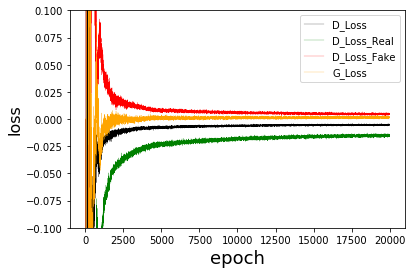

In [11]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25, label = 'D_Loss')

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25, label = 'D_Loss_Real')
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25, label = 'D_Loss_Fake')
plt.plot(gan.g_losses, color='orange', linewidth=0.25, label = "G_Loss")

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

# plt.xlim(0, 2000)
plt.ylim(-0.1, 0.1)
plt.legend()
plt.show()

In [17]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

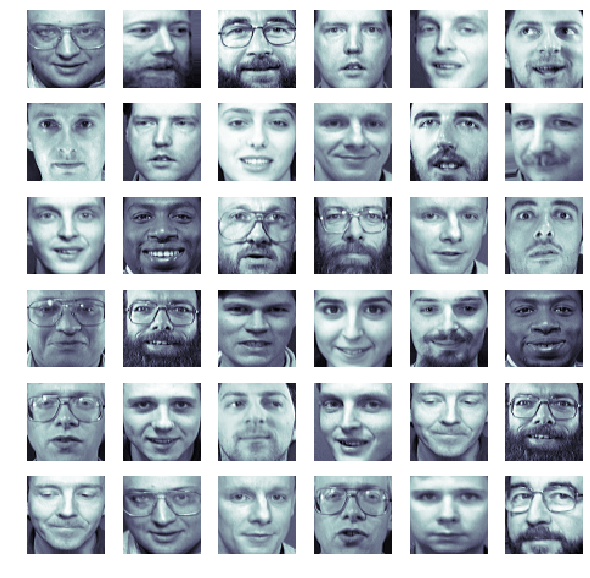

In [12]:
r, c = 6, 6
true_imgs = np.zeros((r*c, 64, 64))
idx = np.random.randint(0, x_train.shape[0], r*c)

for k in range(len(idx)):
    true_imgs[k][:,:] = x_train[idx[k]][:,:,0]

fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(true_imgs[cnt], cmap = plt.cm.bone)
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/real.png"))
plt.show()

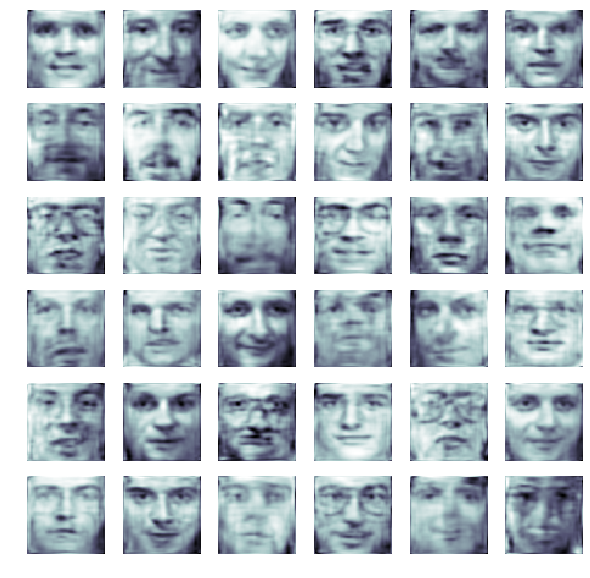

In [24]:
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 0.5 * (gen_imgs + 1)
# gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt][:,:,0], cmap = plt.cm.bone)
        axs[i,j].axis('off')
        cnt += 1
fig.savefig(os.path.join(RUN_FOLDER, "images/sample.png"))
plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10,10))
cnt = 0

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = compare_images(gen_imgs[cnt][:,:,0], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = plt.cm.bone)
        axs[i,j].axis('off')
        cnt += 1

fig.savefig(os.path.join(RUN_FOLDER, "images/sample_closest.png"))
plt.show()